# Ejecución de modelo base

- [1] O. Ronneberger, P. Fischer, and T. Brox, “U-Net: Convolutional Networks for Biomedical Image Segmentation,” CoRR, vol. abs/1505.0, 2015.
- [1] J. Akeret, C. Chang, A. Lucchi, and A. Refregier, “Radio frequency interference mitigation using deep convolutional neural networks,” Astron. Comput., vol. 18, pp. 35–39, 2017.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
import tensorflow as tf
import logging
from collections import OrderedDict
import os
import shutil
from PIL import Image
import h5py
from PIL import Image
import wget #pip install wget

In [21]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

## Implementación de tf_unet
- Obtenido de (Akered, 2017)
- Código: https://github.com/jakeret/tf_unet

### util.py
Obtenido de (Akered, 2017)

In [22]:
def plot_prediction(x_test, y_test, prediction, save=False):
    import matplotlib
    import matplotlib.pyplot as plt
    
    test_size = x_test.shape[0]
    fig, ax = plt.subplots(test_size, 3, figsize=(12,12), sharey=True, sharex=True)
    
    x_test = crop_to_shape(x_test, prediction.shape)
    y_test = crop_to_shape(y_test, prediction.shape)
    
    ax = np.atleast_2d(ax)
    for i in range(test_size):
        cax = ax[i, 0].imshow(x_test[i])
        plt.colorbar(cax, ax=ax[i,0])
        cax = ax[i, 1].imshow(y_test[i, ..., 1])
        plt.colorbar(cax, ax=ax[i,1])
        pred = prediction[i, ..., 1]
        pred -= np.amin(pred)
        pred /= np.amax(pred)
        cax = ax[i, 2].imshow(pred)
        plt.colorbar(cax, ax=ax[i,2])
        if i==0:
            ax[i, 0].set_title("x")
            ax[i, 1].set_title("y")
            ax[i, 2].set_title("pred")
    fig.tight_layout()
    
    if save:
        fig.savefig(save)
    else:
        fig.show()
        plt.show()

def to_rgb(img):
    """
    Converts the given array into a RGB image. If the number of channels is not
    3 the array is tiled such that it has 3 channels. Finally, the values are
    rescaled to [0,255) 
    
    :param img: the array to convert [nx, ny, channels]
    
    :returns img: the rgb image [nx, ny, 3]
    """
    img = np.atleast_3d(img)
    channels = img.shape[2]
    if channels < 3:
        img = np.tile(img, 3)
    
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    img *= 255
    return img

def crop_to_shape(data, shape):
    """
    Crops the array to the given image shape by removing the border (expects a tensor of shape [batches, nx, ny, channels].
    
    :param data: the array to crop
    :param shape: the target shape
    """
    offset0 = (data.shape[1] - shape[1])//2
    offset1 = (data.shape[2] - shape[2])//2
    return data[:, offset0:(-offset0), offset1:(-offset1)]

def combine_img_prediction(data, gt, pred):
    """
    Combines the data, grouth thruth and the prediction into one rgb image
    
    :param data: the data tensor
    :param gt: the ground thruth tensor
    :param pred: the prediction tensor
    
    :returns img: the concatenated rgb image 
    """
    ny = pred.shape[2]
    ch = data.shape[3]
    img = np.concatenate((to_rgb(crop_to_shape(data, pred.shape).reshape(-1, ny, ch)), 
                          to_rgb(crop_to_shape(gt[..., 1], pred.shape).reshape(-1, ny, 1)), 
                          to_rgb(pred[..., 1].reshape(-1, ny, 1))), axis=1)
    return img

def save_image(img, path):
    """
    Writes the image to disk
    
    :param img: the rgb image to save
    :param path: the target path
    """
    Image.fromarray(img.round().astype(np.uint8)).save(path, 'JPEG', dpi=[300,300], quality=90)

### layers.py
Obtenido de (Akered, 2017)

In [23]:
def weight_variable(shape, stddev=0.1, name="weight"):
    initial = tf.truncated_normal(shape, stddev=stddev)
    return tf.Variable(initial, name=name)

def weight_variable_devonc(shape, stddev=0.1, name="weight_devonc"):
    return tf.Variable(tf.truncated_normal(shape, stddev=stddev), name=name)

def bias_variable(shape, name="bias"):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W, b, keep_prob_):
    with tf.name_scope("conv2d"):
        conv_2d = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')
        conv_2d_b = tf.nn.bias_add(conv_2d, b)
        return tf.nn.dropout(conv_2d_b, keep_prob_)

def deconv2d(x, W,stride):
    with tf.name_scope("deconv2d"):
        x_shape = tf.shape(x)
        output_shape = tf.stack([x_shape[0], x_shape[1]*2, x_shape[2]*2, x_shape[3]//2])
        return tf.nn.conv2d_transpose(x, W, output_shape, strides=[1, stride, stride, 1], padding='VALID', name="conv2d_transpose")

def max_pool(x,n):
    return tf.nn.max_pool(x, ksize=[1, n, n, 1], strides=[1, n, n, 1], padding='VALID')

def crop_and_concat(x1,x2):
    with tf.name_scope("crop_and_concat"):
        x1_shape = tf.shape(x1)
        x2_shape = tf.shape(x2)
        # offsets for the top left corner of the crop
        offsets = [0, (x1_shape[1] - x2_shape[1]) // 2, (x1_shape[2] - x2_shape[2]) // 2, 0]
        size = [-1, x2_shape[1], x2_shape[2], -1]
        x1_crop = tf.slice(x1, offsets, size)
        return tf.concat([x1_crop, x2], 3)

def pixel_wise_softmax(output_map):
    with tf.name_scope("pixel_wise_softmax"):
        max_axis = tf.reduce_max(output_map, axis=3, keepdims=True)
        exponential_map = tf.exp(output_map - max_axis)
        normalize = tf.reduce_sum(exponential_map, axis=3, keepdims=True)
        return exponential_map / normalize

def cross_entropy(y_,output_map):
    return -tf.reduce_mean(y_*tf.log(tf.clip_by_value(output_map,1e-10,1.0)), name="cross_entropy")

### Unet
Obtenido de (Akered, 2017)

In [24]:
def create_conv_net(x, keep_prob, channels, n_class, layers=3, features_root=16, filter_size=3, pool_size=2,
                    summaries=True):
    """
    Creates a new convolutional unet for the given parametrization.

    :param x: input tensor, shape [?,nx,ny,channels]
    :param keep_prob: dropout probability tensor
    :param channels: number of channels in the input image
    :param n_class: number of output labels
    :param layers: number of layers in the net
    :param features_root: number of features in the first layer
    :param filter_size: size of the convolution filter
    :param pool_size: size of the max pooling operation
    :param summaries: Flag if summaries should be created
    """

    logging.info(
        "Layers {layers}, features {features}, filter size {filter_size}x{filter_size}, pool size: {pool_size}x{pool_size}".format(
            layers=layers,
            features=features_root,
            filter_size=filter_size,
            pool_size=pool_size))

    # Placeholder for the input image
    with tf.name_scope("preprocessing"):
        nx = tf.shape(x)[1]
        ny = tf.shape(x)[2]
        x_image = tf.reshape(x, tf.stack([-1, nx, ny, channels]))
        in_node = x_image
        batch_size = tf.shape(x_image)[0]

    weights = []
    biases = []
    convs = []
    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()

    in_size = 1000
    size = in_size
    # down layers
    for layer in range(0, layers):
        with tf.name_scope("down_conv_{}".format(str(layer))):
            features = 2 ** layer * features_root
            stddev = np.sqrt(2 / (filter_size ** 2 * features))
            if layer == 0:
                w1 = weight_variable([filter_size, filter_size, channels, features], stddev, name="w1")
            else:
                w1 = weight_variable([filter_size, filter_size, features // 2, features], stddev, name="w1")

            w2 = weight_variable([filter_size, filter_size, features, features], stddev, name="w2")
            b1 = bias_variable([features], name="b1")
            b2 = bias_variable([features], name="b2")

            conv1 = conv2d(in_node, w1, b1, keep_prob)
            tmp_h_conv = tf.nn.relu(conv1)
            conv2 = conv2d(tmp_h_conv, w2, b2, keep_prob)
            dw_h_convs[layer] = tf.nn.relu(conv2)

            weights.append((w1, w2))
            biases.append((b1, b2))
            convs.append((conv1, conv2))

            size -= 4
            if layer < layers - 1:
                pools[layer] = max_pool(dw_h_convs[layer], pool_size)
                in_node = pools[layer]
                size /= 2

    in_node = dw_h_convs[layers - 1]

    # up layers
    for layer in range(layers - 2, -1, -1):
        with tf.name_scope("up_conv_{}".format(str(layer))):
            features = 2 ** (layer + 1) * features_root
            stddev = np.sqrt(2 / (filter_size ** 2 * features))

            wd = weight_variable_devonc([pool_size, pool_size, features // 2, features], stddev, name="wd")
            bd = bias_variable([features // 2], name="bd")
            h_deconv = tf.nn.relu(deconv2d(in_node, wd, pool_size) + bd)
            h_deconv_concat = crop_and_concat(dw_h_convs[layer], h_deconv)
            deconv[layer] = h_deconv_concat

            w1 = weight_variable([filter_size, filter_size, features, features // 2], stddev, name="w1")
            w2 = weight_variable([filter_size, filter_size, features // 2, features // 2], stddev, name="w2")
            b1 = bias_variable([features // 2], name="b1")
            b2 = bias_variable([features // 2], name="b2")

            conv1 = conv2d(h_deconv_concat, w1, b1, keep_prob)
            h_conv = tf.nn.relu(conv1)
            conv2 = conv2d(h_conv, w2, b2, keep_prob)
            in_node = tf.nn.relu(conv2)
            up_h_convs[layer] = in_node

            weights.append((w1, w2))
            biases.append((b1, b2))
            convs.append((conv1, conv2))

            size *= 2
            size -= 4

    # Output Map
    with tf.name_scope("output_map"):
        weight = weight_variable([1, 1, features_root, n_class], stddev)
        bias = bias_variable([n_class], name="bias")
        conv = conv2d(in_node, weight, bias, tf.constant(1.0))
        output_map = tf.nn.relu(conv)
        up_h_convs["out"] = output_map

    if summaries:
        with tf.name_scope("summaries"):
            for i, (c1, c2) in enumerate(convs):
                tf.summary.image('summary_conv_%02d_01' % i, get_image_summary(c1))
                tf.summary.image('summary_conv_%02d_02' % i, get_image_summary(c2))

            for k in pools.keys():
                tf.summary.image('summary_pool_%02d' % k, get_image_summary(pools[k]))

            for k in deconv.keys():
                tf.summary.image('summary_deconv_concat_%02d' % k, get_image_summary(deconv[k]))

            for k in dw_h_convs.keys():
                tf.summary.histogram("dw_convolution_%02d" % k + '/activations', dw_h_convs[k])

            for k in up_h_convs.keys():
                tf.summary.histogram("up_convolution_%s" % k + '/activations', up_h_convs[k])

    variables = []
    for w1, w2 in weights:
        variables.append(w1)
        variables.append(w2)

    for b1, b2 in biases:
        variables.append(b1)
        variables.append(b2)

    return output_map, variables, int(in_size - size)

In [25]:
class Unet(object):
    """
    A unet implementation

    :param channels: (optional) number of channels in the input image
    :param n_class: (optional) number of output labels
    :param cost: (optional) name of the cost function. Default is 'cross_entropy'
    :param cost_kwargs: (optional) kwargs passed to the cost function. See Unet._get_cost for more options
    """

    def __init__(self, channels=3, n_class=2, cost="cross_entropy", cost_kwargs={}, **kwargs):
        tf.reset_default_graph()

        self.n_class = n_class
        self.summaries = kwargs.get("summaries", True)

        self.x = tf.placeholder("float", shape=[None, None, None, channels], name="x")
        self.y = tf.placeholder("float", shape=[None, None, None, n_class], name="y")
        self.keep_prob = tf.placeholder(tf.float32, name="dropout_probability")  # dropout (keep probability)

        logits, self.variables, self.offset = create_conv_net(self.x, self.keep_prob, channels, n_class, **kwargs)

        self.cost = self._get_cost(logits, cost, cost_kwargs)

        self.gradients_node = tf.gradients(self.cost, self.variables)

        with tf.name_scope("cross_entropy"):
            self.cross_entropy = cross_entropy(tf.reshape(self.y, [-1, n_class]),
                                               tf.reshape(pixel_wise_softmax(logits), [-1, n_class]))

        with tf.name_scope("results"):
            self.predicter = pixel_wise_softmax(logits)
            self.correct_pred = tf.equal(tf.argmax(self.predicter, 3), tf.argmax(self.y, 3))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

    def _get_cost(self, logits, cost_name, cost_kwargs):
        """
        Constructs the cost function, either cross_entropy, weighted cross_entropy or dice_coefficient.
        Optional arguments are:
        class_weights: weights for the different classes in case of multi-class imbalance
        regularizer: power of the L2 regularizers added to the loss function
        """

        with tf.name_scope("cost"):
            flat_logits = tf.reshape(logits, [-1, self.n_class])
            flat_labels = tf.reshape(self.y, [-1, self.n_class])
            if cost_name == "cross_entropy":
                class_weights = cost_kwargs.pop("class_weights", None)

                if class_weights is not None:
                    class_weights = tf.constant(np.array(class_weights, dtype=np.float32))

                    weight_map = tf.multiply(flat_labels, class_weights)
                    weight_map = tf.reduce_sum(weight_map, axis=1)

                    loss_map = tf.nn.softmax_cross_entropy_with_logits_v2(logits=flat_logits,
                                                                          labels=flat_labels)
                    weighted_loss = tf.multiply(loss_map, weight_map)

                    loss = tf.reduce_mean(weighted_loss)

                else:
                    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=flat_logits,
                                                                                     labels=flat_labels))
            elif cost_name == "dice_coefficient":
                eps = 1e-5
                prediction = pixel_wise_softmax(logits)
                intersection = tf.reduce_sum(prediction * self.y)
                union = eps + tf.reduce_sum(prediction) + tf.reduce_sum(self.y)
                loss = -(2 * intersection / (union))

            else:
                raise ValueError("Unknown cost function: " % cost_name)

            regularizer = cost_kwargs.pop("regularizer", None)
            if regularizer is not None:
                regularizers = sum([tf.nn.l2_loss(variable) for variable in self.variables])
                loss += (regularizer * regularizers)

            return loss

    def predict(self, model_path, x_test):
        """
        Uses the model to create a prediction for the given data

        :param model_path: path to the model checkpoint to restore
        :param x_test: Data to predict on. Shape [n, nx, ny, channels]
        :returns prediction: The unet prediction Shape [n, px, py, labels] (px=nx-self.offset/2)
        """

        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            # Initialize variables
            sess.run(init)

            # Restore model weights from previously saved model
            self.restore(sess, model_path)

            y_dummy = np.empty((x_test.shape[0], x_test.shape[1], x_test.shape[2], self.n_class))
            prediction = sess.run(self.predicter, feed_dict={self.x: x_test, self.y: y_dummy, self.keep_prob: 1.})

        return prediction

    def save(self, sess, model_path):
        """
        Saves the current session to a checkpoint

        :param sess: current session
        :param model_path: path to file system location
        """

        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path

    def restore(self, sess, model_path):
        """
        Restores a session from a checkpoint

        :param sess: current session instance
        :param model_path: path to file system checkpoint location
        """

        saver = tf.train.Saver()
        saver.restore(sess, model_path)
        logging.info("Model restored from file: %s" % model_path)

In [26]:
def _update_avg_gradients(avg_gradients, gradients, step):
    if avg_gradients is None:
        avg_gradients = [np.zeros_like(gradient) for gradient in gradients]
    for i in range(len(gradients)):
        avg_gradients[i] = (avg_gradients[i] * (1.0 - (1.0 / (step + 1)))) + (gradients[i] / (step + 1))

    return avg_gradients


def error_rate(predictions, labels):
    """
    Return the error rate based on dense predictions and 1-hot labels.
    """

    return 100.0 - (
            100.0 *
            np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) /
            (predictions.shape[0] * predictions.shape[1] * predictions.shape[2]))


def get_image_summary(img, idx=0):
    """
    Make an image summary for 4d tensor image with index idx
    """

    V = tf.slice(img, (0, 0, 0, idx), (1, -1, -1, 1))
    V -= tf.reduce_min(V)
    V /= tf.reduce_max(V)
    V *= 255

    img_w = tf.shape(img)[1]
    img_h = tf.shape(img)[2]
    V = tf.reshape(V, tf.stack((img_w, img_h, 1)))
    V = tf.transpose(V, (2, 0, 1))
    V = tf.reshape(V, tf.stack((-1, img_w, img_h, 1)))
    return V

In [27]:
class Trainer(object):
    """
    Trains a unet instance

    :param net: the unet instance to train
    :param batch_size: size of training batch
    :param verification_batch_size: size of verification batch
    :param norm_grads: (optional) true if normalized gradients should be added to the summaries
    :param optimizer: (optional) name of the optimizer to use (momentum or adam)
    :param opt_kwargs: (optional) kwargs passed to the learning rate (momentum opt) and to the optimizer

    """

    def __init__(self, net, batch_size=1, verification_batch_size = 4, norm_grads=False, optimizer="momentum", opt_kwargs={}):
        self.net = net
        self.batch_size = batch_size
        self.verification_batch_size = verification_batch_size
        self.norm_grads = norm_grads
        self.optimizer = optimizer
        self.opt_kwargs = opt_kwargs

    def _get_optimizer(self, training_iters, global_step):
        if self.optimizer == "momentum":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.2)
            decay_rate = self.opt_kwargs.pop("decay_rate", 0.95)
            momentum = self.opt_kwargs.pop("momentum", 0.2)

            self.learning_rate_node = tf.train.exponential_decay(learning_rate=learning_rate,
                                                                 global_step=global_step,
                                                                 decay_steps=training_iters,
                                                                 decay_rate=decay_rate,
                                                                 staircase=True)

            optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate_node, momentum=momentum,
                                                   **self.opt_kwargs).minimize(self.net.cost,
                                                                               global_step=global_step)
        elif self.optimizer == "adam":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.001)
            self.learning_rate_node = tf.Variable(learning_rate, name="learning_rate")

            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate_node,
                                               **self.opt_kwargs).minimize(self.net.cost,
                                                                           global_step=global_step)

        return optimizer

    def _initialize(self, training_iters, output_path, restore, prediction_path):
        global_step = tf.Variable(0, name="global_step")

        self.norm_gradients_node = tf.Variable(tf.constant(0.0, shape=[len(self.net.gradients_node)]), name="norm_gradients")

        if self.net.summaries and self.norm_grads:
            tf.summary.histogram('norm_grads', self.norm_gradients_node)

        tf.summary.scalar('loss', self.net.cost)
        tf.summary.scalar('cross_entropy', self.net.cross_entropy)
        tf.summary.scalar('accuracy', self.net.accuracy)

        self.optimizer = self._get_optimizer(training_iters, global_step)
        tf.summary.scalar('learning_rate', self.learning_rate_node)

        self.summary_op = tf.summary.merge_all()
        init = tf.global_variables_initializer()

        self.prediction_path = prediction_path
        abs_prediction_path = os.path.abspath(self.prediction_path)
        output_path = os.path.abspath(output_path)

        if not restore:
            logging.info("Removing '{:}'".format(abs_prediction_path))
            shutil.rmtree(abs_prediction_path, ignore_errors=True)
            logging.info("Removing '{:}'".format(output_path))
            shutil.rmtree(output_path, ignore_errors=True)

        if not os.path.exists(abs_prediction_path):
            logging.info("Allocating '{:}'".format(abs_prediction_path))
            os.makedirs(abs_prediction_path)

        if not os.path.exists(output_path):
            logging.info("Allocating '{:}'".format(output_path))
            os.makedirs(output_path)

        return init

    def train(self, data_provider, output_path, training_iters=10, epochs=100, dropout=0.75, display_step=1,
              restore=False, write_graph=False, prediction_path='prediction'):
        """
        Lauches the training process

        :param data_provider: callable returning training and verification data
        :param output_path: path where to store checkpoints
        :param training_iters: number of training mini batch iteration
        :param epochs: number of epochs
        :param dropout: dropout probability
        :param display_step: number of steps till outputting stats
        :param restore: Flag if previous model should be restored
        :param write_graph: Flag if the computation graph should be written as protobuf file to the output path
        :param prediction_path: path where to save predictions on each epoch
        """
        save_path = os.path.join(output_path, "model.ckpt")
        if epochs == 0:
            return save_path

        init = self._initialize(training_iters, output_path, restore, prediction_path)

        with tf.Session() as sess:
            if write_graph:
                tf.train.write_graph(sess.graph_def, output_path, "graph.pb", False)

            sess.run(init)

            if restore:
                ckpt = tf.train.get_checkpoint_state(output_path)
                if ckpt and ckpt.model_checkpoint_path:
                    self.net.restore(sess, ckpt.model_checkpoint_path)

            test_x, test_y = data_provider(self.verification_batch_size)
            pred_shape = self.store_prediction(sess, test_x, test_y, "_init")

            summary_writer = tf.summary.FileWriter(output_path, graph=sess.graph)
            logging.info("Start optimization")

            avg_gradients = None
            for epoch in range(epochs):
                total_loss = 0
                for step in range((epoch * training_iters), ((epoch + 1) * training_iters)):
                    batch_x, batch_y = data_provider(self.batch_size)

                    # Run optimization op (backprop)
                    _, loss, lr, gradients = sess.run(
                        (self.optimizer, self.net.cost, self.learning_rate_node, self.net.gradients_node),
                        feed_dict={self.net.x: batch_x,
                                   self.net.y: crop_to_shape(batch_y, pred_shape),
                                   self.net.keep_prob: dropout})

                    if self.net.summaries and self.norm_grads:
                        avg_gradients = _update_avg_gradients(avg_gradients, gradients, step)
                        norm_gradients = [np.linalg.norm(gradient) for gradient in avg_gradients]
                        self.norm_gradients_node.assign(norm_gradients).eval()

                    if step % display_step == 0:
                        self.output_minibatch_stats(sess, summary_writer, step, batch_x,
                                                    crop_to_shape(batch_y, pred_shape))

                    total_loss += loss

                self.output_epoch_stats(epoch, total_loss, training_iters, lr)
                self.store_prediction(sess, test_x, test_y, "epoch_%s" % epoch)

                save_path = self.net.save(sess, save_path)
            logging.info("Optimization Finished!")

            return save_path

    def store_prediction(self, sess, batch_x, batch_y, name):
        prediction = sess.run(self.net.predicter, feed_dict={self.net.x: batch_x,
                                                             self.net.y: batch_y,
                                                             self.net.keep_prob: 1.})
        pred_shape = prediction.shape

        loss = sess.run(self.net.cost, feed_dict={self.net.x: batch_x,
                                                  self.net.y: crop_to_shape(batch_y, pred_shape),
                                                  self.net.keep_prob: 1.})

        logging.info("Verification error= {:.1f}%, loss= {:.4f}".format(error_rate(prediction,
                                                                                   crop_to_shape(batch_y,
                                                                                                      prediction.shape)),
                                                                        loss))

        img = combine_img_prediction(batch_x, batch_y, prediction)
        save_image(img, "%s/%s.jpg" % (self.prediction_path, name))

        return pred_shape

    def output_epoch_stats(self, epoch, total_loss, training_iters, lr):
        logging.info(
            "Epoch {:}, Average loss: {:.4f}, learning rate: {:.4f}".format(epoch, (total_loss / training_iters), lr))

    def output_minibatch_stats(self, sess, summary_writer, step, batch_x, batch_y):
        # Calculate batch loss and accuracy
        summary_str, loss, acc, predictions = sess.run([self.summary_op,
                                                        self.net.cost,
                                                        self.net.accuracy,
                                                        self.net.predicter],
                                                       feed_dict={self.net.x: batch_x,
                                                                  self.net.y: batch_y,
                                                                  self.net.keep_prob: 1.})
        summary_writer.add_summary(summary_str, step)
        summary_writer.flush()
        logging.info(
            "Iter {:}, Minibatch Loss= {:.4f}, Training Accuracy= {:.4f}, Minibatch error= {:.1f}%".format(step,
                                                                                                           loss,
                                                                                                           acc,
                                                                                                           error_rate(
                                                                                                               predictions,
                                                                                                               batch_y)))
    

### image_util
Obtenido de (Akered, 2017)

In [28]:
class BaseDataProvider(object):
    """
    Abstract base class for DataProvider implementation. Subclasses have to
    overwrite the `_next_data` method that load the next data and label array.
    This implementation automatically clips the data with the given min/max and
    normalizes the values to (0,1]. To change this behavoir the `_process_data`
    method can be overwritten. To enable some post processing such as data
    augmentation the `_post_process` method can be overwritten.

    :param a_min: (optional) min value used for clipping
    :param a_max: (optional) max value used for clipping

    """
    channels = 1
    n_class = 2    
    
    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf
        
    def _load_data_and_label(self):
        data, label = self._next_data()
        train_data = self._process_data(data)
        labels = self._process_labels(label)
        train_data, labels = self._post_process(train_data, labels)
        nx = train_data.shape[1]
        ny = train_data.shape[0]  
        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)
            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels
        
        return label
    
    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)
        data /= np.amax(data)
        return data
    
    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        
        :param data: the data array
        :param labels: the label array
        """
        return data, labels    
    
    def reset_ids(self):
        self._reset_ids();
        
    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]
    
        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))
    
        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels
    
        return X, Y        

In [29]:
class SimpleDataProvider(BaseDataProvider):
    """
    A simple data provider for numpy arrays. 
    Assumes that the data and label are numpy array with the dimensions
    data `[n, X, Y, channels]`, label `[n, X, Y, classes]`. Where
    `n` is the number of images, `X`, `Y` the size of the image.

    :param data: data numpy array. Shape=[n, X, Y, channels]
    :param label: label numpy array. Shape=[n, X, Y, classes]
    :param a_min: (optional) min value used for clipping
    :param a_max: (optional) max value used for clipping
    :param channels: (optional) number of channels, default=1
    :param n_class: (optional) number of classes, default=2
    
    """
    
    def __init__(self, data, label, a_min=None, a_max=None, channels=1, n_class = 2):
        super(SimpleDataProvider, self).__init__(a_min, a_max)
        self.data = data
        self.label = label
        self.file_count = data.shape[0]
        self.n_class = n_class
        self.channels = channels

    def _next_data(self):
        idx = np.random.choice(self.file_count)
        return self.data[idx], self.label[idx]

In [30]:
class ImageDataProvider(BaseDataProvider):
    """
    Generic data provider for images, supports gray scale and colored images.
    Assumes that the data images and label images are stored in the same folder
    and that the labels have a different file suffix 
    e.g. 'train/fish_1.tif' and 'train/fish_1_mask.tif'

    Usage:
    data_provider = ImageDataProvider("..fishes/train/*.tif")
        
    :param search_path: a glob search pattern to find all data and label images
    :param a_min: (optional) min value used for clipping
    :param a_max: (optional) max value used for clipping
    :param data_suffix: suffix pattern for the data images. Default '.tif'
    :param mask_suffix: suffix pattern for the label images. Default '_mask.tif'
    :param shuffle_data: if the order of the loaded file path should be randomized. Default 'True'
    :param channels: (optional) number of channels, default=1
    :param n_class: (optional) number of classes, default=2
    
    """
    
    def __init__(self, search_path, a_min=None, a_max=None, data_suffix=".tif", mask_suffix='_mask.tif', shuffle_data=True, n_class = 2):
        super(ImageDataProvider, self).__init__(a_min, a_max)
        self.data_suffix = data_suffix
        self.mask_suffix = mask_suffix
        self.file_idx = -1
        self.file_frame_idx = -1 #cantidad de frames por imagen
        self.file_n_frames = 1 #tamaño de frames de imagen
        self.file_n_frames_ids = [] #ids de cada frame
        self.shuffle_data = shuffle_data
        self.n_class = n_class
        self.data_files = self._find_data_files(search_path)
        
        if self.shuffle_data:
            np.random.shuffle(self.data_files)
        
        assert len(self.data_files) > 0, "No training files"
        print("Number of files used: %s" % len(self.data_files))
        
        img = self._load_file(self.data_files[0])
        self.channels = 1 if len(img.shape) == 2 else img.shape[-1]
        
    def _find_data_files(self, search_path):
        all_files = glob.glob(search_path)
        return [name for name in all_files if self.data_suffix in name and not self.mask_suffix in name]
    
    def _load_file(self, path, dtype=np.float32):
        img = np.array(Image.open(path), dtype)
        return img
    
    def _load_tif_file(self, path):
        img_tif = Image.open(path)
        return img_tif

    #Método modificado para soportar frames en los TIF
    def _cylce_file(self):
        if self.file_n_frames == (self.file_frame_idx + 1):
            self.file_idx += 1
            self.file_frame_idx = 0
            if self.file_idx >= len(self.data_files):
                self.file_idx = 0
                self.file_frame_idx = 0
                if self.shuffle_data:
                    np.random.shuffle(self.data_files)
        else:
            self.file_frame_idx += 1
            
        if self.file_idx == -1:
            self.file_idx = 0

    #Método modificado para soportar frames en los TIF
    def _next_data(self):
        self._cylce_file()
        image_name = self.data_files[self.file_idx]
        label_name = image_name.replace(self.data_suffix, self.mask_suffix)
        tif_image = self._load_tif_file(image_name)
        tif_label = self._load_tif_file(label_name)
        self.file_n_frames = tif_image.n_frames
        
        if self.file_frame_idx == 0:
            self.file_n_frames_ids = np.arange(0, self.file_n_frames)
            np.random.shuffle(self.file_n_frames_ids)
        print("Image name " + image_name + " - Frame Id: " + str(self.file_n_frames_ids[self.file_frame_idx]) + " - #Frame: " + str(self.file_frame_idx))
        
        tif_image.seek(self.file_n_frames_ids[self.file_frame_idx])
        tif_label.seek(self.file_n_frames_ids[self.file_frame_idx])
        
        img = np.array(tif_image, np.float32)
        label = np.array(tif_label, np.bool)
    
        return img,label
    
    #Nuevo metodo para reiniciar los ids
    def _reset_ids(self):
        print("Ids reiniciados")
        self.file_idx = -1
        self.file_frame_idx = -1 #cantidad de frames por imagen
        self.file_n_frames = 1 #tamaño de frames de imagen
        self.file_n_frames_ids = [] #ids de cada frame

### image_gen
Obtenido de (Akered, 2017)

In [31]:
def create_image_and_label(nx, ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):
        image = np.ones((nx, ny, 1))
        label = np.zeros((nx, ny, 3), dtype=np.bool)
        mask = np.zeros((nx, ny), dtype=np.bool)
        for _ in range(cnt):
            a = np.random.randint(border, nx-border)
            b = np.random.randint(border, ny-border)
            r = np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)

            y,x = np.ogrid[-a:nx-a, -b:ny-b]
            m = x*x + y*y <= r*r
            mask = np.logical_or(mask, m)

            image[m] = h

        label[mask, 1] = 1

        if rectangles:
            mask = np.zeros((nx, ny), dtype=np.bool)
            for _ in range(cnt//2):
                a = np.random.randint(nx)
                b = np.random.randint(ny)
                r =  np.random.randint(r_min, r_max)
                h = np.random.randint(1,255)

                m = np.zeros((nx, ny), dtype=np.bool)
                m[a:a+r, b:b+r] = True
                mask = np.logical_or(mask, m)
                image[m] = h

            label[mask, 2] = 1

            label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))

        image += np.random.normal(scale=sigma, size=image.shape)
        image -= np.amin(image)
        image /= np.amax(image)

        if rectangles:
            return image, label
        else:
            return image, label[..., 1] 

In [32]:
class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2
    
    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3
        
    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)   
    
    def _reset_ids(self):
        self

## Entranmientos y pruebas
Pruebas con diferentes conjuntos de datos
- Utilizar imágenes del formato TIFF. 
- Se recomienda visualizar las imágenes con el siguiente editor: https://fiji.sc/
- Cada prueba tiene una variable que comienza con ENTRENAR (Ej. ENTRENAR_BROAD_TOY_PROBLEM_MODEL). Esa variable indica si vamos a reutilizar un modelo ya entrenado o vamos a entrenar de nuevo. Se recomienda que sea True al entrenar y luego pasarlo a False. 

In [33]:
class Pruebas():
    
    def train(self, data_provider, trained_folder, training_iters=32, epochs=10, batch_size=1, train = True):
        x_train, y_train = data_provider(1)        
        data_provider.reset_ids()
        fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
        ax[0].imshow(x_train[0,...,0], aspect="auto")
        ax[1].imshow(y_train[0,...,1], aspect="auto") 
        plt.show()
        net = Unet(channels=data_provider.channels, n_class=data_provider.n_class, layers=3, features_root=16)
        trainer = Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=0.2), batch_size=batch_size)
        if train:
            path = trainer.train(data_provider, "./" + trained_folder, 
                                 training_iters = training_iters, 
                                 epochs = epochs, 
                                 display_step = 2, 
                                 prediction_path='prediction_' + trained_folder)
        return net
        
    def test(self, model, data_provider, trained_folder, sin_mascara=False):
        x_test, y_test = data_provider(1)
        prediction = model.predict("./" + trained_folder + "/model.ckpt", x_test)
        cantidad_graficas = (2 if sin_mascara else 3)
        fig, ax = plt.subplots(1, cantidad_graficas, sharex=True, sharey=True, figsize=(12,5))
        ax[0].imshow(x_test[0,...,0], aspect="auto")
        ax[0].set_title("Input")
        if not sin_mascara:
            ax[1].imshow(y_test[0,...,1], aspect="auto")
            mask = prediction[0,...,1] > 0.9
            ax[2].imshow(mask, aspect="auto")
            ax[1].set_title("Ground truth")
            ax[2].set_title("Prediction")
        else: 
            mask = prediction[0,...,1] > 0.9
            ax[1].imshow(mask, aspect="auto") 
            ax[1].set_title("Prediction")
        fig.tight_layout()
        fig.savefig("img/"+ "./" + trained_folder+".png")        

### demo_toy_problem
- Demos obtenidos del repositorio https://github.com/jakeret/tf_unet
- Crea una imágen con valores aleatóreos

In [71]:
TRAINED_FOLDER_TOY_PROBLEM = "unet_trained_toy_problem"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_BROAD_TOY_PROBLEM_MODEL = False

In [35]:
def generar_toy_image():
    nx = 572
    ny = 572
    plt.rcParams['image.cmap'] = 'gist_earth'
    np.random.seed(98765)
    return GrayScaleDataProvider(nx, ny, cnt=20);

Train

In [36]:
data_provider_toy_problem_train = generar_toy_image()

In [37]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_toy_problem = Pruebas();

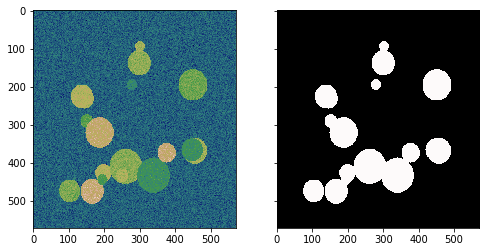

2018-09-27 15:53:50,617 Layers 3, features 16, filter size 3x3, pool size: 2x2
2018-09-27 15:53:51,782 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_toy_problem'
2018-09-27 15:53:51,784 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained_toy_problem'
2018-09-27 15:53:51,786 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_toy_problem'
2018-09-27 15:53:58,541 Verification error= 72.2%, loss= 0.6973
2018-09-27 15:53:59,180 Start optimization
2018-09-27 15:54:03,938 Iter 0, Minibatch Loss= 0.6420, Training Accuracy= 0.8080, Minibatch error= 19.2%
2018-09-27 15:54:11,201 Iter 2, Minibatch Loss= 0.5456, Training Accuracy= 0.8856, Minibatch error= 11.4%
2018-09-27 15:54:18,417 Iter 4, Minibatch Loss= 0.5314, Training Accuracy= 0.8146, Minibatch error= 18.5%
2018-09-27 15:54:25,828 Iter 6, Minibatch Loss= 0.4343, Training Accuracy= 0.8623, Minibatch error= 13.

2018-09-27 16:02:35,965 Iter 134, Minibatch Loss= 0.1657, Training Accuracy= 0.9458, Minibatch error= 5.4%
2018-09-27 16:02:43,054 Iter 136, Minibatch Loss= 0.1340, Training Accuracy= 0.9509, Minibatch error= 4.9%
2018-09-27 16:02:50,912 Iter 138, Minibatch Loss= 0.1154, Training Accuracy= 0.9669, Minibatch error= 3.3%
2018-09-27 16:02:58,228 Iter 140, Minibatch Loss= 0.1591, Training Accuracy= 0.9491, Minibatch error= 5.1%
2018-09-27 16:03:05,387 Iter 142, Minibatch Loss= 0.0607, Training Accuracy= 0.9836, Minibatch error= 1.6%
2018-09-27 16:03:12,756 Iter 144, Minibatch Loss= 0.0573, Training Accuracy= 0.9809, Minibatch error= 1.9%
2018-09-27 16:03:19,983 Iter 146, Minibatch Loss= 0.1280, Training Accuracy= 0.9570, Minibatch error= 4.3%
2018-09-27 16:03:27,038 Iter 148, Minibatch Loss= 0.0899, Training Accuracy= 0.9777, Minibatch error= 2.2%
2018-09-27 16:03:34,108 Iter 150, Minibatch Loss= 0.0735, Training Accuracy= 0.9702, Minibatch error= 3.0%
2018-09-27 16:03:41,175 Iter 152, Min

2018-09-27 16:11:42,242 Iter 278, Minibatch Loss= 0.0407, Training Accuracy= 0.9909, Minibatch error= 0.9%
2018-09-27 16:11:50,047 Iter 280, Minibatch Loss= 0.1001, Training Accuracy= 0.9712, Minibatch error= 2.9%
2018-09-27 16:11:57,450 Iter 282, Minibatch Loss= 0.0388, Training Accuracy= 0.9928, Minibatch error= 0.7%
2018-09-27 16:12:04,964 Iter 284, Minibatch Loss= 0.0620, Training Accuracy= 0.9800, Minibatch error= 2.0%
2018-09-27 16:12:12,665 Iter 286, Minibatch Loss= 0.0474, Training Accuracy= 0.9874, Minibatch error= 1.3%
2018-09-27 16:12:15,804 Epoch 8, Average loss: 0.0983, learning rate: 0.1327
2018-09-27 16:12:21,625 Verification error= 2.3%, loss= 0.0784
2018-09-27 16:12:26,280 Iter 288, Minibatch Loss= 0.0577, Training Accuracy= 0.9845, Minibatch error= 1.5%
2018-09-27 16:12:33,382 Iter 290, Minibatch Loss= 0.0416, Training Accuracy= 0.9886, Minibatch error= 1.1%
2018-09-27 16:12:41,311 Iter 292, Minibatch Loss= 0.1050, Training Accuracy= 0.9591, Minibatch error= 4.1%
2018

In [38]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_*
#########################
model_toy_problem = pruebas_toy_problem.train(data_provider_toy_problem_train, 
                                              TRAINED_FOLDER_TOY_PROBLEM, 
                                              32, #iterations
                                              10, #epoch
                                              1, #batch size 
                                              ENTRENAR_BROAD_TOY_PROBLEM_MODEL)

Test

In [39]:
data_provider_toy_problem_test = data_provider_toy_problem_train

INFO:tensorflow:Restoring parameters from ./unet_trained_toy_problem/model.ckpt


2018-09-27 16:14:26,554 Restoring parameters from ./unet_trained_toy_problem/model.ckpt
2018-09-27 16:14:26,618 Model restored from file: ./unet_trained_toy_problem/model.ckpt


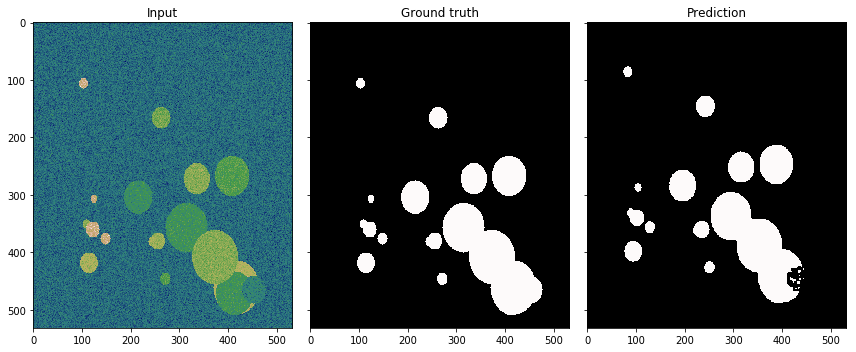

In [40]:
pruebas_toy_problem.test(model_toy_problem, data_provider_toy_problem_test, TRAINED_FOLDER_TOY_PROBLEM)

### EM segmentation challenge - ISBI 2012
- http://brainiac2.mit.edu/isbi_challenge/
- Es la que usan en el paper base (Ronneberger et al., 2015)
- Resolución: 512 x 512 x 30
- No existen imágenes de máscaras para conjunto de pruebas

In [70]:
PATH_ISBI_2012_TRAIN = "dataset/isbi-challenge/train/"
PATH_ISBI_2012_TEST = "dataset/isbi-challenge/test/"
TRAINED_FOLDER_ISBI_2012 = "unet_trained_isbi_2012"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_BROAD_ISBI_2012_MODEL = False

Train

In [42]:
data_provider_isbi_2012_train = ImageDataProvider(PATH_ISBI_2012_TRAIN + "*.tif")

Number of files used: 1


In [43]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_isbi_2012 = Pruebas();

Image name dataset/isbi-challenge/train\train.tif - Frame Id: 17 - #Frame: 24
Ids reiniciados


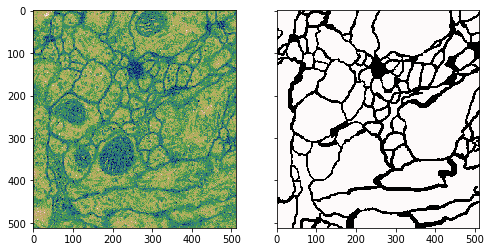

2018-09-27 16:59:44,989 Layers 3, features 16, filter size 3x3, pool size: 2x2
2018-09-27 16:59:46,194 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_isbi_2012'
2018-09-27 16:59:46,204 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained_isbi_2012'
2018-09-27 16:59:46,209 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_isbi_2012'


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 8 - #Frame: 0
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 24 - #Frame: 1
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 12 - #Frame: 2
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 25 - #Frame: 3


2018-09-27 16:59:51,163 Verification error= 77.6%, loss= 0.7332
2018-09-27 16:59:51,723 Start optimization


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 27 - #Frame: 4


2018-09-27 16:59:55,491 Iter 0, Minibatch Loss= 0.6601, Training Accuracy= 0.7915, Minibatch error= 20.9%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 4 - #Frame: 5
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 20 - #Frame: 6


2018-09-27 17:00:01,290 Iter 2, Minibatch Loss= 0.6046, Training Accuracy= 0.7748, Minibatch error= 22.5%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 17 - #Frame: 7
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 28 - #Frame: 8


2018-09-27 17:00:07,048 Iter 4, Minibatch Loss= 0.5529, Training Accuracy= 0.7985, Minibatch error= 20.1%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 29 - #Frame: 9
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 5 - #Frame: 10


2018-09-27 17:00:12,785 Iter 6, Minibatch Loss= 0.5851, Training Accuracy= 0.7185, Minibatch error= 28.1%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 11 - #Frame: 11
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 3 - #Frame: 12


2018-09-27 17:00:18,526 Iter 8, Minibatch Loss= 0.5425, Training Accuracy= 0.7545, Minibatch error= 24.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 19 - #Frame: 13
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 14 - #Frame: 14


2018-09-27 17:00:24,168 Iter 10, Minibatch Loss= 0.4702, Training Accuracy= 0.8077, Minibatch error= 19.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 15 - #Frame: 15
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 0 - #Frame: 16


2018-09-27 17:00:29,934 Iter 12, Minibatch Loss= 0.5151, Training Accuracy= 0.7707, Minibatch error= 22.9%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 1 - #Frame: 17
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 16 - #Frame: 18


2018-09-27 17:00:35,595 Iter 14, Minibatch Loss= 0.4840, Training Accuracy= 0.7947, Minibatch error= 20.5%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 23 - #Frame: 19
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 22 - #Frame: 20


2018-09-27 17:00:41,317 Iter 16, Minibatch Loss= 0.4691, Training Accuracy= 0.8034, Minibatch error= 19.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 10 - #Frame: 21
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 7 - #Frame: 22


2018-09-27 17:00:46,984 Iter 18, Minibatch Loss= 0.5361, Training Accuracy= 0.7473, Minibatch error= 25.3%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 21 - #Frame: 23
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 9 - #Frame: 24


2018-09-27 17:00:52,502 Iter 20, Minibatch Loss= 0.5011, Training Accuracy= 0.7677, Minibatch error= 23.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 2 - #Frame: 25
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 26 - #Frame: 26


2018-09-27 17:00:58,096 Iter 22, Minibatch Loss= 0.4717, Training Accuracy= 0.7937, Minibatch error= 20.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 6 - #Frame: 27
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 13 - #Frame: 28


2018-09-27 17:01:03,786 Iter 24, Minibatch Loss= 0.4689, Training Accuracy= 0.7871, Minibatch error= 21.3%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 18 - #Frame: 29
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 24 - #Frame: 0


2018-09-27 17:01:09,346 Iter 26, Minibatch Loss= 0.4277, Training Accuracy= 0.8154, Minibatch error= 18.5%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 23 - #Frame: 1
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 8 - #Frame: 2


2018-09-27 17:01:15,113 Iter 28, Minibatch Loss= 0.4852, Training Accuracy= 0.7563, Minibatch error= 24.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 10 - #Frame: 3
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 6 - #Frame: 4


2018-09-27 17:01:20,763 Iter 30, Minibatch Loss= 0.4805, Training Accuracy= 0.7509, Minibatch error= 24.9%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 0 - #Frame: 5


2018-09-27 17:01:23,294 Epoch 0, Average loss: 0.5304, learning rate: 0.2000
2018-09-27 17:01:28,011 Verification error= 22.4%, loss= 0.4504


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 19 - #Frame: 6


2018-09-27 17:01:31,862 Iter 32, Minibatch Loss= 0.4540, Training Accuracy= 0.7664, Minibatch error= 23.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 4 - #Frame: 7
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 20 - #Frame: 8


2018-09-27 17:01:37,617 Iter 34, Minibatch Loss= 0.4429, Training Accuracy= 0.7748, Minibatch error= 22.5%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 21 - #Frame: 9
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 15 - #Frame: 10


2018-09-27 17:01:43,174 Iter 36, Minibatch Loss= 0.3949, Training Accuracy= 0.7934, Minibatch error= 20.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 18 - #Frame: 11
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 28 - #Frame: 12


2018-09-27 17:01:48,964 Iter 38, Minibatch Loss= 0.3696, Training Accuracy= 0.7985, Minibatch error= 20.1%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 11 - #Frame: 13
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 7 - #Frame: 14


2018-09-27 17:01:54,571 Iter 40, Minibatch Loss= 0.4135, Training Accuracy= 0.7473, Minibatch error= 25.3%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 5 - #Frame: 15
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 27 - #Frame: 16


2018-09-27 17:02:00,346 Iter 42, Minibatch Loss= 0.3754, Training Accuracy= 0.7915, Minibatch error= 20.9%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 13 - #Frame: 17
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 22 - #Frame: 18


2018-09-27 17:02:06,232 Iter 44, Minibatch Loss= 0.4817, Training Accuracy= 0.8034, Minibatch error= 19.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 12 - #Frame: 19
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 16 - #Frame: 20


2018-09-27 17:02:11,882 Iter 46, Minibatch Loss= 0.3568, Training Accuracy= 0.7947, Minibatch error= 20.5%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 9 - #Frame: 21
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 14 - #Frame: 22


2018-09-27 17:02:17,636 Iter 48, Minibatch Loss= 0.4076, Training Accuracy= 0.8077, Minibatch error= 19.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 25 - #Frame: 23
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 29 - #Frame: 24


2018-09-27 17:02:23,401 Iter 50, Minibatch Loss= 0.3072, Training Accuracy= 0.8329, Minibatch error= 16.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 26 - #Frame: 25
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 17 - #Frame: 26


2018-09-27 17:02:29,185 Iter 52, Minibatch Loss= 0.3734, Training Accuracy= 0.7726, Minibatch error= 22.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 2 - #Frame: 27
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 1 - #Frame: 28


2018-09-27 17:02:34,858 Iter 54, Minibatch Loss= 0.4019, Training Accuracy= 0.7600, Minibatch error= 24.0%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 3 - #Frame: 29
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 3 - #Frame: 0


2018-09-27 17:02:40,557 Iter 56, Minibatch Loss= 0.4030, Training Accuracy= 0.7545, Minibatch error= 24.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 4 - #Frame: 1
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 11 - #Frame: 2


2018-09-27 17:02:46,322 Iter 58, Minibatch Loss= 0.3960, Training Accuracy= 0.7657, Minibatch error= 23.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 7 - #Frame: 3
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 17 - #Frame: 4


2018-09-27 17:02:52,755 Iter 60, Minibatch Loss= 0.3579, Training Accuracy= 0.7726, Minibatch error= 22.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 0 - #Frame: 5
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 1 - #Frame: 6


2018-09-27 17:02:58,436 Iter 62, Minibatch Loss= 0.4628, Training Accuracy= 0.7600, Minibatch error= 24.0%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 19 - #Frame: 7


2018-09-27 17:03:00,909 Epoch 1, Average loss: 0.4300, learning rate: 0.1900
2018-09-27 17:03:05,584 Verification error= 22.4%, loss= 0.5451


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 9 - #Frame: 8


2018-09-27 17:03:09,381 Iter 64, Minibatch Loss= 0.3261, Training Accuracy= 0.7677, Minibatch error= 23.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 14 - #Frame: 9
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 6 - #Frame: 10


2018-09-27 17:03:15,027 Iter 66, Minibatch Loss= 0.3714, Training Accuracy= 0.7509, Minibatch error= 24.9%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 26 - #Frame: 11
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 13 - #Frame: 12


2018-09-27 17:03:20,722 Iter 68, Minibatch Loss= 0.3321, Training Accuracy= 0.7871, Minibatch error= 21.3%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 28 - #Frame: 13
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 21 - #Frame: 14


2018-09-27 17:03:26,348 Iter 70, Minibatch Loss= 0.4001, Training Accuracy= 0.7935, Minibatch error= 20.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 23 - #Frame: 15
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 12 - #Frame: 16


2018-09-27 17:03:32,028 Iter 72, Minibatch Loss= 0.3668, Training Accuracy= 0.7356, Minibatch error= 26.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 10 - #Frame: 17
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 22 - #Frame: 18


2018-09-27 17:03:37,676 Iter 74, Minibatch Loss= 0.4742, Training Accuracy= 0.8034, Minibatch error= 19.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 8 - #Frame: 19
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 18 - #Frame: 20


2018-09-27 17:03:43,284 Iter 76, Minibatch Loss= 0.3422, Training Accuracy= 0.7985, Minibatch error= 20.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 16 - #Frame: 21
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 27 - #Frame: 22


2018-09-27 17:03:49,060 Iter 78, Minibatch Loss= 0.3627, Training Accuracy= 0.7915, Minibatch error= 20.9%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 20 - #Frame: 23
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 25 - #Frame: 24


2018-09-27 17:03:55,293 Iter 80, Minibatch Loss= 0.3593, Training Accuracy= 0.7957, Minibatch error= 20.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 2 - #Frame: 25
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 29 - #Frame: 26


2018-09-27 17:04:01,231 Iter 82, Minibatch Loss= 0.2833, Training Accuracy= 0.8329, Minibatch error= 16.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 15 - #Frame: 27
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 24 - #Frame: 28


2018-09-27 17:04:07,046 Iter 84, Minibatch Loss= 0.3194, Training Accuracy= 0.8154, Minibatch error= 18.5%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 5 - #Frame: 29
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 26 - #Frame: 0


2018-09-27 17:04:12,882 Iter 86, Minibatch Loss= 0.3458, Training Accuracy= 0.7937, Minibatch error= 20.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 12 - #Frame: 1
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 6 - #Frame: 2


2018-09-27 17:04:18,489 Iter 88, Minibatch Loss= 0.3474, Training Accuracy= 0.7509, Minibatch error= 24.9%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 28 - #Frame: 3
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 1 - #Frame: 4


2018-09-27 17:04:24,361 Iter 90, Minibatch Loss= 0.3534, Training Accuracy= 0.7603, Minibatch error= 24.0%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 2 - #Frame: 5
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 21 - #Frame: 6


2018-09-27 17:04:30,132 Iter 92, Minibatch Loss= 0.3358, Training Accuracy= 0.7928, Minibatch error= 20.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 0 - #Frame: 7
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 29 - #Frame: 8


2018-09-27 17:04:35,886 Iter 94, Minibatch Loss= 0.2874, Training Accuracy= 0.8381, Minibatch error= 16.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 19 - #Frame: 9


2018-09-27 17:04:38,309 Epoch 2, Average loss: 0.3897, learning rate: 0.1805
2018-09-27 17:04:42,947 Verification error= 20.6%, loss= 0.4153


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 14 - #Frame: 10


2018-09-27 17:04:46,782 Iter 96, Minibatch Loss= 0.2866, Training Accuracy= 0.8227, Minibatch error= 17.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 9 - #Frame: 11
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 7 - #Frame: 12


2018-09-27 17:04:52,559 Iter 98, Minibatch Loss= 0.3575, Training Accuracy= 0.7928, Minibatch error= 20.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 17 - #Frame: 13
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 11 - #Frame: 14


2018-09-27 17:04:58,192 Iter 100, Minibatch Loss= 0.3473, Training Accuracy= 0.8029, Minibatch error= 19.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 24 - #Frame: 15
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 15 - #Frame: 16


2018-09-27 17:05:04,050 Iter 102, Minibatch Loss= 0.3216, Training Accuracy= 0.8357, Minibatch error= 16.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 18 - #Frame: 17
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 27 - #Frame: 18


2018-09-27 17:05:10,272 Iter 104, Minibatch Loss= 0.3368, Training Accuracy= 0.8241, Minibatch error= 17.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 4 - #Frame: 19
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 23 - #Frame: 20


2018-09-27 17:05:15,792 Iter 106, Minibatch Loss= 0.3292, Training Accuracy= 0.8098, Minibatch error= 19.0%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 13 - #Frame: 21
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 22 - #Frame: 22


2018-09-27 17:05:21,578 Iter 108, Minibatch Loss= 0.3385, Training Accuracy= 0.7943, Minibatch error= 20.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 25 - #Frame: 23
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 16 - #Frame: 24


2018-09-27 17:05:27,217 Iter 110, Minibatch Loss= 0.3191, Training Accuracy= 0.8181, Minibatch error= 18.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 5 - #Frame: 25
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 10 - #Frame: 26


2018-09-27 17:05:32,946 Iter 112, Minibatch Loss= 0.4559, Training Accuracy= 0.7998, Minibatch error= 20.0%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 3 - #Frame: 27
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 8 - #Frame: 28


2018-09-27 17:05:38,686 Iter 114, Minibatch Loss= 0.3344, Training Accuracy= 0.7717, Minibatch error= 22.8%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 20 - #Frame: 29
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 13 - #Frame: 0


2018-09-27 17:05:44,221 Iter 116, Minibatch Loss= 0.3991, Training Accuracy= 0.7882, Minibatch error= 21.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 7 - #Frame: 1
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 8 - #Frame: 2


2018-09-27 17:05:49,792 Iter 118, Minibatch Loss= 0.3442, Training Accuracy= 0.7567, Minibatch error= 24.3%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 18 - #Frame: 3
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 3 - #Frame: 4


2018-09-27 17:05:55,367 Iter 120, Minibatch Loss= 0.3591, Training Accuracy= 0.7673, Minibatch error= 23.3%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 1 - #Frame: 5
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 24 - #Frame: 6


2018-09-27 17:06:00,982 Iter 122, Minibatch Loss= 0.3157, Training Accuracy= 0.8099, Minibatch error= 19.0%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 5 - #Frame: 7
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 20 - #Frame: 8


2018-09-27 17:06:06,483 Iter 124, Minibatch Loss= 0.3801, Training Accuracy= 0.8038, Minibatch error= 19.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 12 - #Frame: 9
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 21 - #Frame: 10


2018-09-27 17:06:12,242 Iter 126, Minibatch Loss= 0.3420, Training Accuracy= 0.7968, Minibatch error= 20.3%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 25 - #Frame: 11


2018-09-27 17:06:14,740 Epoch 3, Average loss: 0.4130, learning rate: 0.1715
2018-09-27 17:06:19,512 Verification error= 18.8%, loss= 0.3794


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 26 - #Frame: 12


2018-09-27 17:06:23,276 Iter 128, Minibatch Loss= 0.3371, Training Accuracy= 0.8176, Minibatch error= 18.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 15 - #Frame: 13
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 2 - #Frame: 14


2018-09-27 17:06:28,821 Iter 130, Minibatch Loss= 0.3380, Training Accuracy= 0.8365, Minibatch error= 16.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 11 - #Frame: 15
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 9 - #Frame: 16


2018-09-27 17:06:34,353 Iter 132, Minibatch Loss= 0.3013, Training Accuracy= 0.8706, Minibatch error= 12.9%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 14 - #Frame: 17
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 16 - #Frame: 18


2018-09-27 17:06:40,124 Iter 134, Minibatch Loss= 0.3199, Training Accuracy= 0.8240, Minibatch error= 17.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 22 - #Frame: 19
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 27 - #Frame: 20


2018-09-27 17:06:45,798 Iter 136, Minibatch Loss= 0.3387, Training Accuracy= 0.8265, Minibatch error= 17.3%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 10 - #Frame: 21
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 23 - #Frame: 22


2018-09-27 17:06:51,440 Iter 138, Minibatch Loss= 0.3266, Training Accuracy= 0.8163, Minibatch error= 18.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 19 - #Frame: 23
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 6 - #Frame: 24


2018-09-27 17:06:57,433 Iter 140, Minibatch Loss= 0.3219, Training Accuracy= 0.8576, Minibatch error= 14.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 4 - #Frame: 25
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 17 - #Frame: 26


2018-09-27 17:07:03,092 Iter 142, Minibatch Loss= 0.3416, Training Accuracy= 0.8219, Minibatch error= 17.8%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 28 - #Frame: 27
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 29 - #Frame: 28


2018-09-27 17:07:09,026 Iter 144, Minibatch Loss= 0.2705, Training Accuracy= 0.8643, Minibatch error= 13.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 0 - #Frame: 29
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 14 - #Frame: 0


2018-09-27 17:07:14,882 Iter 146, Minibatch Loss= 0.2734, Training Accuracy= 0.8593, Minibatch error= 14.1%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 15 - #Frame: 1
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 24 - #Frame: 2


2018-09-27 17:07:20,698 Iter 148, Minibatch Loss= 0.3097, Training Accuracy= 0.8339, Minibatch error= 16.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 9 - #Frame: 3
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 16 - #Frame: 4


2018-09-27 17:07:26,342 Iter 150, Minibatch Loss= 0.3131, Training Accuracy= 0.8323, Minibatch error= 16.8%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 18 - #Frame: 5
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 3 - #Frame: 6


2018-09-27 17:07:32,134 Iter 152, Minibatch Loss= 0.3330, Training Accuracy= 0.8409, Minibatch error= 15.9%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 25 - #Frame: 7
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 0 - #Frame: 8


2018-09-27 17:07:37,929 Iter 154, Minibatch Loss= 0.3161, Training Accuracy= 0.8440, Minibatch error= 15.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 12 - #Frame: 9
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 2 - #Frame: 10


2018-09-27 17:07:43,716 Iter 156, Minibatch Loss= 0.3278, Training Accuracy= 0.8474, Minibatch error= 15.3%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 7 - #Frame: 11
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 8 - #Frame: 12


2018-09-27 17:07:49,390 Iter 158, Minibatch Loss= 0.3273, Training Accuracy= 0.8541, Minibatch error= 14.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 1 - #Frame: 13


2018-09-27 17:07:51,812 Epoch 4, Average loss: 0.3615, learning rate: 0.1629
2018-09-27 17:07:56,526 Verification error= 20.3%, loss= 0.3920


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 4 - #Frame: 14


2018-09-27 17:08:00,429 Iter 160, Minibatch Loss= 0.3766, Training Accuracy= 0.8200, Minibatch error= 18.0%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 13 - #Frame: 15
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 29 - #Frame: 16


2018-09-27 17:08:06,181 Iter 162, Minibatch Loss= 0.2727, Training Accuracy= 0.8658, Minibatch error= 13.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 17 - #Frame: 17
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 21 - #Frame: 18


2018-09-27 17:08:11,871 Iter 164, Minibatch Loss= 0.3318, Training Accuracy= 0.8240, Minibatch error= 17.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 28 - #Frame: 19
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 10 - #Frame: 20


2018-09-27 17:08:17,610 Iter 166, Minibatch Loss= 0.3543, Training Accuracy= 0.8460, Minibatch error= 15.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 26 - #Frame: 21
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 5 - #Frame: 22


2018-09-27 17:08:23,442 Iter 168, Minibatch Loss= 0.3694, Training Accuracy= 0.8256, Minibatch error= 17.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 23 - #Frame: 23
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 11 - #Frame: 24


2018-09-27 17:08:29,227 Iter 170, Minibatch Loss= 0.3332, Training Accuracy= 0.8380, Minibatch error= 16.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 22 - #Frame: 25
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 20 - #Frame: 26


2018-09-27 17:08:34,931 Iter 172, Minibatch Loss= 0.3781, Training Accuracy= 0.8102, Minibatch error= 19.0%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 27 - #Frame: 27
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 19 - #Frame: 28


2018-09-27 17:08:40,731 Iter 174, Minibatch Loss= 0.3402, Training Accuracy= 0.8254, Minibatch error= 17.5%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 6 - #Frame: 29
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 3 - #Frame: 0


2018-09-27 17:08:46,536 Iter 176, Minibatch Loss= 0.3306, Training Accuracy= 0.8430, Minibatch error= 15.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 21 - #Frame: 1
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 0 - #Frame: 2


2018-09-27 17:08:52,325 Iter 178, Minibatch Loss= 0.3153, Training Accuracy= 0.8448, Minibatch error= 15.5%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 13 - #Frame: 3
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 4 - #Frame: 4


2018-09-27 17:08:58,190 Iter 180, Minibatch Loss= 0.3632, Training Accuracy= 0.8229, Minibatch error= 17.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 24 - #Frame: 5
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 25 - #Frame: 6


2018-09-27 17:09:04,256 Iter 182, Minibatch Loss= 0.3371, Training Accuracy= 0.8195, Minibatch error= 18.1%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 7 - #Frame: 7
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 20 - #Frame: 8


2018-09-27 17:09:10,541 Iter 184, Minibatch Loss= 0.3615, Training Accuracy= 0.8134, Minibatch error= 18.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 27 - #Frame: 9
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 22 - #Frame: 10


2018-09-27 17:09:17,459 Iter 186, Minibatch Loss= 0.3384, Training Accuracy= 0.8048, Minibatch error= 19.5%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 26 - #Frame: 11
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 18 - #Frame: 12


2018-09-27 17:09:24,450 Iter 188, Minibatch Loss= 0.3213, Training Accuracy= 0.8367, Minibatch error= 16.3%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 28 - #Frame: 13
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 16 - #Frame: 14


2018-09-27 17:09:31,911 Iter 190, Minibatch Loss= 0.3138, Training Accuracy= 0.8334, Minibatch error= 16.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 2 - #Frame: 15


2018-09-27 17:09:35,043 Epoch 5, Average loss: 0.3756, learning rate: 0.1548
2018-09-27 17:09:40,257 Verification error= 22.0%, loss= 0.3917


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 8 - #Frame: 16


2018-09-27 17:09:44,395 Iter 192, Minibatch Loss= 0.3674, Training Accuracy= 0.8252, Minibatch error= 17.5%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 12 - #Frame: 17
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 19 - #Frame: 18


2018-09-27 17:09:50,198 Iter 194, Minibatch Loss= 0.3373, Training Accuracy= 0.8302, Minibatch error= 17.0%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 1 - #Frame: 19
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 5 - #Frame: 20


2018-09-27 17:09:55,835 Iter 196, Minibatch Loss= 0.3641, Training Accuracy= 0.8272, Minibatch error= 17.3%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 9 - #Frame: 21
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 6 - #Frame: 22


2018-09-27 17:10:01,408 Iter 198, Minibatch Loss= 0.3094, Training Accuracy= 0.8650, Minibatch error= 13.5%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 17 - #Frame: 23
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 23 - #Frame: 24


2018-09-27 17:10:07,013 Iter 200, Minibatch Loss= 0.3271, Training Accuracy= 0.8210, Minibatch error= 17.9%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 29 - #Frame: 25
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 14 - #Frame: 26


2018-09-27 17:10:12,699 Iter 202, Minibatch Loss= 0.2681, Training Accuracy= 0.8638, Minibatch error= 13.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 11 - #Frame: 27
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 15 - #Frame: 28


2018-09-27 17:10:18,368 Iter 204, Minibatch Loss= 0.3037, Training Accuracy= 0.8479, Minibatch error= 15.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 10 - #Frame: 29
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 10 - #Frame: 0


2018-09-27 17:10:24,050 Iter 206, Minibatch Loss= 0.3253, Training Accuracy= 0.8503, Minibatch error= 15.0%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 16 - #Frame: 1
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 3 - #Frame: 2


2018-09-27 17:10:29,915 Iter 208, Minibatch Loss= 0.3309, Training Accuracy= 0.8448, Minibatch error= 15.5%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 18 - #Frame: 3
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 2 - #Frame: 4


2018-09-27 17:10:35,793 Iter 210, Minibatch Loss= 0.3209, Training Accuracy= 0.8519, Minibatch error= 14.8%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 4 - #Frame: 5
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 12 - #Frame: 6


2018-09-27 17:10:41,665 Iter 212, Minibatch Loss= 0.3390, Training Accuracy= 0.8392, Minibatch error= 16.1%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 6 - #Frame: 7
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 26 - #Frame: 8


2018-09-27 17:10:47,603 Iter 214, Minibatch Loss= 0.3294, Training Accuracy= 0.8297, Minibatch error= 17.0%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 19 - #Frame: 9
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 8 - #Frame: 10


2018-09-27 17:10:53,723 Iter 216, Minibatch Loss= 0.3175, Training Accuracy= 0.8496, Minibatch error= 15.0%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 28 - #Frame: 11
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 21 - #Frame: 12


2018-09-27 17:11:00,323 Iter 218, Minibatch Loss= 0.3352, Training Accuracy= 0.8257, Minibatch error= 17.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 7 - #Frame: 13
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 15 - #Frame: 14


2018-09-27 17:11:07,305 Iter 220, Minibatch Loss= 0.3107, Training Accuracy= 0.8456, Minibatch error= 15.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 5 - #Frame: 15
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 14 - #Frame: 16


2018-09-27 17:11:14,022 Iter 222, Minibatch Loss= 0.2703, Training Accuracy= 0.8643, Minibatch error= 13.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 17 - #Frame: 17


2018-09-27 17:11:16,874 Epoch 6, Average loss: 0.3594, learning rate: 0.1470
2018-09-27 17:11:22,324 Verification error= 18.9%, loss= 0.3557


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 29 - #Frame: 18


2018-09-27 17:11:26,800 Iter 224, Minibatch Loss= 0.2669, Training Accuracy= 0.8685, Minibatch error= 13.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 27 - #Frame: 19
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 24 - #Frame: 20


2018-09-27 17:11:33,198 Iter 226, Minibatch Loss= 0.3071, Training Accuracy= 0.8386, Minibatch error= 16.1%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 25 - #Frame: 21
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 22 - #Frame: 22


2018-09-27 17:11:39,038 Iter 228, Minibatch Loss= 0.3402, Training Accuracy= 0.8028, Minibatch error= 19.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 20 - #Frame: 23
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 23 - #Frame: 24


2018-09-27 17:11:45,408 Iter 230, Minibatch Loss= 0.3402, Training Accuracy= 0.8141, Minibatch error= 18.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 13 - #Frame: 25
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 1 - #Frame: 26


2018-09-27 17:11:51,187 Iter 232, Minibatch Loss= 0.3250, Training Accuracy= 0.8479, Minibatch error= 15.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 0 - #Frame: 27
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 9 - #Frame: 28


2018-09-27 17:11:57,102 Iter 234, Minibatch Loss= 0.2820, Training Accuracy= 0.8824, Minibatch error= 11.8%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 11 - #Frame: 29
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 5 - #Frame: 0


2018-09-27 17:12:03,083 Iter 236, Minibatch Loss= 0.3628, Training Accuracy= 0.8282, Minibatch error= 17.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 26 - #Frame: 1
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 24 - #Frame: 2


2018-09-27 17:12:09,473 Iter 238, Minibatch Loss= 0.3071, Training Accuracy= 0.8378, Minibatch error= 16.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 2 - #Frame: 3
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 18 - #Frame: 4


2018-09-27 17:12:15,496 Iter 240, Minibatch Loss= 0.3187, Training Accuracy= 0.8370, Minibatch error= 16.3%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 11 - #Frame: 5
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 25 - #Frame: 6


2018-09-27 17:12:21,314 Iter 242, Minibatch Loss= 0.3346, Training Accuracy= 0.8249, Minibatch error= 17.5%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 15 - #Frame: 7
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 21 - #Frame: 8


2018-09-27 17:12:27,582 Iter 244, Minibatch Loss= 0.3297, Training Accuracy= 0.8253, Minibatch error= 17.5%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 0 - #Frame: 9
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 7 - #Frame: 10


2018-09-27 17:12:33,395 Iter 246, Minibatch Loss= 0.3325, Training Accuracy= 0.8449, Minibatch error= 15.5%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 16 - #Frame: 11
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 17 - #Frame: 12


2018-09-27 17:12:39,024 Iter 248, Minibatch Loss= 0.3385, Training Accuracy= 0.8274, Minibatch error= 17.3%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 3 - #Frame: 13
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 29 - #Frame: 14


2018-09-27 17:12:44,861 Iter 250, Minibatch Loss= 0.2665, Training Accuracy= 0.8685, Minibatch error= 13.1%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 6 - #Frame: 15
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 9 - #Frame: 16


2018-09-27 17:12:50,933 Iter 252, Minibatch Loss= 0.2758, Training Accuracy= 0.8838, Minibatch error= 11.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 12 - #Frame: 17
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 4 - #Frame: 18


2018-09-27 17:12:57,293 Iter 254, Minibatch Loss= 0.3566, Training Accuracy= 0.8245, Minibatch error= 17.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 8 - #Frame: 19


2018-09-27 17:13:00,042 Epoch 7, Average loss: 0.3526, learning rate: 0.1397
2018-09-27 17:13:05,231 Verification error= 17.5%, loss= 0.4302


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 23 - #Frame: 20


2018-09-27 17:13:09,223 Iter 256, Minibatch Loss= 0.3296, Training Accuracy= 0.8240, Minibatch error= 17.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 22 - #Frame: 21
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 10 - #Frame: 22


2018-09-27 17:13:15,056 Iter 258, Minibatch Loss= 0.3399, Training Accuracy= 0.8527, Minibatch error= 14.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 13 - #Frame: 23
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 28 - #Frame: 24


2018-09-27 17:13:21,037 Iter 260, Minibatch Loss= 0.2914, Training Accuracy= 0.8598, Minibatch error= 14.0%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 1 - #Frame: 25
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 19 - #Frame: 26


2018-09-27 17:13:27,413 Iter 262, Minibatch Loss= 0.3307, Training Accuracy= 0.8338, Minibatch error= 16.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 27 - #Frame: 27
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 20 - #Frame: 28


2018-09-27 17:13:33,115 Iter 264, Minibatch Loss= 0.3510, Training Accuracy= 0.8148, Minibatch error= 18.5%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 14 - #Frame: 29
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 25 - #Frame: 0


2018-09-27 17:13:38,931 Iter 266, Minibatch Loss= 0.3372, Training Accuracy= 0.8258, Minibatch error= 17.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 9 - #Frame: 1
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 12 - #Frame: 2


2018-09-27 17:13:44,553 Iter 268, Minibatch Loss= 0.3355, Training Accuracy= 0.8384, Minibatch error= 16.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 13 - #Frame: 3
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 15 - #Frame: 4


2018-09-27 17:13:50,268 Iter 270, Minibatch Loss= 0.3010, Training Accuracy= 0.8504, Minibatch error= 15.0%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 11 - #Frame: 5
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 26 - #Frame: 6


2018-09-27 17:13:56,048 Iter 272, Minibatch Loss= 0.3303, Training Accuracy= 0.8340, Minibatch error= 16.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 22 - #Frame: 7
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 5 - #Frame: 8


2018-09-27 17:14:01,733 Iter 274, Minibatch Loss= 0.3608, Training Accuracy= 0.8291, Minibatch error= 17.1%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 7 - #Frame: 9
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 21 - #Frame: 10


2018-09-27 17:14:07,402 Iter 276, Minibatch Loss= 0.3307, Training Accuracy= 0.8257, Minibatch error= 17.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 10 - #Frame: 11
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 28 - #Frame: 12


2018-09-27 17:14:13,230 Iter 278, Minibatch Loss= 0.3088, Training Accuracy= 0.8457, Minibatch error= 15.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 18 - #Frame: 13
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 19 - #Frame: 14


2018-09-27 17:14:19,529 Iter 280, Minibatch Loss= 0.3310, Training Accuracy= 0.8333, Minibatch error= 16.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 1 - #Frame: 15
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 6 - #Frame: 16


2018-09-27 17:14:25,192 Iter 282, Minibatch Loss= 0.3057, Training Accuracy= 0.8662, Minibatch error= 13.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 0 - #Frame: 17
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 8 - #Frame: 18


2018-09-27 17:14:30,848 Iter 284, Minibatch Loss= 0.3562, Training Accuracy= 0.8159, Minibatch error= 18.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 16 - #Frame: 19
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 20 - #Frame: 20


2018-09-27 17:14:36,670 Iter 286, Minibatch Loss= 0.3632, Training Accuracy= 0.8092, Minibatch error= 19.1%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 2 - #Frame: 21


2018-09-27 17:14:39,199 Epoch 8, Average loss: 0.3712, learning rate: 0.1327
2018-09-27 17:14:44,101 Verification error= 22.1%, loss= 0.4121


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 24 - #Frame: 22


2018-09-27 17:14:48,011 Iter 288, Minibatch Loss= 0.3124, Training Accuracy= 0.8390, Minibatch error= 16.1%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 27 - #Frame: 23
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 23 - #Frame: 24


2018-09-27 17:14:53,628 Iter 290, Minibatch Loss= 0.3244, Training Accuracy= 0.8239, Minibatch error= 17.6%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 4 - #Frame: 25
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 17 - #Frame: 26


2018-09-27 17:14:59,359 Iter 292, Minibatch Loss= 0.3396, Training Accuracy= 0.8278, Minibatch error= 17.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 3 - #Frame: 27
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 29 - #Frame: 28


2018-09-27 17:15:05,114 Iter 294, Minibatch Loss= 0.2663, Training Accuracy= 0.8693, Minibatch error= 13.1%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 14 - #Frame: 29
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 16 - #Frame: 0


2018-09-27 17:15:10,856 Iter 296, Minibatch Loss= 0.3098, Training Accuracy= 0.8354, Minibatch error= 16.5%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 11 - #Frame: 1
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 7 - #Frame: 2


2018-09-27 17:15:16,604 Iter 298, Minibatch Loss= 0.3307, Training Accuracy= 0.8482, Minibatch error= 15.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 21 - #Frame: 3
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 8 - #Frame: 4


2018-09-27 17:15:22,317 Iter 300, Minibatch Loss= 0.3672, Training Accuracy= 0.8127, Minibatch error= 18.7%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 24 - #Frame: 5
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 9 - #Frame: 6


2018-09-27 17:15:27,930 Iter 302, Minibatch Loss= 0.2865, Training Accuracy= 0.8798, Minibatch error= 12.0%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 12 - #Frame: 7
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 14 - #Frame: 8


2018-09-27 17:15:33,462 Iter 304, Minibatch Loss= 0.2686, Training Accuracy= 0.8652, Minibatch error= 13.5%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 0 - #Frame: 9
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 22 - #Frame: 10


2018-09-27 17:15:39,349 Iter 306, Minibatch Loss= 0.3445, Training Accuracy= 0.7992, Minibatch error= 20.1%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 2 - #Frame: 11
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 23 - #Frame: 12


2018-09-27 17:15:45,305 Iter 308, Minibatch Loss= 0.3243, Training Accuracy= 0.8221, Minibatch error= 17.8%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 19 - #Frame: 13
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 28 - #Frame: 14


2018-09-27 17:15:51,351 Iter 310, Minibatch Loss= 0.2903, Training Accuracy= 0.8584, Minibatch error= 14.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 26 - #Frame: 15
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 5 - #Frame: 16


2018-09-27 17:15:57,690 Iter 312, Minibatch Loss= 0.3588, Training Accuracy= 0.8274, Minibatch error= 17.3%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 10 - #Frame: 17
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 20 - #Frame: 18


2018-09-27 17:16:03,496 Iter 314, Minibatch Loss= 0.3477, Training Accuracy= 0.8157, Minibatch error= 18.4%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 13 - #Frame: 19
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 1 - #Frame: 20


2018-09-27 17:16:09,319 Iter 316, Minibatch Loss= 0.3200, Training Accuracy= 0.8510, Minibatch error= 14.9%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 27 - #Frame: 21
Image name dataset/isbi-challenge/train\train.tif - Frame Id: 18 - #Frame: 22


2018-09-27 17:16:15,105 Iter 318, Minibatch Loss= 0.3177, Training Accuracy= 0.8380, Minibatch error= 16.2%


Image name dataset/isbi-challenge/train\train.tif - Frame Id: 25 - #Frame: 23


2018-09-27 17:16:17,542 Epoch 9, Average loss: 0.3510, learning rate: 0.1260
2018-09-27 17:16:22,364 Verification error= 20.6%, loss= 0.3685
2018-09-27 17:16:22,988 Optimization Finished!


In [60]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_*
#########################
model_isbi_2012 = pruebas_isbi_2012.train(data_provider_isbi_2012_train, 
                                          TRAINED_FOLDER_ISBI_2012, 
                                          32, #iterations
                                          10, #epoch
                                          1, #batch size  
                                          ENTRENAR_BROAD_ISBI_2012_MODEL)

Test
- No tenemos imágenes de las máscaras

In [61]:
data_provider_isbi_2012_test = ImageDataProvider(PATH_ISBI_2012_TEST + "*.tif")

Number of files used: 1


Image name dataset/isbi-challenge/test\test.tif - Frame Id: 8 - #Frame: 0
INFO:tensorflow:Restoring parameters from ./unet_trained_isbi_2012/model.ckpt


2018-09-27 17:16:23,262 Restoring parameters from ./unet_trained_isbi_2012/model.ckpt
2018-09-27 17:16:23,320 Model restored from file: ./unet_trained_isbi_2012/model.ckpt


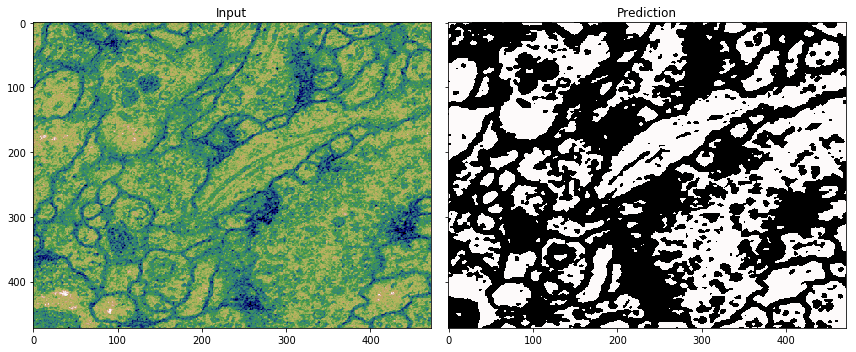

In [62]:
pruebas_isbi_2012.test(model_isbi_2012, data_provider_isbi_2012_test, TRAINED_FOLDER_ISBI_2012, True)

### Cell Tracking Challenge 
- http://www.celltrackingchallenge.net/datasets.html
- Solo existe una imagen sin máscara
- Se necesitan buscar reemplazos de ambos conjuntos

PhC-U373 - PhC-C2DH-U373
- Glioblastoma-astrocytoma U373 cells on a polyacrylimide substrate  (2D)
- Dr. Sanjay Kumar. Department of Bioengineering
- University of California at Berkeley. Berkeley CA (USA)
- Microscope: Nikon
- Objective lens: Plan Fluor DLL 20X/0.5
- Pixel size (microns): 0.65 x 0.65
- Time step (min): 15

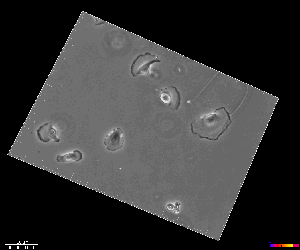

In [47]:
img = Image.open("img/PhC-C2DH-U373.gif")
img = img.resize((300, 250), Image.ANTIALIAS)
img

DIC-HeLA - Fluo-N2DL-HeLa
- HeLa cells stably expressing H2b-GFP (2D)
- Mitocheck Consortium
- Microscope: Olympus IX81
- Objective lens: Plan 10x/0.4
- Pixel size (microns): 0.645 x 0.645
- Time step (min): 30

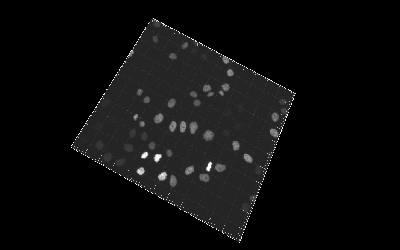

In [48]:
img = Image.open("img/N2DL-HeLa.gif")
img = img.resize((400, 250), Image.ANTIALIAS)
img

### Broad Bioimage Benchmark Collection (BBBC003)
- Embriones de ratones.
- Modo de toma: Fluor
- https://data.broadinstitute.org/bbbc/BBBC003/
- Existen diferentes conjuntos de datos
- Todas las imágenes deben tener la misma orientación (horizontal o vertical). Se modificaron manualmente.

In [75]:
PATH_BROAD_003_TRAIN = "dataset/broad-bioimage/BBBC003/train/"
PATH_BROAD_003_TEST = "dataset/broad-bioimage/BBBC003/test/"
TRAINED_FOLDER_BROAD_003 = "unet_trained_broad_003"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_BROAD_003_MODEL = False 

Train

In [83]:
data_provider_broad_003_train = ImageDataProvider(PATH_BROAD_003_TRAIN + "*.tif")

Number of files used: 11


In [84]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_broad_003 = Pruebas();

Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0
Ids reiniciados


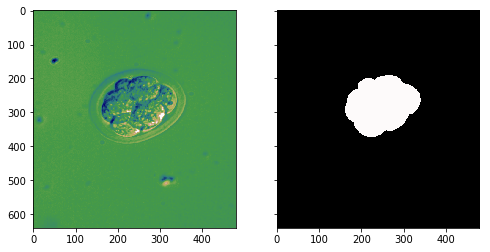

2018-09-27 18:18:27,622 Layers 3, features 16, filter size 3x3, pool size: 2x2
2018-09-27 18:18:28,633 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_broad_003'
2018-09-27 18:18:28,635 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained_broad_003'
2018-09-27 18:18:28,636 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_broad_003'


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:18:34,387 Verification error= 9.0%, loss= 0.6837
2018-09-27 18:18:34,927 Start optimization


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:18:39,304 Iter 0, Minibatch Loss= 0.5902, Training Accuracy= 0.8920, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:18:46,569 Iter 2, Minibatch Loss= 0.4499, Training Accuracy= 0.9010, Minibatch error= 9.9%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:18:53,315 Iter 4, Minibatch Loss= 0.3041, Training Accuracy= 0.9119, Minibatch error= 8.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:19:00,039 Iter 6, Minibatch Loss= 0.3254, Training Accuracy= 0.8986, Minibatch error= 10.1%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:19:06,789 Iter 8, Minibatch Loss= 0.2928, Training Accuracy= 0.9111, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:19:13,681 Iter 10, Minibatch Loss= 0.2905, Training Accuracy= 0.9130, Minibatch error= 8.7%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:19:20,231 Iter 12, Minibatch Loss= 0.3306, Training Accuracy= 0.8975, Minibatch error= 10.2%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:19:26,797 Iter 14, Minibatch Loss= 0.3806, Training Accuracy= 0.8714, Minibatch error= 12.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:19:33,438 Iter 16, Minibatch Loss= 0.3255, Training Accuracy= 0.8986, Minibatch error= 10.1%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:19:40,074 Iter 18, Minibatch Loss= 0.3255, Training Accuracy= 0.8986, Minibatch error= 10.1%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:19:46,713 Iter 20, Minibatch Loss= 0.2943, Training Accuracy= 0.9111, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:19:53,258 Iter 22, Minibatch Loss= 0.3305, Training Accuracy= 0.8975, Minibatch error= 10.2%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:19:59,936 Iter 24, Minibatch Loss= 0.3113, Training Accuracy= 0.9043, Minibatch error= 9.6%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:20:06,656 Iter 26, Minibatch Loss= 0.3366, Training Accuracy= 0.8920, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:20:13,429 Iter 28, Minibatch Loss= 0.2944, Training Accuracy= 0.9112, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:20:20,090 Iter 30, Minibatch Loss= 0.2946, Training Accuracy= 0.9112, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:20:23,055 Epoch 0, Average loss: 0.3631, learning rate: 0.2000
2018-09-27 18:20:28,555 Verification error= 9.0%, loss= 0.2964


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:20:32,956 Iter 32, Minibatch Loss= 0.3803, Training Accuracy= 0.8714, Minibatch error= 12.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:20:39,685 Iter 34, Minibatch Loss= 0.3106, Training Accuracy= 0.9043, Minibatch error= 9.6%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:20:46,430 Iter 36, Minibatch Loss= 0.3251, Training Accuracy= 0.8986, Minibatch error= 10.1%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:20:53,249 Iter 38, Minibatch Loss= 0.2921, Training Accuracy= 0.9119, Minibatch error= 8.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:21:00,392 Iter 40, Minibatch Loss= 0.3108, Training Accuracy= 0.9043, Minibatch error= 9.6%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:21:07,305 Iter 42, Minibatch Loss= 0.3801, Training Accuracy= 0.8714, Minibatch error= 12.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:21:14,179 Iter 44, Minibatch Loss= 0.3304, Training Accuracy= 0.8975, Minibatch error= 10.2%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:21:21,513 Iter 46, Minibatch Loss= 0.3167, Training Accuracy= 0.9010, Minibatch error= 9.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:21:28,412 Iter 48, Minibatch Loss= 0.3359, Training Accuracy= 0.8920, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:21:35,041 Iter 50, Minibatch Loss= 0.2934, Training Accuracy= 0.9112, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:21:41,651 Iter 52, Minibatch Loss= 0.3798, Training Accuracy= 0.8714, Minibatch error= 12.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:21:48,583 Iter 54, Minibatch Loss= 0.3303, Training Accuracy= 0.8975, Minibatch error= 10.2%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:21:55,309 Iter 56, Minibatch Loss= 0.3244, Training Accuracy= 0.8986, Minibatch error= 10.1%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:22:02,252 Iter 58, Minibatch Loss= 0.2883, Training Accuracy= 0.9130, Minibatch error= 8.7%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:22:08,986 Iter 60, Minibatch Loss= 0.3352, Training Accuracy= 0.8920, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:22:15,728 Iter 62, Minibatch Loss= 0.2934, Training Accuracy= 0.9112, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:22:18,731 Epoch 1, Average loss: 0.3298, learning rate: 0.1900
2018-09-27 18:22:24,134 Verification error= 9.0%, loss= 0.2963


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:22:28,493 Iter 64, Minibatch Loss= 0.2900, Training Accuracy= 0.9111, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:22:35,227 Iter 66, Minibatch Loss= 0.3239, Training Accuracy= 0.8986, Minibatch error= 10.1%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:22:42,096 Iter 68, Minibatch Loss= 0.3794, Training Accuracy= 0.8714, Minibatch error= 12.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:22:49,143 Iter 70, Minibatch Loss= 0.3151, Training Accuracy= 0.9010, Minibatch error= 9.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:22:56,144 Iter 72, Minibatch Loss= 0.3295, Training Accuracy= 0.8975, Minibatch error= 10.2%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:23:03,383 Iter 74, Minibatch Loss= 0.3086, Training Accuracy= 0.9043, Minibatch error= 9.6%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:23:10,607 Iter 76, Minibatch Loss= 0.3305, Training Accuracy= 0.8925, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:23:17,370 Iter 78, Minibatch Loss= 0.2893, Training Accuracy= 0.9111, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:23:23,973 Iter 80, Minibatch Loss= 0.2939, Training Accuracy= 0.9112, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:23:30,771 Iter 82, Minibatch Loss= 0.2871, Training Accuracy= 0.9130, Minibatch error= 8.7%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:23:37,500 Iter 84, Minibatch Loss= 0.2864, Training Accuracy= 0.9130, Minibatch error= 8.7%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:23:44,140 Iter 86, Minibatch Loss= 0.3298, Training Accuracy= 0.8925, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:23:50,751 Iter 88, Minibatch Loss= 0.3225, Training Accuracy= 0.8986, Minibatch error= 10.1%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:23:57,398 Iter 90, Minibatch Loss= 0.3071, Training Accuracy= 0.9043, Minibatch error= 9.6%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:24:04,326 Iter 92, Minibatch Loss= 0.2892, Training Accuracy= 0.9119, Minibatch error= 8.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:24:11,082 Iter 94, Minibatch Loss= 0.3780, Training Accuracy= 0.8714, Minibatch error= 12.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:24:13,967 Epoch 2, Average loss: 0.3265, learning rate: 0.1805
2018-09-27 18:24:19,614 Verification error= 9.0%, loss= 0.2990


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:24:24,023 Iter 96, Minibatch Loss= 0.3289, Training Accuracy= 0.8925, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:24:30,687 Iter 98, Minibatch Loss= 0.3326, Training Accuracy= 0.8920, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:24:37,271 Iter 100, Minibatch Loss= 0.2902, Training Accuracy= 0.9112, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:24:43,977 Iter 102, Minibatch Loss= 0.3142, Training Accuracy= 0.9010, Minibatch error= 9.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:24:50,717 Iter 104, Minibatch Loss= 0.2864, Training Accuracy= 0.9111, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:24:57,371 Iter 106, Minibatch Loss= 0.3283, Training Accuracy= 0.8975, Minibatch error= 10.2%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:25:04,122 Iter 108, Minibatch Loss= 0.2898, Training Accuracy= 0.9112, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:25:10,806 Iter 110, Minibatch Loss= 0.3267, Training Accuracy= 0.8925, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:25:17,517 Iter 112, Minibatch Loss= 0.3049, Training Accuracy= 0.9043, Minibatch error= 9.6%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:25:24,125 Iter 114, Minibatch Loss= 0.3308, Training Accuracy= 0.8920, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:25:30,962 Iter 116, Minibatch Loss= 0.3761, Training Accuracy= 0.8714, Minibatch error= 12.9%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:25:37,820 Iter 118, Minibatch Loss= 0.2891, Training Accuracy= 0.9119, Minibatch error= 8.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:25:44,843 Iter 120, Minibatch Loss= 0.3250, Training Accuracy= 0.8925, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:25:51,796 Iter 122, Minibatch Loss= 0.3298, Training Accuracy= 0.8920, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:25:58,614 Iter 124, Minibatch Loss= 0.2822, Training Accuracy= 0.9130, Minibatch error= 8.7%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:26:05,453 Iter 126, Minibatch Loss= 0.3191, Training Accuracy= 0.8986, Minibatch error= 10.1%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:26:08,579 Epoch 3, Average loss: 0.3221, learning rate: 0.1715
2018-09-27 18:26:14,377 Verification error= 9.0%, loss= 0.2886


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:26:18,868 Iter 128, Minibatch Loss= 0.3234, Training Accuracy= 0.8925, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:26:25,928 Iter 130, Minibatch Loss= 0.3088, Training Accuracy= 0.9010, Minibatch error= 9.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:26:33,350 Iter 132, Minibatch Loss= 0.3179, Training Accuracy= 0.8986, Minibatch error= 10.1%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:26:40,499 Iter 134, Minibatch Loss= 0.2852, Training Accuracy= 0.9112, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:26:47,556 Iter 136, Minibatch Loss= 0.3736, Training Accuracy= 0.8714, Minibatch error= 12.9%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:26:54,734 Iter 138, Minibatch Loss= 0.2837, Training Accuracy= 0.9119, Minibatch error= 8.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:27:01,986 Iter 140, Minibatch Loss= 0.2816, Training Accuracy= 0.9119, Minibatch error= 8.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:27:09,095 Iter 142, Minibatch Loss= 0.3730, Training Accuracy= 0.8714, Minibatch error= 12.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:27:16,492 Iter 144, Minibatch Loss= 0.3253, Training Accuracy= 0.8920, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:27:23,536 Iter 146, Minibatch Loss= 0.2832, Training Accuracy= 0.9112, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:27:30,798 Iter 148, Minibatch Loss= 0.2770, Training Accuracy= 0.9130, Minibatch error= 8.7%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:27:38,148 Iter 150, Minibatch Loss= 0.3044, Training Accuracy= 0.9010, Minibatch error= 9.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:27:45,051 Iter 152, Minibatch Loss= 0.2787, Training Accuracy= 0.9119, Minibatch error= 8.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:27:51,758 Iter 154, Minibatch Loss= 0.2964, Training Accuracy= 0.9043, Minibatch error= 9.6%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:27:58,645 Iter 156, Minibatch Loss= 0.3217, Training Accuracy= 0.8920, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:28:05,410 Iter 158, Minibatch Loss= 0.2827, Training Accuracy= 0.9112, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:28:08,295 Epoch 4, Average loss: 0.3179, learning rate: 0.1629
2018-09-27 18:28:13,679 Verification error= 9.0%, loss= 0.2837


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:28:18,017 Iter 160, Minibatch Loss= 0.2736, Training Accuracy= 0.9130, Minibatch error= 8.7%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:28:24,613 Iter 162, Minibatch Loss= 0.2940, Training Accuracy= 0.9043, Minibatch error= 9.6%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:28:31,773 Iter 164, Minibatch Loss= 0.3112, Training Accuracy= 0.8986, Minibatch error= 10.1%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:28:39,047 Iter 166, Minibatch Loss= 0.2753, Training Accuracy= 0.9119, Minibatch error= 8.8%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:28:46,051 Iter 168, Minibatch Loss= 0.2707, Training Accuracy= 0.9111, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:28:52,999 Iter 170, Minibatch Loss= 0.3682, Training Accuracy= 0.8714, Minibatch error= 12.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:28:59,790 Iter 172, Minibatch Loss= 0.3020, Training Accuracy= 0.9010, Minibatch error= 9.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:29:07,072 Iter 174, Minibatch Loss= 0.2691, Training Accuracy= 0.9130, Minibatch error= 8.7%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:29:13,807 Iter 176, Minibatch Loss= 0.3103, Training Accuracy= 0.8986, Minibatch error= 10.1%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:29:20,632 Iter 178, Minibatch Loss= 0.3078, Training Accuracy= 0.8925, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:29:27,329 Iter 180, Minibatch Loss= 0.3152, Training Accuracy= 0.8920, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:29:34,551 Iter 182, Minibatch Loss= 0.2728, Training Accuracy= 0.9119, Minibatch error= 8.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:29:41,345 Iter 184, Minibatch Loss= 0.3052, Training Accuracy= 0.8925, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:29:47,944 Iter 186, Minibatch Loss= 0.2636, Training Accuracy= 0.9111, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:29:55,325 Iter 188, Minibatch Loss= 0.3167, Training Accuracy= 0.8975, Minibatch error= 10.2%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:30:02,043 Iter 190, Minibatch Loss= 0.3109, Training Accuracy= 0.8920, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:30:04,993 Epoch 5, Average loss: 0.3113, learning rate: 0.1548
2018-09-27 18:30:10,552 Verification error= 9.0%, loss= 0.2947


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:30:15,139 Iter 192, Minibatch Loss= 0.2978, Training Accuracy= 0.9010, Minibatch error= 9.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:30:21,816 Iter 194, Minibatch Loss= 0.2623, Training Accuracy= 0.9130, Minibatch error= 8.7%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:30:28,749 Iter 196, Minibatch Loss= 0.2750, Training Accuracy= 0.9112, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:30:35,825 Iter 198, Minibatch Loss= 0.3022, Training Accuracy= 0.8986, Minibatch error= 10.1%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:30:42,608 Iter 200, Minibatch Loss= 0.2633, Training Accuracy= 0.9111, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:30:49,307 Iter 202, Minibatch Loss= 0.3151, Training Accuracy= 0.8975, Minibatch error= 10.2%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:30:56,141 Iter 204, Minibatch Loss= 0.3153, Training Accuracy= 0.8920, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:31:03,472 Iter 206, Minibatch Loss= 0.3131, Training Accuracy= 0.8975, Minibatch error= 10.2%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:31:10,146 Iter 208, Minibatch Loss= 0.2840, Training Accuracy= 0.9043, Minibatch error= 9.6%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:31:16,903 Iter 210, Minibatch Loss= 0.2990, Training Accuracy= 0.8925, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:31:23,537 Iter 212, Minibatch Loss= 0.2568, Training Accuracy= 0.9130, Minibatch error= 8.7%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:31:30,037 Iter 214, Minibatch Loss= 0.3049, Training Accuracy= 0.8920, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:31:36,651 Iter 216, Minibatch Loss= 0.3192, Training Accuracy= 0.8975, Minibatch error= 10.2%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:31:43,206 Iter 218, Minibatch Loss= 0.2981, Training Accuracy= 0.8925, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:31:49,843 Iter 220, Minibatch Loss= 0.2703, Training Accuracy= 0.9112, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:31:56,589 Iter 222, Minibatch Loss= 0.3044, Training Accuracy= 0.8920, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:31:59,471 Epoch 6, Average loss: 0.3078, learning rate: 0.1470
2018-09-27 18:32:04,928 Verification error= 9.0%, loss= 0.2625


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:32:09,663 Iter 224, Minibatch Loss= 0.2544, Training Accuracy= 0.9130, Minibatch error= 8.7%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:32:16,496 Iter 226, Minibatch Loss= 0.2824, Training Accuracy= 0.9010, Minibatch error= 9.9%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:32:23,215 Iter 228, Minibatch Loss= 0.2470, Training Accuracy= 0.9111, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:32:29,894 Iter 230, Minibatch Loss= 0.3216, Training Accuracy= 0.8975, Minibatch error= 10.2%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:32:36,567 Iter 232, Minibatch Loss= 0.2902, Training Accuracy= 0.9010, Minibatch error= 9.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:32:43,306 Iter 234, Minibatch Loss= 0.2548, Training Accuracy= 0.9112, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:32:50,043 Iter 236, Minibatch Loss= 0.2584, Training Accuracy= 0.9119, Minibatch error= 8.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:32:56,766 Iter 238, Minibatch Loss= 0.2438, Training Accuracy= 0.9111, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:33:03,585 Iter 240, Minibatch Loss= 0.2749, Training Accuracy= 0.9043, Minibatch error= 9.6%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:33:10,431 Iter 242, Minibatch Loss= 0.2466, Training Accuracy= 0.9130, Minibatch error= 8.7%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:33:17,202 Iter 244, Minibatch Loss= 0.2967, Training Accuracy= 0.8986, Minibatch error= 10.1%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:33:24,013 Iter 246, Minibatch Loss= 0.2518, Training Accuracy= 0.9112, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:33:30,830 Iter 248, Minibatch Loss= 0.3403, Training Accuracy= 0.8920, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:33:37,640 Iter 250, Minibatch Loss= 0.3023, Training Accuracy= 0.8986, Minibatch error= 10.1%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:33:44,726 Iter 252, Minibatch Loss= 0.2871, Training Accuracy= 0.9010, Minibatch error= 9.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:33:51,425 Iter 254, Minibatch Loss= 0.2775, Training Accuracy= 0.8925, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:33:54,282 Epoch 7, Average loss: 0.2962, learning rate: 0.1397
2018-09-27 18:33:59,788 Verification error= 9.0%, loss= 0.2651


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:34:04,217 Iter 256, Minibatch Loss= 0.2721, Training Accuracy= 0.9043, Minibatch error= 9.6%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:34:10,968 Iter 258, Minibatch Loss= 0.2976, Training Accuracy= 0.8975, Minibatch error= 10.2%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:34:17,710 Iter 260, Minibatch Loss= 0.2520, Training Accuracy= 0.9119, Minibatch error= 8.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:34:24,322 Iter 262, Minibatch Loss= 0.2947, Training Accuracy= 0.8975, Minibatch error= 10.2%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:34:30,973 Iter 264, Minibatch Loss= 0.2652, Training Accuracy= 0.9043, Minibatch error= 9.6%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:34:37,677 Iter 266, Minibatch Loss= 0.2733, Training Accuracy= 0.8925, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:34:44,348 Iter 268, Minibatch Loss= 0.3430, Training Accuracy= 0.8714, Minibatch error= 12.9%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:34:51,011 Iter 270, Minibatch Loss= 0.2527, Training Accuracy= 0.9111, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:34:57,711 Iter 272, Minibatch Loss= 0.2762, Training Accuracy= 0.8925, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:35:04,452 Iter 274, Minibatch Loss= 0.2778, Training Accuracy= 0.8986, Minibatch error= 10.1%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:35:11,238 Iter 276, Minibatch Loss= 0.2734, Training Accuracy= 0.9043, Minibatch error= 9.6%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:35:18,026 Iter 278, Minibatch Loss= 0.2464, Training Accuracy= 0.9111, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:35:24,694 Iter 280, Minibatch Loss= 0.2899, Training Accuracy= 0.8920, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:35:31,320 Iter 282, Minibatch Loss= 0.3015, Training Accuracy= 0.8975, Minibatch error= 10.2%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:35:37,973 Iter 284, Minibatch Loss= 0.3437, Training Accuracy= 0.8714, Minibatch error= 12.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:35:45,205 Iter 286, Minibatch Loss= 0.2644, Training Accuracy= 0.9043, Minibatch error= 9.6%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:35:48,241 Epoch 8, Average loss: 0.2971, learning rate: 0.1327
2018-09-27 18:35:54,128 Verification error= 9.0%, loss= 0.2507


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:35:58,502 Iter 288, Minibatch Loss= 0.2819, Training Accuracy= 0.8986, Minibatch error= 10.1%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:36:05,193 Iter 290, Minibatch Loss= 0.2342, Training Accuracy= 0.9130, Minibatch error= 8.7%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:36:11,874 Iter 292, Minibatch Loss= 0.2456, Training Accuracy= 0.9119, Minibatch error= 8.8%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:36:18,517 Iter 294, Minibatch Loss= 0.2749, Training Accuracy= 0.8986, Minibatch error= 10.1%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:36:25,256 Iter 296, Minibatch Loss= 0.2621, Training Accuracy= 0.8925, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:36:31,944 Iter 298, Minibatch Loss= 0.3334, Training Accuracy= 0.8714, Minibatch error= 12.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:36:38,723 Iter 300, Minibatch Loss= 0.2575, Training Accuracy= 0.9043, Minibatch error= 9.6%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:36:45,294 Iter 302, Minibatch Loss= 0.2240, Training Accuracy= 0.9130, Minibatch error= 8.7%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:36:52,059 Iter 304, Minibatch Loss= 0.2516, Training Accuracy= 0.8925, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E13.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:36:59,040 Iter 306, Minibatch Loss= 0.3716, Training Accuracy= 0.9010, Minibatch error= 9.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E8.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:37:05,900 Iter 308, Minibatch Loss= 0.2776, Training Accuracy= 0.9119, Minibatch error= 8.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E4.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:37:12,534 Iter 310, Minibatch Loss= 0.3122, Training Accuracy= 0.8986, Minibatch error= 10.1%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E6.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:37:19,247 Iter 312, Minibatch Loss= 0.3256, Training Accuracy= 0.8920, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E4.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:37:26,086 Iter 314, Minibatch Loss= 0.2790, Training Accuracy= 0.9112, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E3.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:37:32,715 Iter 316, Minibatch Loss= 0.2775, Training Accuracy= 0.9112, Minibatch error= 8.9%


Image name dataset/broad-bioimage/BBBC003/train\7_20_M3M10.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC003/train\7_19_M2E6.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:37:39,332 Iter 318, Minibatch Loss= 0.3093, Training Accuracy= 0.8925, Minibatch error= 10.8%


Image name dataset/broad-bioimage/BBBC003/train\7_19_M1E18.tif - Frame Id: 0 - #Frame: 0


2018-09-27 18:37:42,179 Epoch 9, Average loss: 0.2960, learning rate: 0.1260
2018-09-27 18:37:47,662 Verification error= 9.0%, loss= 0.2722
2018-09-27 18:37:48,286 Optimization Finished!


In [85]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_broad_005
#########################
model_broad_003 = pruebas_broad_003.train(data_provider_broad_003_train, 
                                          TRAINED_FOLDER_BROAD_003, 
                                          32, #iterations
                                          10, #epoch
                                          1, #batch size 
                                          ENTRENAR_BROAD_003_MODEL)

Test

In [86]:
data_provider_broad_003_test = ImageDataProvider(PATH_BROAD_003_TEST + "*.tif")

Number of files used: 4


Image name dataset/broad-bioimage/BBBC003/test\7_19_M2E5.tif - Frame Id: 0 - #Frame: 0
INFO:tensorflow:Restoring parameters from ./unet_trained_broad_003/model.ckpt


2018-09-27 18:37:48,549 Restoring parameters from ./unet_trained_broad_003/model.ckpt
2018-09-27 18:37:48,612 Model restored from file: ./unet_trained_broad_003/model.ckpt


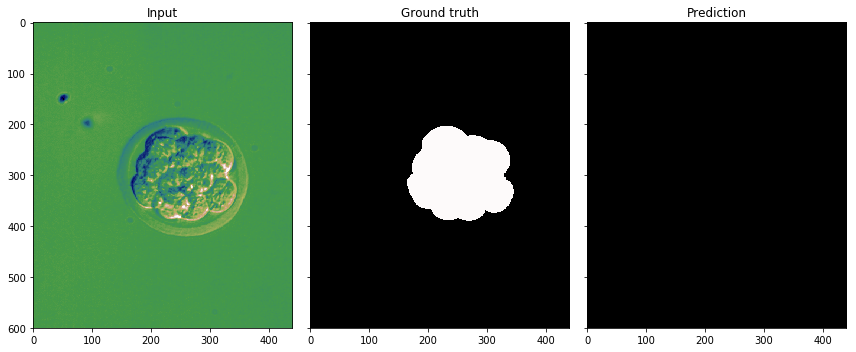

In [87]:
pruebas_broad_003.test(model_broad_003, data_provider_broad_003_test, TRAINED_FOLDER_BROAD_003, False)

### Broad Bioimage Benchmark Collection (BBBC005)
- https://data.broadinstitute.org/bbbc/image_sets.html
- Existen diferentes conjuntos de datos

In [69]:
PATH_BROAD_005_TRAIN = "dataset/broad-bioimage/BBBC005/train/"
PATH_BROAD_005_TEST = "dataset/broad-bioimage/BBBC005/test/"
TRAINED_FOLDER_BROAD_005 = "unet_trained_broad_005"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_BROAD_005_MODEL = False 

Train

In [64]:
data_provider_broad_005_train = ImageDataProvider(PATH_BROAD_005_TRAIN + "*.tif")

Number of files used: 28


In [65]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_broad_005 = Pruebas();

Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s03_w2.tif - Frame Id: 0 - #Frame: 0
Ids reiniciados


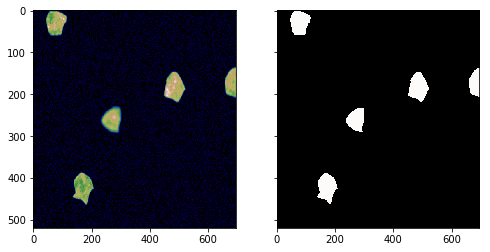

2018-09-27 17:16:24,741 Layers 3, features 16, filter size 3x3, pool size: 2x2
2018-09-27 17:16:25,988 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_broad_005'
2018-09-27 17:16:25,996 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained_broad_005'
2018-09-27 17:16:26,001 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_broad_005'


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s03_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:16:33,045 Verification error= 3.5%, loss= 0.6766
2018-09-27 17:16:33,656 Start optimization


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:16:38,727 Iter 0, Minibatch Loss= 0.5677, Training Accuracy= 0.9557, Minibatch error= 4.4%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:16:46,841 Iter 2, Minibatch Loss= 0.3653, Training Accuracy= 0.9875, Minibatch error= 1.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:16:55,022 Iter 4, Minibatch Loss= 0.2054, Training Accuracy= 0.9602, Minibatch error= 4.0%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:17:02,996 Iter 6, Minibatch Loss= 0.1617, Training Accuracy= 0.9583, Minibatch error= 4.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:17:10,786 Iter 8, Minibatch Loss= 0.0613, Training Accuracy= 0.9876, Minibatch error= 1.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:17:18,664 Iter 10, Minibatch Loss= 0.0495, Training Accuracy= 0.9879, Minibatch error= 1.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:17:26,643 Iter 12, Minibatch Loss= 0.0913, Training Accuracy= 0.9606, Minibatch error= 3.9%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:17:34,505 Iter 14, Minibatch Loss= 0.0341, Training Accuracy= 0.9879, Minibatch error= 1.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:17:42,545 Iter 16, Minibatch Loss= 0.0280, Training Accuracy= 0.9899, Minibatch error= 1.0%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:17:50,643 Iter 18, Minibatch Loss= 0.0720, Training Accuracy= 0.9562, Minibatch error= 4.4%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s17_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:17:58,808 Iter 20, Minibatch Loss= 0.0252, Training Accuracy= 0.9869, Minibatch error= 1.3%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:18:06,751 Iter 22, Minibatch Loss= 0.0587, Training Accuracy= 0.9522, Minibatch error= 4.8%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:18:14,876 Iter 24, Minibatch Loss= 0.0185, Training Accuracy= 0.9874, Minibatch error= 1.3%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:18:23,024 Iter 26, Minibatch Loss= 0.0176, Training Accuracy= 0.9878, Minibatch error= 1.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:18:30,921 Iter 28, Minibatch Loss= 0.0555, Training Accuracy= 0.9506, Minibatch error= 4.9%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:18:38,878 Iter 30, Minibatch Loss= 0.0167, Training Accuracy= 0.9877, Minibatch error= 1.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:18:42,372 Epoch 0, Average loss: 0.1418, learning rate: 0.2000
2018-09-27 17:18:48,830 Verification error= 3.5%, loss= 0.0388


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s03_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:18:53,867 Iter 32, Minibatch Loss= 0.0431, Training Accuracy= 0.9607, Minibatch error= 3.9%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:19:01,828 Iter 34, Minibatch Loss= 0.0128, Training Accuracy= 0.9899, Minibatch error= 1.0%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:19:09,578 Iter 36, Minibatch Loss= 0.0155, Training Accuracy= 0.9872, Minibatch error= 1.3%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:19:17,429 Iter 38, Minibatch Loss= 0.0139, Training Accuracy= 0.9879, Minibatch error= 1.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:19:25,407 Iter 40, Minibatch Loss= 0.0455, Training Accuracy= 0.9551, Minibatch error= 4.5%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:19:33,408 Iter 42, Minibatch Loss= 0.0447, Training Accuracy= 0.9551, Minibatch error= 4.5%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s17_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:19:41,379 Iter 44, Minibatch Loss= 0.0430, Training Accuracy= 0.9562, Minibatch error= 4.4%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:19:49,197 Iter 46, Minibatch Loss= 0.0130, Training Accuracy= 0.9875, Minibatch error= 1.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:19:56,932 Iter 48, Minibatch Loss= 0.0109, Training Accuracy= 0.9895, Minibatch error= 1.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:20:04,747 Iter 50, Minibatch Loss= 0.0400, Training Accuracy= 0.9583, Minibatch error= 4.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s17_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:20:12,823 Iter 52, Minibatch Loss= 0.0134, Training Accuracy= 0.9869, Minibatch error= 1.3%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:20:20,816 Iter 54, Minibatch Loss= 0.0383, Training Accuracy= 0.9583, Minibatch error= 4.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:20:28,666 Iter 56, Minibatch Loss= 0.0115, Training Accuracy= 0.9881, Minibatch error= 1.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:20:36,825 Iter 58, Minibatch Loss= 0.0099, Training Accuracy= 0.9895, Minibatch error= 1.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:20:44,571 Iter 60, Minibatch Loss= 0.0122, Training Accuracy= 0.9878, Minibatch error= 1.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:20:52,582 Iter 62, Minibatch Loss= 0.0362, Training Accuracy= 0.9583, Minibatch error= 4.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:20:56,043 Epoch 1, Average loss: 0.0333, learning rate: 0.1900
2018-09-27 17:21:02,490 Verification error= 3.5%, loss= 0.0294


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:21:07,786 Iter 64, Minibatch Loss= 0.0391, Training Accuracy= 0.9519, Minibatch error= 4.8%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s03_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:21:15,736 Iter 66, Minibatch Loss= 0.0311, Training Accuracy= 0.9607, Minibatch error= 3.9%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:21:23,665 Iter 68, Minibatch Loss= 0.0108, Training Accuracy= 0.9887, Minibatch error= 1.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:21:31,686 Iter 70, Minibatch Loss= 0.0369, Training Accuracy= 0.9763, Minibatch error= 2.4%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:21:39,593 Iter 72, Minibatch Loss= 0.0340, Training Accuracy= 0.9947, Minibatch error= 0.5%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:21:47,417 Iter 74, Minibatch Loss= 0.0263, Training Accuracy= 0.9976, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:21:55,853 Iter 76, Minibatch Loss= 0.0084, Training Accuracy= 0.9989, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:22:04,825 Iter 78, Minibatch Loss= 0.0092, Training Accuracy= 0.9987, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:22:12,820 Iter 80, Minibatch Loss= 0.0281, Training Accuracy= 0.9987, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:22:20,754 Iter 82, Minibatch Loss= 0.0240, Training Accuracy= 0.9988, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:22:28,721 Iter 84, Minibatch Loss= 0.0213, Training Accuracy= 0.9988, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:22:36,778 Iter 86, Minibatch Loss= 0.0078, Training Accuracy= 0.9988, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:22:44,704 Iter 88, Minibatch Loss= 0.0213, Training Accuracy= 0.9989, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:22:52,847 Iter 90, Minibatch Loss= 0.0208, Training Accuracy= 0.9988, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:23:01,121 Iter 92, Minibatch Loss= 0.0057, Training Accuracy= 0.9992, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:23:09,140 Iter 94, Minibatch Loss= 0.0215, Training Accuracy= 0.9981, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s03_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:23:12,525 Epoch 2, Average loss: 0.0219, learning rate: 0.1805
2018-09-27 17:23:19,480 Verification error= 0.1%, loss= 0.0149


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:23:24,934 Iter 96, Minibatch Loss= 0.0201, Training Accuracy= 0.9988, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:23:32,624 Iter 98, Minibatch Loss= 0.0058, Training Accuracy= 0.9991, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:23:40,564 Iter 100, Minibatch Loss= 0.0051, Training Accuracy= 0.9991, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s17_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:23:48,598 Iter 102, Minibatch Loss= 0.0165, Training Accuracy= 0.9973, Minibatch error= 0.3%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:23:56,548 Iter 104, Minibatch Loss= 0.0058, Training Accuracy= 0.9989, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:24:04,677 Iter 106, Minibatch Loss= 0.0158, Training Accuracy= 0.9980, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:24:13,167 Iter 108, Minibatch Loss= 0.0148, Training Accuracy= 0.9972, Minibatch error= 0.3%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:24:22,166 Iter 110, Minibatch Loss= 0.0119, Training Accuracy= 0.9986, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:24:31,099 Iter 112, Minibatch Loss= 0.0051, Training Accuracy= 0.9989, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:24:39,214 Iter 114, Minibatch Loss= 0.0040, Training Accuracy= 0.9991, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:24:47,614 Iter 116, Minibatch Loss= 0.0117, Training Accuracy= 0.9982, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:24:55,830 Iter 118, Minibatch Loss= 0.0116, Training Accuracy= 0.9978, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:25:04,374 Iter 120, Minibatch Loss= 0.0111, Training Accuracy= 0.9982, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:25:13,000 Iter 122, Minibatch Loss= 0.0039, Training Accuracy= 0.9990, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s17_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:25:21,627 Iter 124, Minibatch Loss= 0.0046, Training Accuracy= 0.9986, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:25:30,085 Iter 126, Minibatch Loss= 0.0089, Training Accuracy= 0.9983, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:25:33,585 Epoch 3, Average loss: 0.0109, learning rate: 0.1715
2018-09-27 17:25:40,285 Verification error= 0.2%, loss= 0.0078


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:25:45,611 Iter 128, Minibatch Loss= 0.0034, Training Accuracy= 0.9991, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:25:53,546 Iter 130, Minibatch Loss= 0.0102, Training Accuracy= 0.9975, Minibatch error= 0.3%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:26:02,245 Iter 132, Minibatch Loss= 0.0089, Training Accuracy= 0.9985, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:26:10,147 Iter 134, Minibatch Loss= 0.0031, Training Accuracy= 0.9992, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s03_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:26:18,564 Iter 136, Minibatch Loss= 0.0071, Training Accuracy= 0.9984, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:26:26,833 Iter 138, Minibatch Loss= 0.0075, Training Accuracy= 0.9982, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:26:35,303 Iter 140, Minibatch Loss= 0.0038, Training Accuracy= 0.9989, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:26:43,965 Iter 142, Minibatch Loss= 0.0040, Training Accuracy= 0.9987, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:26:51,939 Iter 144, Minibatch Loss= 0.0078, Training Accuracy= 0.9977, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:26:59,690 Iter 146, Minibatch Loss= 0.0030, Training Accuracy= 0.9990, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s17_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:27:07,445 Iter 148, Minibatch Loss= 0.0040, Training Accuracy= 0.9986, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s03_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:27:15,351 Iter 150, Minibatch Loss= 0.0079, Training Accuracy= 0.9975, Minibatch error= 0.3%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:27:23,153 Iter 152, Minibatch Loss= 0.0031, Training Accuracy= 0.9990, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:27:30,999 Iter 154, Minibatch Loss= 0.0066, Training Accuracy= 0.9982, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:27:39,461 Iter 156, Minibatch Loss= 0.0082, Training Accuracy= 0.9970, Minibatch error= 0.3%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:27:47,484 Iter 158, Minibatch Loss= 0.0068, Training Accuracy= 0.9980, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:27:50,945 Epoch 4, Average loss: 0.0079, learning rate: 0.1629
2018-09-27 17:27:57,388 Verification error= 0.2%, loss= 0.0056


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:28:02,362 Iter 160, Minibatch Loss= 0.0055, Training Accuracy= 0.9986, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:28:10,288 Iter 162, Minibatch Loss= 0.0027, Training Accuracy= 0.9990, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:28:18,414 Iter 164, Minibatch Loss= 0.0073, Training Accuracy= 0.9978, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s17_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:28:26,482 Iter 166, Minibatch Loss= 0.0038, Training Accuracy= 0.9986, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:28:34,638 Iter 168, Minibatch Loss= 0.0032, Training Accuracy= 0.9987, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:28:43,011 Iter 170, Minibatch Loss= 0.0054, Training Accuracy= 0.9984, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:28:51,265 Iter 172, Minibatch Loss= 0.0058, Training Accuracy= 0.9982, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:28:59,626 Iter 174, Minibatch Loss= 0.0030, Training Accuracy= 0.9990, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:29:07,675 Iter 176, Minibatch Loss= 0.0054, Training Accuracy= 0.9985, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s03_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:29:15,692 Iter 178, Minibatch Loss= 0.0067, Training Accuracy= 0.9976, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:29:23,637 Iter 180, Minibatch Loss= 0.0027, Training Accuracy= 0.9989, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:29:31,350 Iter 182, Minibatch Loss= 0.0053, Training Accuracy= 0.9984, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:29:39,176 Iter 184, Minibatch Loss= 0.0049, Training Accuracy= 0.9986, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:29:47,093 Iter 186, Minibatch Loss= 0.0060, Training Accuracy= 0.9979, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:29:55,029 Iter 188, Minibatch Loss= 0.0023, Training Accuracy= 0.9993, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:30:03,081 Iter 190, Minibatch Loss= 0.0074, Training Accuracy= 0.9970, Minibatch error= 0.3%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:30:06,606 Epoch 5, Average loss: 0.0067, learning rate: 0.1548
2018-09-27 17:30:13,290 Verification error= 0.2%, loss= 0.0050


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:30:18,392 Iter 192, Minibatch Loss= 0.0045, Training Accuracy= 0.9985, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:30:26,141 Iter 194, Minibatch Loss= 0.0028, Training Accuracy= 0.9989, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:30:34,261 Iter 196, Minibatch Loss= 0.0065, Training Accuracy= 0.9978, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:30:42,209 Iter 198, Minibatch Loss= 0.0055, Training Accuracy= 0.9981, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:30:50,243 Iter 200, Minibatch Loss= 0.0036, Training Accuracy= 0.9989, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:30:58,857 Iter 202, Minibatch Loss= 0.0022, Training Accuracy= 0.9993, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:31:06,957 Iter 204, Minibatch Loss= 0.0037, Training Accuracy= 0.9987, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:31:15,108 Iter 206, Minibatch Loss= 0.0065, Training Accuracy= 0.9975, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:31:23,261 Iter 208, Minibatch Loss= 0.0026, Training Accuracy= 0.9991, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s03_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:31:31,357 Iter 210, Minibatch Loss= 0.0032, Training Accuracy= 0.9991, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:31:39,490 Iter 212, Minibatch Loss= 0.0056, Training Accuracy= 0.9979, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:31:47,635 Iter 214, Minibatch Loss= 0.0045, Training Accuracy= 0.9985, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s17_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:31:55,828 Iter 216, Minibatch Loss= 0.0047, Training Accuracy= 0.9982, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:32:03,944 Iter 218, Minibatch Loss= 0.0029, Training Accuracy= 0.9990, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:32:12,397 Iter 220, Minibatch Loss= 0.0049, Training Accuracy= 0.9983, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:32:20,428 Iter 222, Minibatch Loss= 0.0022, Training Accuracy= 0.9992, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:32:23,888 Epoch 6, Average loss: 0.0064, learning rate: 0.1470
2018-09-27 17:32:30,537 Verification error= 0.2%, loss= 0.0047


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:32:35,684 Iter 224, Minibatch Loss= 0.0026, Training Accuracy= 0.9991, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:32:44,016 Iter 226, Minibatch Loss= 0.0069, Training Accuracy= 0.9972, Minibatch error= 0.3%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:32:52,341 Iter 228, Minibatch Loss= 0.0024, Training Accuracy= 0.9991, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:33:00,534 Iter 230, Minibatch Loss= 0.0029, Training Accuracy= 0.9990, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:33:08,519 Iter 232, Minibatch Loss= 0.0051, Training Accuracy= 0.9982, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:33:16,381 Iter 234, Minibatch Loss= 0.0030, Training Accuracy= 0.9990, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s03_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:33:24,583 Iter 236, Minibatch Loss= 0.0029, Training Accuracy= 0.9991, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:33:32,635 Iter 238, Minibatch Loss= 0.0043, Training Accuracy= 0.9986, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s17_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:33:40,743 Iter 240, Minibatch Loss= 0.0022, Training Accuracy= 0.9993, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:33:49,036 Iter 242, Minibatch Loss= 0.0060, Training Accuracy= 0.9976, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:33:57,466 Iter 244, Minibatch Loss= 0.0036, Training Accuracy= 0.9989, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:34:05,472 Iter 246, Minibatch Loss= 0.0043, Training Accuracy= 0.9984, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s17_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:34:13,406 Iter 248, Minibatch Loss= 0.0036, Training Accuracy= 0.9986, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:34:21,536 Iter 250, Minibatch Loss= 0.0069, Training Accuracy= 0.9972, Minibatch error= 0.3%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s03_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:34:29,518 Iter 252, Minibatch Loss= 0.0047, Training Accuracy= 0.9983, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:34:37,438 Iter 254, Minibatch Loss= 0.0044, Training Accuracy= 0.9985, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:34:40,828 Epoch 7, Average loss: 0.0062, learning rate: 0.1397
2018-09-27 17:34:47,293 Verification error= 0.2%, loss= 0.0046


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:34:52,449 Iter 256, Minibatch Loss= 0.0039, Training Accuracy= 0.9986, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:35:00,311 Iter 258, Minibatch Loss= 0.0031, Training Accuracy= 0.9988, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:35:08,380 Iter 260, Minibatch Loss= 0.0044, Training Accuracy= 0.9983, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:35:16,462 Iter 262, Minibatch Loss= 0.0025, Training Accuracy= 0.9991, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:35:24,306 Iter 264, Minibatch Loss= 0.0046, Training Accuracy= 0.9983, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:35:32,503 Iter 266, Minibatch Loss= 0.0017, Training Accuracy= 0.9994, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:35:40,706 Iter 268, Minibatch Loss= 0.0024, Training Accuracy= 0.9991, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:35:48,622 Iter 270, Minibatch Loss= 0.0029, Training Accuracy= 0.9990, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:35:56,685 Iter 272, Minibatch Loss= 0.0042, Training Accuracy= 0.9984, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:36:04,642 Iter 274, Minibatch Loss= 0.0039, Training Accuracy= 0.9987, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:36:12,632 Iter 276, Minibatch Loss= 0.0042, Training Accuracy= 0.9984, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:36:20,535 Iter 278, Minibatch Loss= 0.0052, Training Accuracy= 0.9981, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:36:28,591 Iter 280, Minibatch Loss= 0.0038, Training Accuracy= 0.9987, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:36:36,649 Iter 282, Minibatch Loss= 0.0026, Training Accuracy= 0.9990, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:36:44,766 Iter 284, Minibatch Loss= 0.0041, Training Accuracy= 0.9985, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:36:53,153 Iter 286, Minibatch Loss= 0.0017, Training Accuracy= 0.9994, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:36:56,769 Epoch 8, Average loss: 0.0058, learning rate: 0.1327
2018-09-27 17:37:03,439 Verification error= 0.2%, loss= 0.0045


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:37:08,579 Iter 288, Minibatch Loss= 0.0039, Training Accuracy= 0.9987, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:37:16,273 Iter 290, Minibatch Loss= 0.0025, Training Accuracy= 0.9990, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:37:24,421 Iter 292, Minibatch Loss= 0.0021, Training Accuracy= 0.9993, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s17_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:37:32,598 Iter 294, Minibatch Loss= 0.0045, Training Accuracy= 0.9984, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s11_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:37:40,757 Iter 296, Minibatch Loss= 0.0021, Training Accuracy= 0.9992, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:37:49,228 Iter 298, Minibatch Loss= 0.0033, Training Accuracy= 0.9987, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:37:57,313 Iter 300, Minibatch Loss= 0.0044, Training Accuracy= 0.9983, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:38:05,091 Iter 302, Minibatch Loss= 0.0029, Training Accuracy= 0.9990, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s03_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:38:12,892 Iter 304, Minibatch Loss= 0.0045, Training Accuracy= 0.9983, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s17_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s15_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:38:20,986 Iter 306, Minibatch Loss= 0.0035, Training Accuracy= 0.9989, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s04_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s08_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:38:29,212 Iter 308, Minibatch Loss= 0.0039, Training Accuracy= 0.9985, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s12_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s06_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:38:37,286 Iter 310, Minibatch Loss= 0.0027, Training Accuracy= 0.9990, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w2.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:38:45,097 Iter 312, Minibatch Loss= 0.0021, Training Accuracy= 0.9993, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s09_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s05_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:38:52,993 Iter 314, Minibatch Loss= 0.0055, Training Accuracy= 0.9979, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s14_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s16_w1.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:39:01,221 Iter 316, Minibatch Loss= 0.0021, Training Accuracy= 0.9992, Minibatch error= 0.1%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s13_w1.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s07_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:39:09,231 Iter 318, Minibatch Loss= 0.0048, Training Accuracy= 0.9980, Minibatch error= 0.2%


Image name dataset/broad-bioimage/BBBC005/train\SIMCEPImages_A02_C5_F1_s10_w2.tif - Frame Id: 0 - #Frame: 0


2018-09-27 17:39:12,693 Epoch 9, Average loss: 0.0055, learning rate: 0.1260
2018-09-27 17:39:19,274 Verification error= 0.2%, loss= 0.0047
2018-09-27 17:39:19,957 Optimization Finished!


In [66]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_broad_005
#########################
model_broad_005 = pruebas_broad_005.train(data_provider_broad_005_train, 
                                          TRAINED_FOLDER_BROAD_005, 
                                          32, #iterations
                                          10, #epoch
                                          1, #batch size 
                                          ENTRENAR_BROAD_005_MODEL)

Test

In [67]:
data_provider_broad_005_test = ImageDataProvider(PATH_BROAD_005_TEST + "*.tif")

Number of files used: 28


Image name dataset/broad-bioimage/BBBC005/test\SIMCEPImages_A03_C10_F1_s04_w1.tif - Frame Id: 0 - #Frame: 0
INFO:tensorflow:Restoring parameters from ./unet_trained_broad_005/model.ckpt


2018-09-27 17:39:20,187 Restoring parameters from ./unet_trained_broad_005/model.ckpt
2018-09-27 17:39:20,259 Model restored from file: ./unet_trained_broad_005/model.ckpt


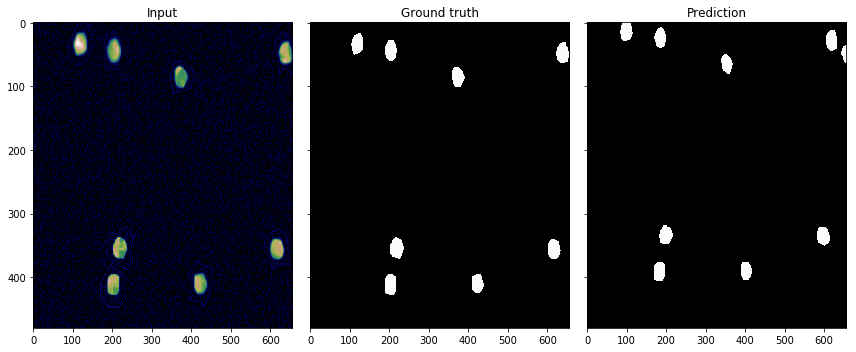

In [68]:
pruebas_broad_005.test(model_broad_005, data_provider_broad_005_test, TRAINED_FOLDER_BROAD_005, False)

### Broad Bioimage Benchmark Collection (BBBC009)
- https://data.broadinstitute.org/bbbc/BBBC009/
- Human red blood cells

In [123]:
PATH_BROAD_009_TRAIN = "dataset/broad-bioimage/BBBC009/train/"
PATH_BROAD_009_TEST = "dataset/broad-bioimage/BBBC009/test/"
TRAINED_FOLDER_BROAD_009 = "unet_trained_broad_009"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_BROAD_009_MODEL = False 

Train

In [106]:
data_provider_broad_009_train = ImageDataProvider(PATH_BROAD_009_TRAIN + "*.tif")

Number of files used: 3


In [107]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_broad_009 = Pruebas();

Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Ids reiniciados


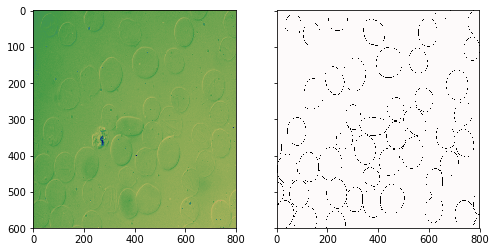

2018-09-27 19:09:44,613 Layers 3, features 16, filter size 3x3, pool size: 2x2
2018-09-27 19:09:45,637 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_broad_009'
2018-09-27 19:09:45,638 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained_broad_009'
2018-09-27 19:09:45,639 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_broad_009'
2018-09-27 19:09:45,640 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained_broad_009'


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:09:55,021 Verification error= 1.8%, loss= 0.6818
2018-09-27 19:09:55,834 Start optimization


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:10:02,658 Iter 0, Minibatch Loss= 0.5211, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:10:14,055 Iter 2, Minibatch Loss= 0.1682, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:10:24,608 Iter 4, Minibatch Loss= 0.0881, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:10:35,353 Iter 6, Minibatch Loss= 0.0887, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:10:46,203 Iter 8, Minibatch Loss= 0.0991, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:10:56,934 Iter 10, Minibatch Loss= 0.0882, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:11:08,587 Iter 12, Minibatch Loss= 0.0875, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:11:19,578 Iter 14, Minibatch Loss= 0.0990, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:11:30,119 Iter 16, Minibatch Loss= 0.0870, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:11:40,828 Iter 18, Minibatch Loss= 0.0865, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:11:51,705 Iter 20, Minibatch Loss= 0.0879, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:12:02,367 Iter 22, Minibatch Loss= 0.0866, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:12:13,051 Iter 24, Minibatch Loss= 0.0864, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:12:23,879 Iter 26, Minibatch Loss= 0.0994, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:12:34,613 Iter 28, Minibatch Loss= 0.0870, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:12:45,344 Iter 30, Minibatch Loss= 0.0882, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:12:49,970 Epoch 0, Average loss: 0.1527, learning rate: 0.2000
2018-09-27 19:12:58,883 Verification error= 1.8%, loss= 0.0908


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:13:05,923 Iter 32, Minibatch Loss= 0.0865, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:13:16,493 Iter 34, Minibatch Loss= 0.0993, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:13:27,107 Iter 36, Minibatch Loss= 0.0994, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:13:37,979 Iter 38, Minibatch Loss= 0.0864, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:13:48,772 Iter 40, Minibatch Loss= 0.0883, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:13:59,559 Iter 42, Minibatch Loss= 0.0996, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:14:10,324 Iter 44, Minibatch Loss= 0.0882, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:14:21,101 Iter 46, Minibatch Loss= 0.0864, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:14:31,764 Iter 48, Minibatch Loss= 0.0989, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:14:42,832 Iter 50, Minibatch Loss= 0.0879, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:14:53,448 Iter 52, Minibatch Loss= 0.0991, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:15:04,348 Iter 54, Minibatch Loss= 0.0992, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:15:14,816 Iter 56, Minibatch Loss= 0.0863, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:15:25,276 Iter 58, Minibatch Loss= 0.0883, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:15:35,827 Iter 60, Minibatch Loss= 0.0864, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:15:46,234 Iter 62, Minibatch Loss= 0.0879, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:15:50,692 Epoch 1, Average loss: 0.1036, learning rate: 0.1900
2018-09-27 19:15:59,364 Verification error= 1.8%, loss= 0.0907


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:16:06,112 Iter 64, Minibatch Loss= 0.0991, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:16:17,201 Iter 66, Minibatch Loss= 0.0883, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:16:29,095 Iter 68, Minibatch Loss= 0.0989, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:16:39,903 Iter 70, Minibatch Loss= 0.0883, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:16:50,995 Iter 72, Minibatch Loss= 0.0881, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:17:01,564 Iter 74, Minibatch Loss= 0.0864, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:17:11,910 Iter 76, Minibatch Loss= 0.0991, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:17:22,283 Iter 78, Minibatch Loss= 0.0883, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:17:32,641 Iter 80, Minibatch Loss= 0.0881, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:17:42,964 Iter 82, Minibatch Loss= 0.0863, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:17:53,197 Iter 84, Minibatch Loss= 0.0865, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:18:03,512 Iter 86, Minibatch Loss= 0.0882, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:18:13,860 Iter 88, Minibatch Loss= 0.0989, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:18:24,201 Iter 90, Minibatch Loss= 0.0990, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:18:34,554 Iter 92, Minibatch Loss= 0.0988, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:18:44,979 Iter 94, Minibatch Loss= 0.0883, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:18:49,453 Epoch 2, Average loss: 0.1026, learning rate: 0.1805
2018-09-27 19:18:57,996 Verification error= 1.8%, loss= 0.0906


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:19:05,043 Iter 96, Minibatch Loss= 0.0863, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:19:15,333 Iter 98, Minibatch Loss= 0.0880, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:19:25,701 Iter 100, Minibatch Loss= 0.0863, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:19:36,094 Iter 102, Minibatch Loss= 0.0882, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:19:46,494 Iter 104, Minibatch Loss= 0.0989, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:19:56,771 Iter 106, Minibatch Loss= 0.0864, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:20:07,197 Iter 108, Minibatch Loss= 0.0882, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:20:17,605 Iter 110, Minibatch Loss= 0.0989, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:20:27,901 Iter 112, Minibatch Loss= 0.0883, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:20:38,306 Iter 114, Minibatch Loss= 0.0862, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:20:48,582 Iter 116, Minibatch Loss= 0.0990, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:20:59,200 Iter 118, Minibatch Loss= 0.0882, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:21:10,280 Iter 120, Minibatch Loss= 0.0862, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:21:20,574 Iter 122, Minibatch Loss= 0.0990, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:21:31,007 Iter 124, Minibatch Loss= 0.0864, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:21:41,307 Iter 126, Minibatch Loss= 0.0862, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:21:45,793 Epoch 3, Average loss: 0.1007, learning rate: 0.1715
2018-09-27 19:21:54,358 Verification error= 1.8%, loss= 0.0905


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:22:01,002 Iter 128, Minibatch Loss= 0.0864, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:22:11,351 Iter 130, Minibatch Loss= 0.0882, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:22:21,746 Iter 132, Minibatch Loss= 0.0866, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:22:32,020 Iter 134, Minibatch Loss= 0.0862, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:22:42,327 Iter 136, Minibatch Loss= 0.0883, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:22:52,621 Iter 138, Minibatch Loss= 0.0865, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:23:03,066 Iter 140, Minibatch Loss= 0.0988, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:23:13,740 Iter 142, Minibatch Loss= 0.0883, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:23:24,678 Iter 144, Minibatch Loss= 0.0881, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:23:35,431 Iter 146, Minibatch Loss= 0.0988, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:23:46,267 Iter 148, Minibatch Loss= 0.0883, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:23:56,923 Iter 150, Minibatch Loss= 0.0865, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:24:07,882 Iter 152, Minibatch Loss= 0.0862, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:24:18,696 Iter 154, Minibatch Loss= 0.0883, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:24:29,622 Iter 156, Minibatch Loss= 0.0862, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:24:40,714 Iter 158, Minibatch Loss= 0.0989, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:24:45,513 Epoch 4, Average loss: 0.1000, learning rate: 0.1629
2018-09-27 19:24:54,138 Verification error= 1.8%, loss= 0.0905


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:25:00,970 Iter 160, Minibatch Loss= 0.0882, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:25:11,480 Iter 162, Minibatch Loss= 0.0865, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:25:22,628 Iter 164, Minibatch Loss= 0.0988, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:25:33,634 Iter 166, Minibatch Loss= 0.0883, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:25:44,251 Iter 168, Minibatch Loss= 0.0991, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:25:55,125 Iter 170, Minibatch Loss= 0.0881, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:26:05,598 Iter 172, Minibatch Loss= 0.0988, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:26:16,113 Iter 174, Minibatch Loss= 0.0883, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:26:26,588 Iter 176, Minibatch Loss= 0.0988, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:26:37,182 Iter 178, Minibatch Loss= 0.0863, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:26:47,654 Iter 180, Minibatch Loss= 0.0882, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:26:58,427 Iter 182, Minibatch Loss= 0.0862, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:27:09,641 Iter 184, Minibatch Loss= 0.0883, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:27:20,734 Iter 186, Minibatch Loss= 0.0988, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:27:31,499 Iter 188, Minibatch Loss= 0.0862, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:27:42,077 Iter 190, Minibatch Loss= 0.0989, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:27:46,754 Epoch 5, Average loss: 0.0987, learning rate: 0.1548
2018-09-27 19:27:55,508 Verification error= 1.8%, loss= 0.0904


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:28:02,231 Iter 192, Minibatch Loss= 0.0989, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:28:12,961 Iter 194, Minibatch Loss= 0.0882, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:28:23,755 Iter 196, Minibatch Loss= 0.0988, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:28:34,864 Iter 198, Minibatch Loss= 0.0883, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:28:45,141 Iter 200, Minibatch Loss= 0.0862, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:28:55,623 Iter 202, Minibatch Loss= 0.0989, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:29:07,215 Iter 204, Minibatch Loss= 0.0861, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:29:18,484 Iter 206, Minibatch Loss= 0.0880, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:29:29,051 Iter 208, Minibatch Loss= 0.0988, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:29:39,743 Iter 210, Minibatch Loss= 0.0883, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:29:50,749 Iter 212, Minibatch Loss= 0.0862, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:30:02,133 Iter 214, Minibatch Loss= 0.0989, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:30:12,997 Iter 216, Minibatch Loss= 0.0862, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:30:23,776 Iter 218, Minibatch Loss= 0.0987, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:30:35,876 Iter 220, Minibatch Loss= 0.0862, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:30:47,488 Iter 222, Minibatch Loss= 0.0882, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:30:52,065 Epoch 6, Average loss: 0.0983, learning rate: 0.1470
2018-09-27 19:31:00,965 Verification error= 1.8%, loss= 0.0904


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:31:08,392 Iter 224, Minibatch Loss= 0.0988, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:31:19,389 Iter 226, Minibatch Loss= 0.0862, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:31:29,998 Iter 228, Minibatch Loss= 0.0862, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:31:40,639 Iter 230, Minibatch Loss= 0.0882, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:31:51,227 Iter 232, Minibatch Loss= 0.0987, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:32:02,704 Iter 234, Minibatch Loss= 0.0861, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:32:14,099 Iter 236, Minibatch Loss= 0.0862, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:32:25,167 Iter 238, Minibatch Loss= 0.0988, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:32:35,857 Iter 240, Minibatch Loss= 0.0861, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:32:46,672 Iter 242, Minibatch Loss= 0.0862, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:32:57,467 Iter 244, Minibatch Loss= 0.0882, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:33:08,756 Iter 246, Minibatch Loss= 0.0987, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:33:19,901 Iter 248, Minibatch Loss= 0.0880, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:33:30,959 Iter 250, Minibatch Loss= 0.0988, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:33:41,544 Iter 252, Minibatch Loss= 0.0988, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:33:53,090 Iter 254, Minibatch Loss= 0.0882, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:33:58,004 Epoch 7, Average loss: 0.0979, learning rate: 0.1397
2018-09-27 19:34:06,992 Verification error= 1.8%, loss= 0.0904


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:34:14,480 Iter 256, Minibatch Loss= 0.0861, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:34:25,767 Iter 258, Minibatch Loss= 0.0987, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:34:36,725 Iter 260, Minibatch Loss= 0.0861, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:34:47,995 Iter 262, Minibatch Loss= 0.0988, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:34:58,677 Iter 264, Minibatch Loss= 0.0987, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:35:09,907 Iter 266, Minibatch Loss= 0.0861, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:35:21,264 Iter 268, Minibatch Loss= 0.0988, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:35:32,388 Iter 270, Minibatch Loss= 0.0862, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:35:43,407 Iter 272, Minibatch Loss= 0.0987, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:35:54,423 Iter 274, Minibatch Loss= 0.0861, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:36:05,568 Iter 276, Minibatch Loss= 0.0882, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:36:16,631 Iter 278, Minibatch Loss= 0.0861, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:36:27,561 Iter 280, Minibatch Loss= 0.0988, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:36:38,820 Iter 282, Minibatch Loss= 0.0988, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:36:50,179 Iter 284, Minibatch Loss= 0.0987, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:37:01,152 Iter 286, Minibatch Loss= 0.0882, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:37:05,754 Epoch 8, Average loss: 0.0969, learning rate: 0.1327
2018-09-27 19:37:14,736 Verification error= 1.8%, loss= 0.0903


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:37:21,485 Iter 288, Minibatch Loss= 0.0987, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:37:32,353 Iter 290, Minibatch Loss= 0.0880, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:37:42,985 Iter 292, Minibatch Loss= 0.0988, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:37:53,553 Iter 294, Minibatch Loss= 0.0861, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:38:04,497 Iter 296, Minibatch Loss= 0.0880, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:38:15,177 Iter 298, Minibatch Loss= 0.0861, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:38:26,186 Iter 300, Minibatch Loss= 0.0861, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:38:37,280 Iter 302, Minibatch Loss= 0.0881, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:38:49,037 Iter 304, Minibatch Loss= 0.0861, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:38:59,782 Iter 306, Minibatch Loss= 0.0861, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:39:10,655 Iter 308, Minibatch Loss= 0.0987, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:39:21,870 Iter 310, Minibatch Loss= 0.0881, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:39:33,133 Iter 312, Minibatch Loss= 0.0862, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:39:44,145 Iter 314, Minibatch Loss= 0.0881, Training Accuracy= 0.9826, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:39:55,387 Iter 316, Minibatch Loss= 0.0987, Training Accuracy= 0.9800, Minibatch error= 2.0%


Image name dataset/broad-bioimage/BBBC009/train\6hr-002-DIC.tif - Frame Id: 0 - #Frame: 0
Image name dataset/broad-bioimage/BBBC009/train\48hr-001-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:40:05,976 Iter 318, Minibatch Loss= 0.0861, Training Accuracy= 0.9830, Minibatch error= 1.7%


Image name dataset/broad-bioimage/BBBC009/train\6hr-007-DIC.tif - Frame Id: 0 - #Frame: 0


2018-09-27 19:40:10,553 Epoch 9, Average loss: 0.0970, learning rate: 0.1260
2018-09-27 19:40:19,512 Verification error= 1.8%, loss= 0.0903
2018-09-27 19:40:20,373 Optimization Finished!


In [108]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_broad_005
#########################
model_broad_009 = pruebas_broad_009.train(data_provider_broad_009_train, 
                                          TRAINED_FOLDER_BROAD_009, 
                                          32, #iterations
                                          10, #epoch
                                          1, #batch size 
                                          ENTRENAR_BROAD_009_MODEL)

Test

In [109]:
data_provider_broad_009_test = ImageDataProvider(PATH_BROAD_009_TEST + "*.tif")

Number of files used: 2


Image name dataset/broad-bioimage/BBBC009/test\48hr-003-DIC.tif - Frame Id: 0 - #Frame: 0
INFO:tensorflow:Restoring parameters from ./unet_trained_broad_009/model.ckpt


2018-09-27 19:40:20,681 Restoring parameters from ./unet_trained_broad_009/model.ckpt
2018-09-27 19:40:20,746 Model restored from file: ./unet_trained_broad_009/model.ckpt


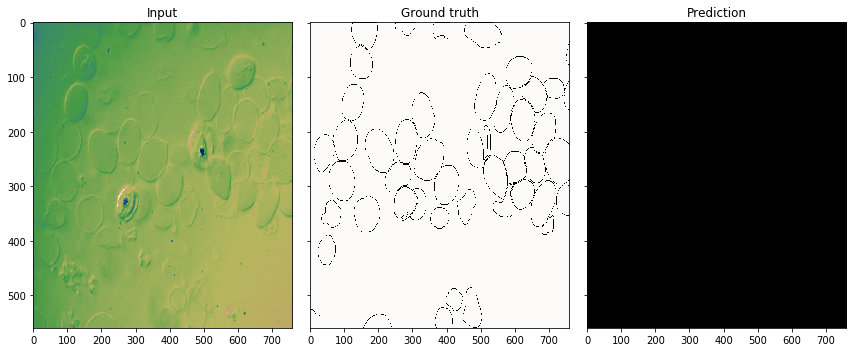

In [110]:
pruebas_broad_009.test(model_broad_009, data_provider_broad_009_test, TRAINED_FOLDER_BROAD_009, False)

###  Electron Microscopy Dataset
- Tomas del hipocampo
- Fuente: https://cvlab.epfl.ch/data/data-em/
- Resolución: 1024 x 768 x 165
- Podría ser utilizado como complemento del dataset EM segmentation challenge - ISBI 2012
- Se ha corrido con 10 épocas y aún no logra buenos resultados (hay que probarlo en la nube)

In [115]:
PATH_ELECTRON_MICROSCOPY_TRAIN = "dataset/electron-microscopy/train/"
PATH_ELECTRON_MICROSCOPY_TEST = "dataset/electron-microscopy/test/"
TRAINED_FOLDER_ELECTRON_MICROSCOPY = "unet_trained_electron_microscopy"
#########################
#True: Volver a entrenar el modelo
#False: Reutiliza los modelos ya entrenados con formado ckpt
#########################
ENTRENAR_ELECTRON_MICROSCOPY_MODEL = True 

Los archivos pesan más de 100mb, por lo que no podremos integrarlos al repositorio. Se procede a descargarlos por única vez.

In [116]:
#Descargar imágenes
URL_ELECTRON_MICROSCOPY_TRAIN = "https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/ ElectronMicroscopy_Hippocampus/training.tif"
URL_ELECTRON_MICROSCOPY_TRAIN_MASK = "https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/ ElectronMicroscopy_Hippocampus/training_groundtruth.tif"
URL_ELECTRON_MICROSCOPY_TEST = "https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/ ElectronMicroscopy_Hippocampus/testing.tif"
URL_ELECTRON_MICROSCOPY_TEST_MASK = "https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/ ElectronMicroscopy_Hippocampus/testing_groundtruth.tif"

def crear_carpetas():
    try:
        os.mkdir("dataset/electron-microscopy/")
        os.mkdir("dataset/electron-microscopy/train") 
        os.mkdir("dataset/electron-microscopy/test") 
        print("Las carpetas han sido creadas")
    except:
        print("Ya están creadas las carpetas")
        
def descargar_imagen(url, path):
    if not os.path.exists(path):
        print("Descargando " + path)
        wget.download(url=url, out=path)

In [117]:
crear_carpetas()
descargar_imagen(URL_ELECTRON_MICROSCOPY_TRAIN, 'dataset/electron-microscopy/train/training.tif')
descargar_imagen(URL_ELECTRON_MICROSCOPY_TRAIN_MASK, 'dataset/electron-microscopy/train/training_mask.tif')
descargar_imagen(URL_ELECTRON_MICROSCOPY_TEST, 'dataset/electron-microscopy/test/testing.tif')
descargar_imagen(URL_ELECTRON_MICROSCOPY_TEST_MASK, 'dataset/electron-microscopy/test/testing_mask.tif')

Ya están creadas las carpetas


Train

In [118]:
data_provider_electron_microscopy_train = ImageDataProvider(PATH_ELECTRON_MICROSCOPY_TRAIN + "*.tif")

Number of files used: 1


In [119]:
#Ejecuta esta línea para reflejar los cambios en la clase Pruebas
pruebas_electron_microscopy = Pruebas();

Image name dataset/electron-microscopy/train\training.tif - Frame Id: 18 - #Frame: 0
Ids reiniciados


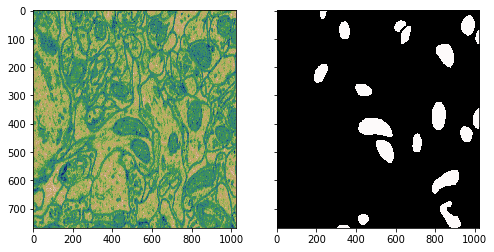

2018-09-27 19:41:51,565 Layers 3, features 16, filter size 3x3, pool size: 2x2
2018-09-27 19:41:52,872 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_electron_microscopy'
2018-09-27 19:41:52,875 Removing 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained_electron_microscopy'
2018-09-27 19:41:52,882 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\prediction_unet_trained_electron_microscopy'
2018-09-27 19:41:52,884 Allocating 'C:\Users\Kevin\AnacondaProjects\Segmentacion\segmentacion-unet\unet_trained_electron_microscopy'


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 156 - #Frame: 0
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 4 - #Frame: 1
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 76 - #Frame: 2
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 124 - #Frame: 3


2018-09-27 19:42:07,874 Verification error= 5.7%, loss= 0.6715
2018-09-27 19:42:09,015 Start optimization


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 121 - #Frame: 4


2018-09-27 19:42:19,796 Iter 0, Minibatch Loss= 0.5810, Training Accuracy= 0.9553, Minibatch error= 4.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 153 - #Frame: 5
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 127 - #Frame: 6


2018-09-27 19:42:37,984 Iter 2, Minibatch Loss= 0.4249, Training Accuracy= 0.9519, Minibatch error= 4.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 100 - #Frame: 7
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 116 - #Frame: 8


2018-09-27 19:42:55,854 Iter 4, Minibatch Loss= 0.2202, Training Accuracy= 0.9601, Minibatch error= 4.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 149 - #Frame: 9
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 20 - #Frame: 10


2018-09-27 19:43:14,149 Iter 6, Minibatch Loss= 0.2893, Training Accuracy= 0.9108, Minibatch error= 8.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 39 - #Frame: 11
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 102 - #Frame: 12


2018-09-27 19:43:31,799 Iter 8, Minibatch Loss= 0.1411, Training Accuracy= 0.9667, Minibatch error= 3.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 78 - #Frame: 13
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 146 - #Frame: 14


2018-09-27 19:43:49,955 Iter 10, Minibatch Loss= 0.1880, Training Accuracy= 0.9491, Minibatch error= 5.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 61 - #Frame: 15
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 148 - #Frame: 16


2018-09-27 19:44:08,102 Iter 12, Minibatch Loss= 0.1896, Training Accuracy= 0.9488, Minibatch error= 5.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 69 - #Frame: 17
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 118 - #Frame: 18


2018-09-27 19:44:26,287 Iter 14, Minibatch Loss= 0.1590, Training Accuracy= 0.9593, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 158 - #Frame: 19
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 94 - #Frame: 20


2018-09-27 19:44:43,807 Iter 16, Minibatch Loss= 0.1339, Training Accuracy= 0.9671, Minibatch error= 3.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 115 - #Frame: 21
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 144 - #Frame: 22


2018-09-27 19:45:01,404 Iter 18, Minibatch Loss= 0.1897, Training Accuracy= 0.9482, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 136 - #Frame: 23
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 66 - #Frame: 24


2018-09-27 19:45:19,142 Iter 20, Minibatch Loss= 0.2078, Training Accuracy= 0.9417, Minibatch error= 5.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 80 - #Frame: 25
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 162 - #Frame: 26


2018-09-27 19:45:36,892 Iter 22, Minibatch Loss= 0.1640, Training Accuracy= 0.9566, Minibatch error= 4.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 112 - #Frame: 27
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 54 - #Frame: 28


2018-09-27 19:45:54,621 Iter 24, Minibatch Loss= 0.2742, Training Accuracy= 0.9145, Minibatch error= 8.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 44 - #Frame: 29
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 114 - #Frame: 30


2018-09-27 19:46:12,666 Iter 26, Minibatch Loss= 0.1524, Training Accuracy= 0.9615, Minibatch error= 3.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 88 - #Frame: 31
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 50 - #Frame: 32


2018-09-27 19:46:30,592 Iter 28, Minibatch Loss= 0.2713, Training Accuracy= 0.9162, Minibatch error= 8.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 62 - #Frame: 33
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 21 - #Frame: 34


2018-09-27 19:46:48,470 Iter 30, Minibatch Loss= 0.2695, Training Accuracy= 0.9162, Minibatch error= 8.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 15 - #Frame: 35
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 143 - #Frame: 36


2018-09-27 19:47:06,410 Iter 32, Minibatch Loss= 0.1867, Training Accuracy= 0.9481, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 90 - #Frame: 37
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 27 - #Frame: 38


2018-09-27 19:47:23,919 Iter 34, Minibatch Loss= 0.2618, Training Accuracy= 0.9191, Minibatch error= 8.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 74 - #Frame: 39
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 98 - #Frame: 40


2018-09-27 19:47:41,720 Iter 36, Minibatch Loss= 0.1260, Training Accuracy= 0.9685, Minibatch error= 3.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 92 - #Frame: 41
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 8 - #Frame: 42


2018-09-27 19:47:59,348 Iter 38, Minibatch Loss= 0.2553, Training Accuracy= 0.9217, Minibatch error= 7.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 24 - #Frame: 43
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 32 - #Frame: 44


2018-09-27 19:48:17,155 Iter 40, Minibatch Loss= 0.2687, Training Accuracy= 0.9155, Minibatch error= 8.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 101 - #Frame: 45
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 57 - #Frame: 46


2018-09-27 19:48:35,137 Iter 42, Minibatch Loss= 0.2288, Training Accuracy= 0.9318, Minibatch error= 6.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 163 - #Frame: 47
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 85 - #Frame: 48


2018-09-27 19:48:52,816 Iter 44, Minibatch Loss= 0.1492, Training Accuracy= 0.9602, Minibatch error= 4.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 160 - #Frame: 49
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 152 - #Frame: 50


2018-09-27 19:49:10,285 Iter 46, Minibatch Loss= 0.1701, Training Accuracy= 0.9523, Minibatch error= 4.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 99 - #Frame: 51
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 36 - #Frame: 52


2018-09-27 19:49:27,792 Iter 48, Minibatch Loss= 0.2610, Training Accuracy= 0.9177, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 10 - #Frame: 53
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 40 - #Frame: 54


2018-09-27 19:49:45,446 Iter 50, Minibatch Loss= 0.2802, Training Accuracy= 0.9079, Minibatch error= 9.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 34 - #Frame: 55
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 16 - #Frame: 56


2018-09-27 19:50:03,122 Iter 52, Minibatch Loss= 0.2660, Training Accuracy= 0.9146, Minibatch error= 8.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 42 - #Frame: 57
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 79 - #Frame: 58


2018-09-27 19:50:20,900 Iter 54, Minibatch Loss= 0.1603, Training Accuracy= 0.9556, Minibatch error= 4.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 104 - #Frame: 59
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 125 - #Frame: 60


2018-09-27 19:50:38,705 Iter 56, Minibatch Loss= 0.1682, Training Accuracy= 0.9536, Minibatch error= 4.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 18 - #Frame: 61
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 64 - #Frame: 62


2018-09-27 19:50:56,600 Iter 58, Minibatch Loss= 0.2089, Training Accuracy= 0.9367, Minibatch error= 6.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 2 - #Frame: 63
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 122 - #Frame: 64


2018-09-27 19:51:15,619 Iter 60, Minibatch Loss= 0.1676, Training Accuracy= 0.9525, Minibatch error= 4.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 75 - #Frame: 65
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 164 - #Frame: 66


2018-09-27 19:51:33,619 Iter 62, Minibatch Loss= 0.1458, Training Accuracy= 0.9589, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 91 - #Frame: 67
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 3 - #Frame: 68


2018-09-27 19:51:51,807 Iter 64, Minibatch Loss= 0.2724, Training Accuracy= 0.9088, Minibatch error= 9.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 55 - #Frame: 69
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 113 - #Frame: 70


2018-09-27 19:52:10,069 Iter 66, Minibatch Loss= 0.1342, Training Accuracy= 0.9632, Minibatch error= 3.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 161 - #Frame: 71
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 131 - #Frame: 72


2018-09-27 19:52:28,512 Iter 68, Minibatch Loss= 0.1734, Training Accuracy= 0.9486, Minibatch error= 5.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 9 - #Frame: 73
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 71 - #Frame: 74


2018-09-27 19:52:46,857 Iter 70, Minibatch Loss= 0.1812, Training Accuracy= 0.9458, Minibatch error= 5.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 139 - #Frame: 75
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 82 - #Frame: 76


2018-09-27 19:53:05,454 Iter 72, Minibatch Loss= 0.1463, Training Accuracy= 0.9589, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 155 - #Frame: 77
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 96 - #Frame: 78


2018-09-27 19:53:23,311 Iter 74, Minibatch Loss= 0.1198, Training Accuracy= 0.9673, Minibatch error= 3.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 129 - #Frame: 79
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 11 - #Frame: 80


2018-09-27 19:53:41,237 Iter 76, Minibatch Loss= 0.2401, Training Accuracy= 0.9205, Minibatch error= 7.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 126 - #Frame: 81
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 132 - #Frame: 82


2018-09-27 19:53:58,810 Iter 78, Minibatch Loss= 0.1713, Training Accuracy= 0.9479, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 47 - #Frame: 83
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 26 - #Frame: 84


2018-09-27 19:54:16,318 Iter 80, Minibatch Loss= 0.2427, Training Accuracy= 0.9182, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 140 - #Frame: 85
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 63 - #Frame: 86


2018-09-27 19:54:33,947 Iter 82, Minibatch Loss= 0.1965, Training Accuracy= 0.9377, Minibatch error= 6.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 22 - #Frame: 87
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 138 - #Frame: 88


2018-09-27 19:54:51,690 Iter 84, Minibatch Loss= 0.1711, Training Accuracy= 0.9473, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 23 - #Frame: 89
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 37 - #Frame: 90


2018-09-27 19:55:09,226 Iter 86, Minibatch Loss= 0.2386, Training Accuracy= 0.9186, Minibatch error= 8.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 159 - #Frame: 91
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 86 - #Frame: 92


2018-09-27 19:55:26,694 Iter 88, Minibatch Loss= 0.1351, Training Accuracy= 0.9609, Minibatch error= 3.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 12 - #Frame: 93
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 17 - #Frame: 94


2018-09-27 19:55:44,156 Iter 90, Minibatch Loss= 0.2336, Training Accuracy= 0.9177, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 58 - #Frame: 95
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 43 - #Frame: 96


2018-09-27 19:56:01,819 Iter 92, Minibatch Loss= 0.2297, Training Accuracy= 0.9191, Minibatch error= 8.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 45 - #Frame: 97
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 106 - #Frame: 98


2018-09-27 19:56:20,341 Iter 94, Minibatch Loss= 0.1086, Training Accuracy= 0.9688, Minibatch error= 3.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 65 - #Frame: 99
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 137 - #Frame: 100


2018-09-27 19:56:38,607 Iter 96, Minibatch Loss= 0.1664, Training Accuracy= 0.9473, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 41 - #Frame: 101
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 111 - #Frame: 102


2018-09-27 19:56:56,910 Iter 98, Minibatch Loss= 0.1177, Training Accuracy= 0.9649, Minibatch error= 3.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 134 - #Frame: 103
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 157 - #Frame: 104


2018-09-27 19:57:14,582 Iter 100, Minibatch Loss= 0.1482, Training Accuracy= 0.9544, Minibatch error= 4.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 14 - #Frame: 105
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 105 - #Frame: 106


2018-09-27 19:57:31,941 Iter 102, Minibatch Loss= 0.1070, Training Accuracy= 0.9688, Minibatch error= 3.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 81 - #Frame: 107
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 13 - #Frame: 108


2018-09-27 19:57:49,671 Iter 104, Minibatch Loss= 0.2287, Training Accuracy= 0.9196, Minibatch error= 8.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 117 - #Frame: 109
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 130 - #Frame: 110


2018-09-27 19:58:07,363 Iter 106, Minibatch Loss= 0.1613, Training Accuracy= 0.9474, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 142 - #Frame: 111
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 60 - #Frame: 112


2018-09-27 19:58:24,911 Iter 108, Minibatch Loss= 0.2017, Training Accuracy= 0.9308, Minibatch error= 6.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 51 - #Frame: 113
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 133 - #Frame: 114


2018-09-27 19:58:42,349 Iter 110, Minibatch Loss= 0.1595, Training Accuracy= 0.9486, Minibatch error= 5.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 108 - #Frame: 115
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 0 - #Frame: 116


2018-09-27 19:58:59,812 Iter 112, Minibatch Loss= 0.2411, Training Accuracy= 0.9144, Minibatch error= 8.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 119 - #Frame: 117
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 123 - #Frame: 118


2018-09-27 19:59:17,306 Iter 114, Minibatch Loss= 0.1491, Training Accuracy= 0.9543, Minibatch error= 4.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 25 - #Frame: 119
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 1 - #Frame: 120


2018-09-27 19:59:34,986 Iter 116, Minibatch Loss= 0.2343, Training Accuracy= 0.9105, Minibatch error= 9.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 29 - #Frame: 121
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 59 - #Frame: 122


2018-09-27 19:59:53,129 Iter 118, Minibatch Loss= 0.1940, Training Accuracy= 0.9325, Minibatch error= 6.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 19 - #Frame: 123
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 70 - #Frame: 124


2018-09-27 20:00:11,195 Iter 120, Minibatch Loss= 0.1697, Training Accuracy= 0.9426, Minibatch error= 5.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 35 - #Frame: 125
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 56 - #Frame: 126


2018-09-27 20:00:29,482 Iter 122, Minibatch Loss= 0.2004, Training Accuracy= 0.9288, Minibatch error= 7.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 38 - #Frame: 127
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 5 - #Frame: 128


2018-09-27 20:00:47,026 Iter 124, Minibatch Loss= 0.2171, Training Accuracy= 0.9193, Minibatch error= 8.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 46 - #Frame: 129
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 33 - #Frame: 130


2018-09-27 20:01:05,616 Iter 126, Minibatch Loss= 0.2180, Training Accuracy= 0.9174, Minibatch error= 8.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 128 - #Frame: 131
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 73 - #Frame: 132


2018-09-27 20:01:24,153 Iter 128, Minibatch Loss= 0.1571, Training Accuracy= 0.9482, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 68 - #Frame: 133
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 6 - #Frame: 134


2018-09-27 20:01:42,262 Iter 130, Minibatch Loss= 0.2179, Training Accuracy= 0.9176, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 145 - #Frame: 135
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 49 - #Frame: 136


2018-09-27 20:02:00,333 Iter 132, Minibatch Loss= 0.2197, Training Accuracy= 0.9185, Minibatch error= 8.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 103 - #Frame: 137
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 28 - #Frame: 138


2018-09-27 20:02:19,286 Iter 134, Minibatch Loss= 0.2301, Training Accuracy= 0.9169, Minibatch error= 8.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 97 - #Frame: 139
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 31 - #Frame: 140


2018-09-27 20:02:38,126 Iter 136, Minibatch Loss= 0.2368, Training Accuracy= 0.9174, Minibatch error= 8.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 67 - #Frame: 141
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 109 - #Frame: 142


2018-09-27 20:02:56,696 Iter 138, Minibatch Loss= 0.1059, Training Accuracy= 0.9673, Minibatch error= 3.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 77 - #Frame: 143
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 135 - #Frame: 144


2018-09-27 20:03:14,947 Iter 140, Minibatch Loss= 0.1579, Training Accuracy= 0.9473, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 7 - #Frame: 145
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 154 - #Frame: 146


2018-09-27 20:03:32,659 Iter 142, Minibatch Loss= 0.1438, Training Accuracy= 0.9525, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 30 - #Frame: 147
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 72 - #Frame: 148


2018-09-27 20:03:49,937 Iter 144, Minibatch Loss= 0.1595, Training Accuracy= 0.9473, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 48 - #Frame: 149
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 52 - #Frame: 150


2018-09-27 20:04:07,529 Iter 146, Minibatch Loss= 0.2061, Training Accuracy= 0.9228, Minibatch error= 7.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 147 - #Frame: 151
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 141 - #Frame: 152


2018-09-27 20:04:25,089 Iter 148, Minibatch Loss= 0.1527, Training Accuracy= 0.9479, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 89 - #Frame: 153
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 93 - #Frame: 154


2018-09-27 20:04:42,539 Iter 150, Minibatch Loss= 0.1110, Training Accuracy= 0.9661, Minibatch error= 3.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 83 - #Frame: 155
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 150 - #Frame: 156


2018-09-27 20:05:00,190 Iter 152, Minibatch Loss= 0.1421, Training Accuracy= 0.9527, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 107 - #Frame: 157
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 53 - #Frame: 158


2018-09-27 20:05:17,712 Iter 154, Minibatch Loss= 0.2139, Training Accuracy= 0.9204, Minibatch error= 8.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 87 - #Frame: 159
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 95 - #Frame: 160


2018-09-27 20:05:35,483 Iter 156, Minibatch Loss= 0.1051, Training Accuracy= 0.9679, Minibatch error= 3.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 110 - #Frame: 161
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 120 - #Frame: 162


2018-09-27 20:05:53,041 Iter 158, Minibatch Loss= 0.1365, Training Accuracy= 0.9565, Minibatch error= 4.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 84 - #Frame: 163


2018-09-27 20:06:00,489 Epoch 0, Average loss: 0.2092, learning rate: 0.2000
2018-09-27 20:06:14,934 Verification error= 5.7%, loss= 0.1655


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 151 - #Frame: 164


2018-09-27 20:06:26,987 Iter 160, Minibatch Loss= 0.1411, Training Accuracy= 0.9532, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 160 - #Frame: 0
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 57 - #Frame: 1


2018-09-27 20:06:45,403 Iter 162, Minibatch Loss= 0.1885, Training Accuracy= 0.9318, Minibatch error= 6.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 82 - #Frame: 2
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 67 - #Frame: 3


2018-09-27 20:07:03,351 Iter 164, Minibatch Loss= 0.1632, Training Accuracy= 0.9436, Minibatch error= 5.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 100 - #Frame: 4
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 118 - #Frame: 5


2018-09-27 20:07:21,030 Iter 166, Minibatch Loss= 0.1289, Training Accuracy= 0.9593, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 122 - #Frame: 6
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 135 - #Frame: 7


2018-09-27 20:07:39,641 Iter 168, Minibatch Loss= 0.1559, Training Accuracy= 0.9473, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 138 - #Frame: 8
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 109 - #Frame: 9


2018-09-27 20:07:57,894 Iter 170, Minibatch Loss= 0.1056, Training Accuracy= 0.9673, Minibatch error= 3.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 144 - #Frame: 10
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 149 - #Frame: 11


2018-09-27 20:08:16,792 Iter 172, Minibatch Loss= 0.1414, Training Accuracy= 0.9527, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 81 - #Frame: 12
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 107 - #Frame: 13


2018-09-27 20:08:34,682 Iter 174, Minibatch Loss= 0.1003, Training Accuracy= 0.9690, Minibatch error= 3.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 106 - #Frame: 14
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 88 - #Frame: 15


2018-09-27 20:08:52,271 Iter 176, Minibatch Loss= 0.1179, Training Accuracy= 0.9630, Minibatch error= 3.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 158 - #Frame: 16
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 12 - #Frame: 17


2018-09-27 20:09:10,631 Iter 178, Minibatch Loss= 0.2171, Training Accuracy= 0.9156, Minibatch error= 8.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 58 - #Frame: 18
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 114 - #Frame: 19


2018-09-27 20:09:28,903 Iter 180, Minibatch Loss= 0.1202, Training Accuracy= 0.9615, Minibatch error= 3.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 84 - #Frame: 20
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 14 - #Frame: 21


2018-09-27 20:09:47,551 Iter 182, Minibatch Loss= 0.2199, Training Accuracy= 0.9199, Minibatch error= 8.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 63 - #Frame: 22
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 7 - #Frame: 23


2018-09-27 20:10:06,494 Iter 184, Minibatch Loss= 0.2045, Training Accuracy= 0.9218, Minibatch error= 7.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 39 - #Frame: 24
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 153 - #Frame: 25


2018-09-27 20:10:25,370 Iter 186, Minibatch Loss= 0.1397, Training Accuracy= 0.9535, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 3 - #Frame: 26
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 80 - #Frame: 27


2018-09-27 20:10:44,301 Iter 188, Minibatch Loss= 0.1401, Training Accuracy= 0.9557, Minibatch error= 4.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 164 - #Frame: 28
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 126 - #Frame: 29


2018-09-27 20:11:03,113 Iter 190, Minibatch Loss= 0.1493, Training Accuracy= 0.9517, Minibatch error= 4.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 23 - #Frame: 30
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 27 - #Frame: 31


2018-09-27 20:11:22,161 Iter 192, Minibatch Loss= 0.2067, Training Accuracy= 0.9191, Minibatch error= 8.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 148 - #Frame: 32
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 21 - #Frame: 33


2018-09-27 20:11:40,932 Iter 194, Minibatch Loss= 0.2117, Training Accuracy= 0.9162, Minibatch error= 8.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 9 - #Frame: 34
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 10 - #Frame: 35


2018-09-27 20:11:59,659 Iter 196, Minibatch Loss= 0.2003, Training Accuracy= 0.9230, Minibatch error= 7.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 40 - #Frame: 36
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 24 - #Frame: 37


2018-09-27 20:12:17,598 Iter 198, Minibatch Loss= 0.2118, Training Accuracy= 0.9162, Minibatch error= 8.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 68 - #Frame: 38
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 154 - #Frame: 39


2018-09-27 20:12:35,629 Iter 200, Minibatch Loss= 0.1405, Training Accuracy= 0.9525, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 152 - #Frame: 40
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 127 - #Frame: 41


2018-09-27 20:12:54,225 Iter 202, Minibatch Loss= 0.1503, Training Accuracy= 0.9519, Minibatch error= 4.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 155 - #Frame: 42
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 71 - #Frame: 43


2018-09-27 20:13:12,229 Iter 204, Minibatch Loss= 0.1530, Training Accuracy= 0.9458, Minibatch error= 5.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 159 - #Frame: 44
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 64 - #Frame: 45


2018-09-27 20:13:29,859 Iter 206, Minibatch Loss= 0.1710, Training Accuracy= 0.9367, Minibatch error= 6.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 92 - #Frame: 46
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 83 - #Frame: 47


2018-09-27 20:13:47,483 Iter 208, Minibatch Loss= 0.1251, Training Accuracy= 0.9590, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 145 - #Frame: 48
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 45 - #Frame: 49


2018-09-27 20:14:05,308 Iter 210, Minibatch Loss= 0.2039, Training Accuracy= 0.9181, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 146 - #Frame: 50
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 48 - #Frame: 51


2018-09-27 20:14:23,817 Iter 212, Minibatch Loss= 0.2027, Training Accuracy= 0.9178, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 99 - #Frame: 52
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 112 - #Frame: 53


2018-09-27 20:14:43,213 Iter 214, Minibatch Loss= 0.1119, Training Accuracy= 0.9615, Minibatch error= 3.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 53 - #Frame: 54
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 147 - #Frame: 55


2018-09-27 20:15:02,178 Iter 216, Minibatch Loss= 0.1418, Training Accuracy= 0.9499, Minibatch error= 5.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 110 - #Frame: 56
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 96 - #Frame: 57


2018-09-27 20:15:20,329 Iter 218, Minibatch Loss= 0.0988, Training Accuracy= 0.9673, Minibatch error= 3.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 11 - #Frame: 58
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 128 - #Frame: 59


2018-09-27 20:15:38,085 Iter 220, Minibatch Loss= 0.1474, Training Accuracy= 0.9505, Minibatch error= 4.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 66 - #Frame: 60
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 119 - #Frame: 61


2018-09-27 20:15:56,205 Iter 222, Minibatch Loss= 0.1236, Training Accuracy= 0.9586, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 98 - #Frame: 62
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 73 - #Frame: 63


2018-09-27 20:16:14,157 Iter 224, Minibatch Loss= 0.1438, Training Accuracy= 0.9482, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 0 - #Frame: 64
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 113 - #Frame: 65


2018-09-27 20:16:31,747 Iter 226, Minibatch Loss= 0.1153, Training Accuracy= 0.9632, Minibatch error= 3.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 162 - #Frame: 66
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 87 - #Frame: 67


2018-09-27 20:16:49,617 Iter 228, Minibatch Loss= 0.1114, Training Accuracy= 0.9629, Minibatch error= 3.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 51 - #Frame: 68
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 91 - #Frame: 69


2018-09-27 20:17:07,763 Iter 230, Minibatch Loss= 0.1029, Training Accuracy= 0.9649, Minibatch error= 3.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 34 - #Frame: 70
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 33 - #Frame: 71


2018-09-27 20:17:25,667 Iter 232, Minibatch Loss= 0.1964, Training Accuracy= 0.9174, Minibatch error= 8.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 17 - #Frame: 72
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 156 - #Frame: 73


2018-09-27 20:17:43,636 Iter 234, Minibatch Loss= 0.1338, Training Accuracy= 0.9538, Minibatch error= 4.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 132 - #Frame: 74
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 78 - #Frame: 75


2018-09-27 20:18:01,878 Iter 236, Minibatch Loss= 0.1259, Training Accuracy= 0.9541, Minibatch error= 4.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 31 - #Frame: 76
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 133 - #Frame: 77


2018-09-27 20:18:20,386 Iter 238, Minibatch Loss= 0.1414, Training Accuracy= 0.9486, Minibatch error= 5.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 136 - #Frame: 78
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 115 - #Frame: 79


2018-09-27 20:18:38,278 Iter 240, Minibatch Loss= 0.1070, Training Accuracy= 0.9616, Minibatch error= 3.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 117 - #Frame: 80
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 102 - #Frame: 81


2018-09-27 20:18:56,224 Iter 242, Minibatch Loss= 0.0919, Training Accuracy= 0.9667, Minibatch error= 3.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 15 - #Frame: 82
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 60 - #Frame: 83


2018-09-27 20:19:13,997 Iter 244, Minibatch Loss= 0.1743, Training Accuracy= 0.9308, Minibatch error= 6.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 151 - #Frame: 84
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 65 - #Frame: 85


2018-09-27 20:19:31,890 Iter 246, Minibatch Loss= 0.1475, Training Accuracy= 0.9413, Minibatch error= 5.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 120 - #Frame: 86
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 163 - #Frame: 87


2018-09-27 20:19:49,915 Iter 248, Minibatch Loss= 0.1163, Training Accuracy= 0.9589, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 105 - #Frame: 88
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 26 - #Frame: 89


2018-09-27 20:20:07,914 Iter 250, Minibatch Loss= 0.2051, Training Accuracy= 0.9182, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 61 - #Frame: 90
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 139 - #Frame: 91


2018-09-27 20:20:25,772 Iter 252, Minibatch Loss= 0.1356, Training Accuracy= 0.9484, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 93 - #Frame: 92
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 18 - #Frame: 93


2018-09-27 20:20:43,912 Iter 254, Minibatch Loss= 0.1843, Training Accuracy= 0.9172, Minibatch error= 8.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 38 - #Frame: 94
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 28 - #Frame: 95


2018-09-27 20:21:02,004 Iter 256, Minibatch Loss= 0.1926, Training Accuracy= 0.9169, Minibatch error= 8.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 74 - #Frame: 96
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 134 - #Frame: 97


2018-09-27 20:21:20,631 Iter 258, Minibatch Loss= 0.1590, Training Accuracy= 0.9476, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 16 - #Frame: 98
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 157 - #Frame: 99


2018-09-27 20:21:38,606 Iter 260, Minibatch Loss= 0.1239, Training Accuracy= 0.9544, Minibatch error= 4.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 72 - #Frame: 100
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 143 - #Frame: 101


2018-09-27 20:21:56,537 Iter 262, Minibatch Loss= 0.1306, Training Accuracy= 0.9481, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 5 - #Frame: 102
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 32 - #Frame: 103


2018-09-27 20:22:14,719 Iter 264, Minibatch Loss= 0.1765, Training Accuracy= 0.9155, Minibatch error= 8.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 129 - #Frame: 104
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 22 - #Frame: 105


2018-09-27 20:22:32,805 Iter 266, Minibatch Loss= 0.1925, Training Accuracy= 0.9166, Minibatch error= 8.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 137 - #Frame: 106
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 150 - #Frame: 107


2018-09-27 20:22:50,872 Iter 268, Minibatch Loss= 0.1181, Training Accuracy= 0.9527, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 79 - #Frame: 108
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 4 - #Frame: 109


2018-09-27 20:23:08,696 Iter 270, Minibatch Loss= 0.2637, Training Accuracy= 0.9173, Minibatch error= 8.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 59 - #Frame: 110
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 56 - #Frame: 111


2018-09-27 20:23:26,646 Iter 272, Minibatch Loss= 0.1568, Training Accuracy= 0.9288, Minibatch error= 7.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 116 - #Frame: 112
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 70 - #Frame: 113


2018-09-27 20:23:44,898 Iter 274, Minibatch Loss= 0.1384, Training Accuracy= 0.9426, Minibatch error= 5.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 76 - #Frame: 114
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 111 - #Frame: 115


2018-09-27 20:24:02,900 Iter 276, Minibatch Loss= 0.0834, Training Accuracy= 0.9649, Minibatch error= 3.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 42 - #Frame: 116
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 121 - #Frame: 117


2018-09-27 20:24:20,833 Iter 278, Minibatch Loss= 0.1266, Training Accuracy= 0.9553, Minibatch error= 4.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 85 - #Frame: 118
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 19 - #Frame: 119


2018-09-27 20:24:38,653 Iter 280, Minibatch Loss= 0.3135, Training Accuracy= 0.9156, Minibatch error= 8.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 161 - #Frame: 120
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 130 - #Frame: 121


2018-09-27 20:24:56,539 Iter 282, Minibatch Loss= 0.1310, Training Accuracy= 0.9474, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 2 - #Frame: 122
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 108 - #Frame: 123


2018-09-27 20:25:14,663 Iter 284, Minibatch Loss= 0.0895, Training Accuracy= 0.9679, Minibatch error= 3.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 104 - #Frame: 124
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 97 - #Frame: 125


2018-09-27 20:25:32,776 Iter 286, Minibatch Loss= 0.0755, Training Accuracy= 0.9687, Minibatch error= 3.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 86 - #Frame: 126
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 25 - #Frame: 127


2018-09-27 20:25:50,608 Iter 288, Minibatch Loss= 0.1729, Training Accuracy= 0.9190, Minibatch error= 8.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 142 - #Frame: 128
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 50 - #Frame: 129


2018-09-27 20:26:08,270 Iter 290, Minibatch Loss= 0.1691, Training Accuracy= 0.9162, Minibatch error= 8.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 36 - #Frame: 130
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 131 - #Frame: 131


2018-09-27 20:26:26,177 Iter 292, Minibatch Loss= 0.1210, Training Accuracy= 0.9486, Minibatch error= 5.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 46 - #Frame: 132
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 52 - #Frame: 133


2018-09-27 20:26:44,169 Iter 294, Minibatch Loss= 0.1556, Training Accuracy= 0.9228, Minibatch error= 7.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 20 - #Frame: 134
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 89 - #Frame: 135


2018-09-27 20:27:02,353 Iter 296, Minibatch Loss= 0.0873, Training Accuracy= 0.9654, Minibatch error= 3.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 37 - #Frame: 136
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 47 - #Frame: 137


2018-09-27 20:27:20,227 Iter 298, Minibatch Loss= 0.1630, Training Accuracy= 0.9181, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 35 - #Frame: 138
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 94 - #Frame: 139


2018-09-27 20:27:38,189 Iter 300, Minibatch Loss= 0.0742, Training Accuracy= 0.9671, Minibatch error= 3.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 125 - #Frame: 140
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 140 - #Frame: 141


2018-09-27 20:27:55,903 Iter 302, Minibatch Loss= 0.1202, Training Accuracy= 0.9478, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 13 - #Frame: 142
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 77 - #Frame: 143


2018-09-27 20:28:13,787 Iter 304, Minibatch Loss= 0.1100, Training Accuracy= 0.9530, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 141 - #Frame: 144
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 6 - #Frame: 145


2018-09-27 20:28:31,736 Iter 306, Minibatch Loss= 0.1681, Training Accuracy= 0.9176, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 55 - #Frame: 146
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 44 - #Frame: 147


2018-09-27 20:28:49,820 Iter 308, Minibatch Loss= 0.1607, Training Accuracy= 0.9184, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 49 - #Frame: 148
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 123 - #Frame: 149


2018-09-27 20:29:07,795 Iter 310, Minibatch Loss= 0.1155, Training Accuracy= 0.9543, Minibatch error= 4.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 29 - #Frame: 150
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 54 - #Frame: 151


2018-09-27 20:29:25,678 Iter 312, Minibatch Loss= 0.1687, Training Accuracy= 0.9145, Minibatch error= 8.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 75 - #Frame: 152
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 69 - #Frame: 153


2018-09-27 20:29:43,390 Iter 314, Minibatch Loss= 0.1207, Training Accuracy= 0.9434, Minibatch error= 5.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 103 - #Frame: 154
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 95 - #Frame: 155


2018-09-27 20:30:01,279 Iter 316, Minibatch Loss= 0.0733, Training Accuracy= 0.9679, Minibatch error= 3.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 124 - #Frame: 156
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 1 - #Frame: 157


2018-09-27 20:30:19,489 Iter 318, Minibatch Loss= 0.1724, Training Accuracy= 0.9105, Minibatch error= 9.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 8 - #Frame: 158


2018-09-27 20:30:27,312 Epoch 1, Average loss: 0.1594, learning rate: 0.1900
2018-09-27 20:30:42,228 Verification error= 5.7%, loss= 0.1356


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 30 - #Frame: 159


2018-09-27 20:30:53,778 Iter 320, Minibatch Loss= 0.1821, Training Accuracy= 0.9153, Minibatch error= 8.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 101 - #Frame: 160
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 43 - #Frame: 161


2018-09-27 20:31:12,455 Iter 322, Minibatch Loss= 0.1906, Training Accuracy= 0.9191, Minibatch error= 8.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 62 - #Frame: 162
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 90 - #Frame: 163


2018-09-27 20:31:30,669 Iter 324, Minibatch Loss= 0.0803, Training Accuracy= 0.9650, Minibatch error= 3.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 41 - #Frame: 164
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 68 - #Frame: 0


2018-09-27 20:31:48,407 Iter 326, Minibatch Loss= 0.1305, Training Accuracy= 0.9421, Minibatch error= 5.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 1 - #Frame: 1
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 115 - #Frame: 2


2018-09-27 20:32:06,198 Iter 328, Minibatch Loss= 0.0864, Training Accuracy= 0.9616, Minibatch error= 3.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 6 - #Frame: 3
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 145 - #Frame: 4


2018-09-27 20:32:24,009 Iter 330, Minibatch Loss= 0.1146, Training Accuracy= 0.9499, Minibatch error= 5.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 85 - #Frame: 5
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 103 - #Frame: 6


2018-09-27 20:32:41,934 Iter 332, Minibatch Loss= 0.0713, Training Accuracy= 0.9684, Minibatch error= 3.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 64 - #Frame: 7
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 124 - #Frame: 8


2018-09-27 20:32:59,693 Iter 334, Minibatch Loss= 0.1167, Training Accuracy= 0.9540, Minibatch error= 4.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 155 - #Frame: 9
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 10 - #Frame: 10


2018-09-27 20:33:17,686 Iter 336, Minibatch Loss= 0.1728, Training Accuracy= 0.9230, Minibatch error= 7.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 131 - #Frame: 11
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 113 - #Frame: 12


2018-09-27 20:33:35,748 Iter 338, Minibatch Loss= 0.0782, Training Accuracy= 0.9632, Minibatch error= 3.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 152 - #Frame: 13
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 136 - #Frame: 14


2018-09-27 20:33:53,659 Iter 340, Minibatch Loss= 0.1258, Training Accuracy= 0.9454, Minibatch error= 5.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 11 - #Frame: 15
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 63 - #Frame: 16


2018-09-27 20:34:11,430 Iter 342, Minibatch Loss= 0.1267, Training Accuracy= 0.9377, Minibatch error= 6.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 51 - #Frame: 17
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 66 - #Frame: 18


2018-09-27 20:34:29,356 Iter 344, Minibatch Loss= 0.1160, Training Accuracy= 0.9417, Minibatch error= 5.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 111 - #Frame: 19
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 47 - #Frame: 20


2018-09-27 20:34:47,238 Iter 346, Minibatch Loss= 0.1843, Training Accuracy= 0.9181, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 76 - #Frame: 21
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 59 - #Frame: 22


2018-09-27 20:35:05,113 Iter 348, Minibatch Loss= 0.1322, Training Accuracy= 0.9325, Minibatch error= 6.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 156 - #Frame: 23
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 144 - #Frame: 24


2018-09-27 20:35:22,844 Iter 350, Minibatch Loss= 0.1133, Training Accuracy= 0.9482, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 110 - #Frame: 25
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 142 - #Frame: 26


2018-09-27 20:35:40,520 Iter 352, Minibatch Loss= 0.1402, Training Accuracy= 0.9462, Minibatch error= 5.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 70 - #Frame: 27
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 118 - #Frame: 28


2018-09-27 20:35:58,284 Iter 354, Minibatch Loss= 0.0948, Training Accuracy= 0.9593, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 107 - #Frame: 29
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 157 - #Frame: 30


2018-09-27 20:36:16,218 Iter 356, Minibatch Loss= 0.1469, Training Accuracy= 0.9544, Minibatch error= 4.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 9 - #Frame: 31
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 150 - #Frame: 32


2018-09-27 20:36:34,042 Iter 358, Minibatch Loss= 0.1055, Training Accuracy= 0.9527, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 94 - #Frame: 33
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 41 - #Frame: 34


2018-09-27 20:36:52,022 Iter 360, Minibatch Loss= 0.2053, Training Accuracy= 0.9147, Minibatch error= 8.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 108 - #Frame: 35
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 22 - #Frame: 36


2018-09-27 20:37:09,957 Iter 362, Minibatch Loss= 0.1531, Training Accuracy= 0.9166, Minibatch error= 8.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 18 - #Frame: 37
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 40 - #Frame: 38


2018-09-27 20:37:28,155 Iter 364, Minibatch Loss= 0.2112, Training Accuracy= 0.9079, Minibatch error= 9.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 36 - #Frame: 39
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 61 - #Frame: 40


2018-09-27 20:37:45,949 Iter 366, Minibatch Loss= 0.1316, Training Accuracy= 0.9351, Minibatch error= 6.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 75 - #Frame: 41
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 26 - #Frame: 42


2018-09-27 20:38:03,744 Iter 368, Minibatch Loss= 0.1776, Training Accuracy= 0.9182, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 27 - #Frame: 43
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 5 - #Frame: 44


2018-09-27 20:38:21,686 Iter 370, Minibatch Loss= 0.1873, Training Accuracy= 0.9193, Minibatch error= 8.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 54 - #Frame: 45
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 140 - #Frame: 46


2018-09-27 20:38:39,385 Iter 372, Minibatch Loss= 0.1151, Training Accuracy= 0.9478, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 21 - #Frame: 47
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 90 - #Frame: 48


2018-09-27 20:38:57,321 Iter 374, Minibatch Loss= 0.0738, Training Accuracy= 0.9650, Minibatch error= 3.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 78 - #Frame: 49
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 135 - #Frame: 50


2018-09-27 20:39:15,797 Iter 376, Minibatch Loss= 0.1188, Training Accuracy= 0.9473, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 91 - #Frame: 51
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 80 - #Frame: 52


2018-09-27 20:39:34,549 Iter 378, Minibatch Loss= 0.0974, Training Accuracy= 0.9557, Minibatch error= 4.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 34 - #Frame: 53
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 44 - #Frame: 54


2018-09-27 20:39:52,277 Iter 380, Minibatch Loss= 0.1483, Training Accuracy= 0.9184, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 98 - #Frame: 55
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 139 - #Frame: 56


2018-09-27 20:40:10,062 Iter 382, Minibatch Loss= 0.1260, Training Accuracy= 0.9484, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 160 - #Frame: 57
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 73 - #Frame: 58


2018-09-27 20:40:28,136 Iter 384, Minibatch Loss= 0.1065, Training Accuracy= 0.9482, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 116 - #Frame: 59
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 24 - #Frame: 60


2018-09-27 20:40:45,894 Iter 386, Minibatch Loss= 0.2056, Training Accuracy= 0.9162, Minibatch error= 8.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 2 - #Frame: 61
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 141 - #Frame: 62


2018-09-27 20:41:04,219 Iter 388, Minibatch Loss= 0.1137, Training Accuracy= 0.9479, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 13 - #Frame: 63
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 97 - #Frame: 64


2018-09-27 20:41:22,412 Iter 390, Minibatch Loss= 0.0636, Training Accuracy= 0.9687, Minibatch error= 3.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 125 - #Frame: 65
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 86 - #Frame: 66


2018-09-27 20:41:40,210 Iter 392, Minibatch Loss= 0.0861, Training Accuracy= 0.9609, Minibatch error= 3.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 105 - #Frame: 67
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 32 - #Frame: 68


2018-09-27 20:41:58,019 Iter 394, Minibatch Loss= 0.2349, Training Accuracy= 0.9155, Minibatch error= 8.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 121 - #Frame: 69
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 164 - #Frame: 70


2018-09-27 20:42:15,646 Iter 396, Minibatch Loss= 0.0922, Training Accuracy= 0.9589, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 77 - #Frame: 71
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 16 - #Frame: 72


2018-09-27 20:42:33,206 Iter 398, Minibatch Loss= 0.2199, Training Accuracy= 0.9146, Minibatch error= 8.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 101 - #Frame: 73
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 84 - #Frame: 74


2018-09-27 20:42:50,836 Iter 400, Minibatch Loss= 0.0914, Training Accuracy= 0.9575, Minibatch error= 4.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 163 - #Frame: 75
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 7 - #Frame: 76


2018-09-27 20:43:08,624 Iter 402, Minibatch Loss= 0.1404, Training Accuracy= 0.9218, Minibatch error= 7.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 83 - #Frame: 77
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 134 - #Frame: 78


2018-09-27 20:43:26,587 Iter 404, Minibatch Loss= 0.1240, Training Accuracy= 0.9476, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 20 - #Frame: 79
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 62 - #Frame: 80


2018-09-27 20:43:44,574 Iter 406, Minibatch Loss= 0.1225, Training Accuracy= 0.9362, Minibatch error= 6.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 45 - #Frame: 81
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 162 - #Frame: 82


2018-09-27 20:44:02,186 Iter 408, Minibatch Loss= 0.0986, Training Accuracy= 0.9566, Minibatch error= 4.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 87 - #Frame: 83
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 104 - #Frame: 84


2018-09-27 20:44:20,125 Iter 410, Minibatch Loss= 0.0730, Training Accuracy= 0.9675, Minibatch error= 3.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 69 - #Frame: 85
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 8 - #Frame: 86


2018-09-27 20:44:37,786 Iter 412, Minibatch Loss= 0.2091, Training Accuracy= 0.9217, Minibatch error= 7.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 146 - #Frame: 87
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 92 - #Frame: 88


2018-09-27 20:44:55,567 Iter 414, Minibatch Loss= 0.0778, Training Accuracy= 0.9632, Minibatch error= 3.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 159 - #Frame: 89
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 19 - #Frame: 90


2018-09-27 20:45:13,799 Iter 416, Minibatch Loss= 0.1473, Training Accuracy= 0.9156, Minibatch error= 8.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 55 - #Frame: 91
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 28 - #Frame: 92


2018-09-27 20:45:31,821 Iter 418, Minibatch Loss= 0.1528, Training Accuracy= 0.9169, Minibatch error= 8.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 106 - #Frame: 93
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 153 - #Frame: 94


2018-09-27 20:45:49,591 Iter 420, Minibatch Loss= 0.1031, Training Accuracy= 0.9535, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 71 - #Frame: 95
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 130 - #Frame: 96


2018-09-27 20:46:07,561 Iter 422, Minibatch Loss= 0.1140, Training Accuracy= 0.9474, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 43 - #Frame: 97
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 129 - #Frame: 98


2018-09-27 20:46:25,062 Iter 424, Minibatch Loss= 0.1137, Training Accuracy= 0.9497, Minibatch error= 5.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 88 - #Frame: 99
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 56 - #Frame: 100


2018-09-27 20:46:42,724 Iter 426, Minibatch Loss= 0.1327, Training Accuracy= 0.9288, Minibatch error= 7.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 29 - #Frame: 101
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 12 - #Frame: 102


2018-09-27 20:47:00,883 Iter 428, Minibatch Loss= 0.1513, Training Accuracy= 0.9156, Minibatch error= 8.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 33 - #Frame: 103
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 72 - #Frame: 104


2018-09-27 20:47:18,454 Iter 430, Minibatch Loss= 0.1066, Training Accuracy= 0.9473, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 3 - #Frame: 105
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 39 - #Frame: 106


2018-09-27 20:47:36,256 Iter 432, Minibatch Loss= 0.1690, Training Accuracy= 0.9141, Minibatch error= 8.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 158 - #Frame: 107
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 30 - #Frame: 108


2018-09-27 20:47:53,849 Iter 434, Minibatch Loss= 0.1599, Training Accuracy= 0.9153, Minibatch error= 8.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 0 - #Frame: 109
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 149 - #Frame: 110


2018-09-27 20:48:11,480 Iter 436, Minibatch Loss= 0.1032, Training Accuracy= 0.9527, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 123 - #Frame: 111
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 81 - #Frame: 112


2018-09-27 20:48:29,252 Iter 438, Minibatch Loss= 0.0859, Training Accuracy= 0.9589, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 67 - #Frame: 113
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 42 - #Frame: 114


2018-09-27 20:48:47,078 Iter 440, Minibatch Loss= 0.1584, Training Accuracy= 0.9160, Minibatch error= 8.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 52 - #Frame: 115
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 35 - #Frame: 116


2018-09-27 20:49:04,916 Iter 442, Minibatch Loss= 0.1447, Training Accuracy= 0.9180, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 102 - #Frame: 117
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 60 - #Frame: 118


2018-09-27 20:49:23,175 Iter 444, Minibatch Loss= 0.1415, Training Accuracy= 0.9308, Minibatch error= 6.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 15 - #Frame: 119
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 79 - #Frame: 120


2018-09-27 20:49:41,939 Iter 446, Minibatch Loss= 0.0915, Training Accuracy= 0.9556, Minibatch error= 4.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 126 - #Frame: 121
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 109 - #Frame: 122


2018-09-27 20:50:00,959 Iter 448, Minibatch Loss= 0.0769, Training Accuracy= 0.9673, Minibatch error= 3.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 122 - #Frame: 123
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 17 - #Frame: 124


2018-09-27 20:50:19,798 Iter 450, Minibatch Loss= 0.1489, Training Accuracy= 0.9177, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 50 - #Frame: 125
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 53 - #Frame: 126


2018-09-27 20:50:38,971 Iter 452, Minibatch Loss= 0.1386, Training Accuracy= 0.9204, Minibatch error= 8.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 58 - #Frame: 127
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 65 - #Frame: 128


2018-09-27 20:50:57,393 Iter 454, Minibatch Loss= 0.1107, Training Accuracy= 0.9413, Minibatch error= 5.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 93 - #Frame: 129
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 120 - #Frame: 130


2018-09-27 20:51:16,803 Iter 456, Minibatch Loss= 0.0987, Training Accuracy= 0.9565, Minibatch error= 4.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 95 - #Frame: 131
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 137 - #Frame: 132


2018-09-27 20:51:35,210 Iter 458, Minibatch Loss= 0.1200, Training Accuracy= 0.9473, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 25 - #Frame: 133
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 99 - #Frame: 134


2018-09-27 20:51:53,546 Iter 460, Minibatch Loss= 0.0597, Training Accuracy= 0.9706, Minibatch error= 2.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 23 - #Frame: 135
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 148 - #Frame: 136


2018-09-27 20:52:12,010 Iter 462, Minibatch Loss= 0.1099, Training Accuracy= 0.9488, Minibatch error= 5.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 14 - #Frame: 137
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 114 - #Frame: 138


2018-09-27 20:52:30,260 Iter 464, Minibatch Loss= 0.0778, Training Accuracy= 0.9615, Minibatch error= 3.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 48 - #Frame: 139
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 31 - #Frame: 140


2018-09-27 20:52:48,927 Iter 466, Minibatch Loss= 0.1787, Training Accuracy= 0.9174, Minibatch error= 8.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 147 - #Frame: 141
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 151 - #Frame: 142


2018-09-27 20:53:07,522 Iter 468, Minibatch Loss= 0.0968, Training Accuracy= 0.9532, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 96 - #Frame: 143
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 128 - #Frame: 144


2018-09-27 20:53:25,882 Iter 470, Minibatch Loss= 0.1307, Training Accuracy= 0.9505, Minibatch error= 4.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 100 - #Frame: 145
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 89 - #Frame: 146


2018-09-27 20:53:45,492 Iter 472, Minibatch Loss= 0.0695, Training Accuracy= 0.9654, Minibatch error= 3.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 161 - #Frame: 147
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 119 - #Frame: 148


2018-09-27 20:54:03,946 Iter 474, Minibatch Loss= 0.0941, Training Accuracy= 0.9586, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 112 - #Frame: 149
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 132 - #Frame: 150


2018-09-27 20:54:22,361 Iter 476, Minibatch Loss= 0.1125, Training Accuracy= 0.9479, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 49 - #Frame: 151
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 57 - #Frame: 152


2018-09-27 20:54:41,151 Iter 478, Minibatch Loss= 0.1211, Training Accuracy= 0.9318, Minibatch error= 6.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 143 - #Frame: 153


2018-09-27 20:54:49,252 Epoch 2, Average loss: 0.1325, learning rate: 0.1805
2018-09-27 20:55:03,818 Verification error= 5.7%, loss= 0.1263


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 154 - #Frame: 154


2018-09-27 20:55:15,559 Iter 480, Minibatch Loss= 0.0999, Training Accuracy= 0.9525, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 38 - #Frame: 155
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 46 - #Frame: 156


2018-09-27 20:55:33,836 Iter 482, Minibatch Loss= 0.1489, Training Accuracy= 0.9146, Minibatch error= 8.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 138 - #Frame: 157
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 37 - #Frame: 158


2018-09-27 20:55:52,078 Iter 484, Minibatch Loss= 0.1417, Training Accuracy= 0.9186, Minibatch error= 8.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 133 - #Frame: 159
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 74 - #Frame: 160


2018-09-27 20:56:10,623 Iter 486, Minibatch Loss= 0.1069, Training Accuracy= 0.9469, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 82 - #Frame: 161
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 127 - #Frame: 162


2018-09-27 20:56:28,966 Iter 488, Minibatch Loss= 0.1302, Training Accuracy= 0.9519, Minibatch error= 4.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 4 - #Frame: 163
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 117 - #Frame: 164


2018-09-27 20:56:47,500 Iter 490, Minibatch Loss= 0.0835, Training Accuracy= 0.9614, Minibatch error= 3.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 132 - #Frame: 0
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 90 - #Frame: 1


2018-09-27 20:57:06,351 Iter 492, Minibatch Loss= 0.0749, Training Accuracy= 0.9650, Minibatch error= 3.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 68 - #Frame: 2
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 19 - #Frame: 3


2018-09-27 20:57:25,470 Iter 494, Minibatch Loss= 0.1458, Training Accuracy= 0.9156, Minibatch error= 8.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 4 - #Frame: 4
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 160 - #Frame: 5


2018-09-27 20:57:44,250 Iter 496, Minibatch Loss= 0.0973, Training Accuracy= 0.9558, Minibatch error= 4.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 23 - #Frame: 6
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 71 - #Frame: 7


2018-09-27 20:58:02,778 Iter 498, Minibatch Loss= 0.1057, Training Accuracy= 0.9458, Minibatch error= 5.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 52 - #Frame: 8
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 138 - #Frame: 9


2018-09-27 20:58:21,347 Iter 500, Minibatch Loss= 0.1211, Training Accuracy= 0.9473, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 142 - #Frame: 10
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 139 - #Frame: 11


2018-09-27 20:58:39,602 Iter 502, Minibatch Loss= 0.1104, Training Accuracy= 0.9484, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 133 - #Frame: 12
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 81 - #Frame: 13


2018-09-27 20:58:58,189 Iter 504, Minibatch Loss= 0.0840, Training Accuracy= 0.9589, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 79 - #Frame: 14
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 14 - #Frame: 15


2018-09-27 20:59:16,955 Iter 506, Minibatch Loss= 0.1794, Training Accuracy= 0.9199, Minibatch error= 8.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 30 - #Frame: 16
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 100 - #Frame: 17


2018-09-27 20:59:35,394 Iter 508, Minibatch Loss= 0.0646, Training Accuracy= 0.9692, Minibatch error= 3.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 62 - #Frame: 18
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 119 - #Frame: 19


2018-09-27 20:59:53,612 Iter 510, Minibatch Loss= 0.0921, Training Accuracy= 0.9586, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 91 - #Frame: 20
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 149 - #Frame: 21


2018-09-27 21:00:12,315 Iter 512, Minibatch Loss= 0.1053, Training Accuracy= 0.9527, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 113 - #Frame: 22
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 17 - #Frame: 23


2018-09-27 21:00:30,602 Iter 514, Minibatch Loss= 0.1482, Training Accuracy= 0.9177, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 106 - #Frame: 24
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 95 - #Frame: 25


2018-09-27 21:00:48,675 Iter 516, Minibatch Loss= 0.0610, Training Accuracy= 0.9679, Minibatch error= 3.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 20 - #Frame: 26
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 145 - #Frame: 27


2018-09-27 21:01:06,944 Iter 518, Minibatch Loss= 0.1064, Training Accuracy= 0.9499, Minibatch error= 5.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 148 - #Frame: 28
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 0 - #Frame: 29


2018-09-27 21:01:25,173 Iter 520, Minibatch Loss= 0.1463, Training Accuracy= 0.9144, Minibatch error= 8.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 60 - #Frame: 30
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 54 - #Frame: 31


2018-09-27 21:01:43,553 Iter 522, Minibatch Loss= 0.1533, Training Accuracy= 0.9145, Minibatch error= 8.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 107 - #Frame: 32
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 77 - #Frame: 33


2018-09-27 21:02:01,818 Iter 524, Minibatch Loss= 0.0982, Training Accuracy= 0.9530, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 101 - #Frame: 34
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 153 - #Frame: 35


2018-09-27 21:02:20,124 Iter 526, Minibatch Loss= 0.0999, Training Accuracy= 0.9535, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 21 - #Frame: 36
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 55 - #Frame: 37


2018-09-27 21:02:38,099 Iter 528, Minibatch Loss= 0.1300, Training Accuracy= 0.9245, Minibatch error= 7.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 8 - #Frame: 38
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 123 - #Frame: 39


2018-09-27 21:02:56,102 Iter 530, Minibatch Loss= 0.1045, Training Accuracy= 0.9543, Minibatch error= 4.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 31 - #Frame: 40
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 124 - #Frame: 41


2018-09-27 21:03:14,424 Iter 532, Minibatch Loss= 0.1034, Training Accuracy= 0.9540, Minibatch error= 4.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 102 - #Frame: 42
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 130 - #Frame: 43


2018-09-27 21:03:32,724 Iter 534, Minibatch Loss= 0.1127, Training Accuracy= 0.9474, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 33 - #Frame: 44
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 151 - #Frame: 45


2018-09-27 21:03:51,071 Iter 536, Minibatch Loss= 0.0980, Training Accuracy= 0.9532, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 40 - #Frame: 46
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 50 - #Frame: 47


2018-09-27 21:04:09,606 Iter 538, Minibatch Loss= 0.1409, Training Accuracy= 0.9162, Minibatch error= 8.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 59 - #Frame: 48
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 99 - #Frame: 49


2018-09-27 21:04:27,989 Iter 540, Minibatch Loss= 0.0579, Training Accuracy= 0.9706, Minibatch error= 2.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 129 - #Frame: 50
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 163 - #Frame: 51


2018-09-27 21:04:46,641 Iter 542, Minibatch Loss= 0.0940, Training Accuracy= 0.9589, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 161 - #Frame: 52
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 143 - #Frame: 53


2018-09-27 21:05:05,121 Iter 544, Minibatch Loss= 0.1058, Training Accuracy= 0.9481, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 122 - #Frame: 54
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 144 - #Frame: 55


2018-09-27 21:05:23,382 Iter 546, Minibatch Loss= 0.1096, Training Accuracy= 0.9482, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 76 - #Frame: 56
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 44 - #Frame: 57


2018-09-27 21:05:41,428 Iter 548, Minibatch Loss= 0.1347, Training Accuracy= 0.9184, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 121 - #Frame: 58
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 64 - #Frame: 59


2018-09-27 21:05:59,661 Iter 550, Minibatch Loss= 0.1118, Training Accuracy= 0.9367, Minibatch error= 6.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 117 - #Frame: 60
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 137 - #Frame: 61


2018-09-27 21:06:17,907 Iter 552, Minibatch Loss= 0.1186, Training Accuracy= 0.9473, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 27 - #Frame: 62
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 93 - #Frame: 63


2018-09-27 21:06:36,298 Iter 554, Minibatch Loss= 0.0642, Training Accuracy= 0.9661, Minibatch error= 3.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 89 - #Frame: 64
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 36 - #Frame: 65


2018-09-27 21:06:54,650 Iter 556, Minibatch Loss= 0.1580, Training Accuracy= 0.9177, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 12 - #Frame: 66
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 32 - #Frame: 67


2018-09-27 21:07:12,805 Iter 558, Minibatch Loss= 0.1383, Training Accuracy= 0.9155, Minibatch error= 8.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 78 - #Frame: 68
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 67 - #Frame: 69


2018-09-27 21:07:31,015 Iter 560, Minibatch Loss= 0.1018, Training Accuracy= 0.9436, Minibatch error= 5.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 46 - #Frame: 70
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 104 - #Frame: 71


2018-09-27 21:07:49,412 Iter 562, Minibatch Loss= 0.0776, Training Accuracy= 0.9675, Minibatch error= 3.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 92 - #Frame: 72
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 47 - #Frame: 73


2018-09-27 21:08:07,516 Iter 564, Minibatch Loss= 0.1341, Training Accuracy= 0.9181, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 108 - #Frame: 74
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 140 - #Frame: 75


2018-09-27 21:08:25,878 Iter 566, Minibatch Loss= 0.1140, Training Accuracy= 0.9478, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 103 - #Frame: 76
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 131 - #Frame: 77


2018-09-27 21:08:44,241 Iter 568, Minibatch Loss= 0.1056, Training Accuracy= 0.9486, Minibatch error= 5.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 45 - #Frame: 78
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 16 - #Frame: 79


2018-09-27 21:09:02,572 Iter 570, Minibatch Loss= 0.2649, Training Accuracy= 0.9146, Minibatch error= 8.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 114 - #Frame: 80
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 37 - #Frame: 81


2018-09-27 21:09:20,883 Iter 572, Minibatch Loss= 0.1366, Training Accuracy= 0.9186, Minibatch error= 8.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 51 - #Frame: 82
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 156 - #Frame: 83


2018-09-27 21:09:39,373 Iter 574, Minibatch Loss= 0.1052, Training Accuracy= 0.9538, Minibatch error= 4.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 150 - #Frame: 84
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 141 - #Frame: 85


2018-09-27 21:09:57,691 Iter 576, Minibatch Loss= 0.1055, Training Accuracy= 0.9479, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 25 - #Frame: 86
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 1 - #Frame: 87


2018-09-27 21:10:16,139 Iter 578, Minibatch Loss= 0.1822, Training Accuracy= 0.9105, Minibatch error= 9.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 128 - #Frame: 88
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 84 - #Frame: 89


2018-09-27 21:10:34,404 Iter 580, Minibatch Loss= 0.0857, Training Accuracy= 0.9575, Minibatch error= 4.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 57 - #Frame: 90
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 75 - #Frame: 91


2018-09-27 21:10:52,498 Iter 582, Minibatch Loss= 0.1023, Training Accuracy= 0.9483, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 158 - #Frame: 92
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 26 - #Frame: 93


2018-09-27 21:11:11,464 Iter 584, Minibatch Loss= 0.1363, Training Accuracy= 0.9182, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 116 - #Frame: 94
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 96 - #Frame: 95


2018-09-27 21:11:30,143 Iter 586, Minibatch Loss= 0.0642, Training Accuracy= 0.9673, Minibatch error= 3.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 39 - #Frame: 96
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 159 - #Frame: 97


2018-09-27 21:11:48,703 Iter 588, Minibatch Loss= 0.0992, Training Accuracy= 0.9556, Minibatch error= 4.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 112 - #Frame: 98
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 35 - #Frame: 99


2018-09-27 21:12:07,215 Iter 590, Minibatch Loss= 0.1292, Training Accuracy= 0.9180, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 24 - #Frame: 100
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 66 - #Frame: 101


2018-09-27 21:12:25,569 Iter 592, Minibatch Loss= 0.1091, Training Accuracy= 0.9417, Minibatch error= 5.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 87 - #Frame: 102
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 85 - #Frame: 103


2018-09-27 21:12:44,130 Iter 594, Minibatch Loss= 0.0806, Training Accuracy= 0.9602, Minibatch error= 4.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 162 - #Frame: 104
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 118 - #Frame: 105


2018-09-27 21:13:02,544 Iter 596, Minibatch Loss= 0.0910, Training Accuracy= 0.9593, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 152 - #Frame: 106
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 28 - #Frame: 107


2018-09-27 21:13:20,809 Iter 598, Minibatch Loss= 0.1466, Training Accuracy= 0.9169, Minibatch error= 8.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 56 - #Frame: 108
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 74 - #Frame: 109


2018-09-27 21:13:38,901 Iter 600, Minibatch Loss= 0.1026, Training Accuracy= 0.9469, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 147 - #Frame: 110
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 2 - #Frame: 111


2018-09-27 21:13:57,147 Iter 602, Minibatch Loss= 0.1460, Training Accuracy= 0.9125, Minibatch error= 8.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 110 - #Frame: 112
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 48 - #Frame: 113


2018-09-27 21:14:15,415 Iter 604, Minibatch Loss= 0.1372, Training Accuracy= 0.9178, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 9 - #Frame: 114
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 3 - #Frame: 115


2018-09-27 21:14:33,854 Iter 606, Minibatch Loss= 0.2317, Training Accuracy= 0.9088, Minibatch error= 9.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 69 - #Frame: 116
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 10 - #Frame: 117


2018-09-27 21:14:52,460 Iter 608, Minibatch Loss= 0.1278, Training Accuracy= 0.9230, Minibatch error= 7.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 22 - #Frame: 118
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 61 - #Frame: 119


2018-09-27 21:15:10,610 Iter 610, Minibatch Loss= 0.1179, Training Accuracy= 0.9351, Minibatch error= 6.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 53 - #Frame: 120
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 83 - #Frame: 121


2018-09-27 21:15:28,867 Iter 612, Minibatch Loss= 0.0822, Training Accuracy= 0.9590, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 164 - #Frame: 122
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 58 - #Frame: 123


2018-09-27 21:15:47,125 Iter 614, Minibatch Loss= 0.1238, Training Accuracy= 0.9300, Minibatch error= 7.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 126 - #Frame: 124
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 42 - #Frame: 125


2018-09-27 21:16:06,256 Iter 616, Minibatch Loss= 0.1342, Training Accuracy= 0.9160, Minibatch error= 8.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 41 - #Frame: 126
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 82 - #Frame: 127


2018-09-27 21:16:24,745 Iter 618, Minibatch Loss= 0.0828, Training Accuracy= 0.9589, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 72 - #Frame: 128
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 65 - #Frame: 129


2018-09-27 21:16:42,916 Iter 620, Minibatch Loss= 0.1040, Training Accuracy= 0.9413, Minibatch error= 5.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 105 - #Frame: 130
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 49 - #Frame: 131


2018-09-27 21:17:01,610 Iter 622, Minibatch Loss= 0.1434, Training Accuracy= 0.9185, Minibatch error= 8.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 38 - #Frame: 132
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 86 - #Frame: 133


2018-09-27 21:17:20,458 Iter 624, Minibatch Loss= 0.0779, Training Accuracy= 0.9609, Minibatch error= 3.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 125 - #Frame: 134
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 29 - #Frame: 135


2018-09-27 21:17:38,907 Iter 626, Minibatch Loss= 0.1347, Training Accuracy= 0.9180, Minibatch error= 8.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 5 - #Frame: 136
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 7 - #Frame: 137


2018-09-27 21:17:58,972 Iter 628, Minibatch Loss= 0.1260, Training Accuracy= 0.9218, Minibatch error= 7.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 154 - #Frame: 138
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 6 - #Frame: 139


2018-09-27 21:18:18,692 Iter 630, Minibatch Loss= 0.1332, Training Accuracy= 0.9330, Minibatch error= 6.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 34 - #Frame: 140
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 18 - #Frame: 141


2018-09-27 21:18:37,199 Iter 632, Minibatch Loss= 0.1343, Training Accuracy= 0.9479, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 73 - #Frame: 142
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 11 - #Frame: 143


2018-09-27 21:18:56,385 Iter 634, Minibatch Loss= 0.1596, Training Accuracy= 0.9266, Minibatch error= 7.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 97 - #Frame: 144
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 98 - #Frame: 145


2018-09-27 21:19:15,917 Iter 636, Minibatch Loss= 0.0608, Training Accuracy= 0.9787, Minibatch error= 2.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 109 - #Frame: 146
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 157 - #Frame: 147


2018-09-27 21:19:34,796 Iter 638, Minibatch Loss= 0.1140, Training Accuracy= 0.9510, Minibatch error= 4.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 15 - #Frame: 148


2018-09-27 21:19:42,527 Epoch 3, Average loss: 0.1206, learning rate: 0.1715
2018-09-27 21:19:57,723 Verification error= 4.2%, loss= 0.1143


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 136 - #Frame: 149


2018-09-27 21:20:09,913 Iter 640, Minibatch Loss= 0.1158, Training Accuracy= 0.9488, Minibatch error= 5.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 134 - #Frame: 150
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 13 - #Frame: 151


2018-09-27 21:20:29,216 Iter 642, Minibatch Loss= 0.1317, Training Accuracy= 0.9537, Minibatch error= 4.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 80 - #Frame: 152
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 135 - #Frame: 153


2018-09-27 21:20:48,296 Iter 644, Minibatch Loss= 0.1124, Training Accuracy= 0.9462, Minibatch error= 5.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 155 - #Frame: 154
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 111 - #Frame: 155


2018-09-27 21:21:07,096 Iter 646, Minibatch Loss= 0.0718, Training Accuracy= 0.9706, Minibatch error= 2.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 63 - #Frame: 156
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 70 - #Frame: 157


2018-09-27 21:21:27,092 Iter 648, Minibatch Loss= 0.1124, Training Accuracy= 0.9475, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 94 - #Frame: 158
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 88 - #Frame: 159


2018-09-27 21:21:45,533 Iter 650, Minibatch Loss= 0.0723, Training Accuracy= 0.9731, Minibatch error= 2.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 120 - #Frame: 160
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 115 - #Frame: 161


2018-09-27 21:22:05,141 Iter 652, Minibatch Loss= 0.0777, Training Accuracy= 0.9665, Minibatch error= 3.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 146 - #Frame: 162
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 127 - #Frame: 163


2018-09-27 21:22:23,723 Iter 654, Minibatch Loss= 0.1206, Training Accuracy= 0.9355, Minibatch error= 6.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 43 - #Frame: 164
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 37 - #Frame: 0


2018-09-27 21:22:42,778 Iter 656, Minibatch Loss= 0.1420, Training Accuracy= 0.9402, Minibatch error= 6.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 73 - #Frame: 1
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 157 - #Frame: 2


2018-09-27 21:23:01,728 Iter 658, Minibatch Loss= 0.1000, Training Accuracy= 0.9594, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 138 - #Frame: 3
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 160 - #Frame: 4


2018-09-27 21:23:21,095 Iter 660, Minibatch Loss= 0.0923, Training Accuracy= 0.9638, Minibatch error= 3.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 97 - #Frame: 5
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 46 - #Frame: 6


2018-09-27 21:23:40,094 Iter 662, Minibatch Loss= 0.1416, Training Accuracy= 0.9418, Minibatch error= 5.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 147 - #Frame: 7
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 112 - #Frame: 8


2018-09-27 21:23:59,068 Iter 664, Minibatch Loss= 0.0752, Training Accuracy= 0.9672, Minibatch error= 3.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 11 - #Frame: 9
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 85 - #Frame: 10


2018-09-27 21:24:17,666 Iter 666, Minibatch Loss= 0.0805, Training Accuracy= 0.9668, Minibatch error= 3.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 12 - #Frame: 11
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 50 - #Frame: 12


2018-09-27 21:24:36,940 Iter 668, Minibatch Loss= 0.1325, Training Accuracy= 0.9470, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 149 - #Frame: 13
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 42 - #Frame: 14


2018-09-27 21:24:55,534 Iter 670, Minibatch Loss= 0.1324, Training Accuracy= 0.9496, Minibatch error= 5.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 98 - #Frame: 15
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 79 - #Frame: 16


2018-09-27 21:25:15,119 Iter 672, Minibatch Loss= 0.0871, Training Accuracy= 0.9636, Minibatch error= 3.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 6 - #Frame: 17
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 55 - #Frame: 18


2018-09-27 21:25:34,773 Iter 674, Minibatch Loss= 0.1254, Training Accuracy= 0.9465, Minibatch error= 5.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 99 - #Frame: 19
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 65 - #Frame: 20


2018-09-27 21:25:54,467 Iter 676, Minibatch Loss= 0.1010, Training Accuracy= 0.9578, Minibatch error= 4.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 145 - #Frame: 21
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 45 - #Frame: 22


2018-09-27 21:26:14,043 Iter 678, Minibatch Loss= 0.1287, Training Accuracy= 0.9492, Minibatch error= 5.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 93 - #Frame: 23
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 3 - #Frame: 24


2018-09-27 21:26:33,018 Iter 680, Minibatch Loss= 0.2464, Training Accuracy= 0.8521, Minibatch error= 14.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 40 - #Frame: 25
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 100 - #Frame: 26


2018-09-27 21:26:51,874 Iter 682, Minibatch Loss= 0.0593, Training Accuracy= 0.9787, Minibatch error= 2.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 154 - #Frame: 27
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 90 - #Frame: 28


2018-09-27 21:27:10,099 Iter 684, Minibatch Loss= 0.0776, Training Accuracy= 0.9747, Minibatch error= 2.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 22 - #Frame: 29
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 134 - #Frame: 30


2018-09-27 21:27:28,475 Iter 686, Minibatch Loss= 0.1133, Training Accuracy= 0.9446, Minibatch error= 5.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 110 - #Frame: 31
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 72 - #Frame: 32


2018-09-27 21:27:47,003 Iter 688, Minibatch Loss= 0.1001, Training Accuracy= 0.9583, Minibatch error= 4.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 83 - #Frame: 33
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 139 - #Frame: 34


2018-09-27 21:28:05,568 Iter 690, Minibatch Loss= 0.1118, Training Accuracy= 0.9471, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 36 - #Frame: 35
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 152 - #Frame: 36


2018-09-27 21:28:23,839 Iter 692, Minibatch Loss= 0.0944, Training Accuracy= 0.9604, Minibatch error= 4.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 121 - #Frame: 37
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 87 - #Frame: 38


2018-09-27 21:28:42,594 Iter 694, Minibatch Loss= 0.0750, Training Accuracy= 0.9726, Minibatch error= 2.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 124 - #Frame: 39
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 70 - #Frame: 40


2018-09-27 21:29:01,412 Iter 696, Minibatch Loss= 0.1093, Training Accuracy= 0.9534, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 75 - #Frame: 41
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 136 - #Frame: 42


2018-09-27 21:29:19,934 Iter 698, Minibatch Loss= 0.1214, Training Accuracy= 0.9382, Minibatch error= 6.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 32 - #Frame: 43
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 150 - #Frame: 44


2018-09-27 21:29:38,819 Iter 700, Minibatch Loss= 0.0957, Training Accuracy= 0.9584, Minibatch error= 4.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 162 - #Frame: 45
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 62 - #Frame: 46


2018-09-27 21:29:58,684 Iter 702, Minibatch Loss= 0.1100, Training Accuracy= 0.9547, Minibatch error= 4.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 127 - #Frame: 47
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 118 - #Frame: 48


2018-09-27 21:30:17,732 Iter 704, Minibatch Loss= 0.0898, Training Accuracy= 0.9682, Minibatch error= 3.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 80 - #Frame: 49
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 63 - #Frame: 50


2018-09-27 21:30:36,807 Iter 706, Minibatch Loss= 0.1075, Training Accuracy= 0.9541, Minibatch error= 4.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 91 - #Frame: 51
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 2 - #Frame: 52


2018-09-27 21:30:55,316 Iter 708, Minibatch Loss= 0.1540, Training Accuracy= 0.9340, Minibatch error= 6.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 39 - #Frame: 53
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 86 - #Frame: 54


2018-09-27 21:31:14,457 Iter 710, Minibatch Loss= 0.0767, Training Accuracy= 0.9704, Minibatch error= 3.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 28 - #Frame: 55
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 153 - #Frame: 56


2018-09-27 21:31:33,588 Iter 712, Minibatch Loss= 0.0972, Training Accuracy= 0.9560, Minibatch error= 4.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 25 - #Frame: 57
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 48 - #Frame: 58


2018-09-27 21:31:52,116 Iter 714, Minibatch Loss= 0.1294, Training Accuracy= 0.9465, Minibatch error= 5.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 61 - #Frame: 59
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 10 - #Frame: 60


2018-09-27 21:32:10,443 Iter 716, Minibatch Loss= 0.1241, Training Accuracy= 0.9509, Minibatch error= 4.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 122 - #Frame: 61
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 115 - #Frame: 62


2018-09-27 21:32:29,332 Iter 718, Minibatch Loss= 0.0781, Training Accuracy= 0.9675, Minibatch error= 3.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 29 - #Frame: 63
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 137 - #Frame: 64


2018-09-27 21:32:48,009 Iter 720, Minibatch Loss= 0.1072, Training Accuracy= 0.9525, Minibatch error= 4.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 5 - #Frame: 65
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 92 - #Frame: 66


2018-09-27 21:33:07,418 Iter 722, Minibatch Loss= 0.0732, Training Accuracy= 0.9732, Minibatch error= 2.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 120 - #Frame: 67
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 18 - #Frame: 68


2018-09-27 21:33:26,078 Iter 724, Minibatch Loss= 0.1339, Training Accuracy= 0.9449, Minibatch error= 5.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 103 - #Frame: 69
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 94 - #Frame: 70


2018-09-27 21:33:44,669 Iter 726, Minibatch Loss= 0.0601, Training Accuracy= 0.9781, Minibatch error= 2.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 58 - #Frame: 71
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 0 - #Frame: 72


2018-09-27 21:34:03,137 Iter 728, Minibatch Loss= 0.1355, Training Accuracy= 0.9497, Minibatch error= 5.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 30 - #Frame: 73
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 144 - #Frame: 74


2018-09-27 21:34:21,232 Iter 730, Minibatch Loss= 0.1038, Training Accuracy= 0.9557, Minibatch error= 4.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 104 - #Frame: 75
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 31 - #Frame: 76


2018-09-27 21:34:39,711 Iter 732, Minibatch Loss= 0.1698, Training Accuracy= 0.9149, Minibatch error= 8.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 68 - #Frame: 77
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 71 - #Frame: 78


2018-09-27 21:34:58,947 Iter 734, Minibatch Loss= 0.0979, Training Accuracy= 0.9608, Minibatch error= 3.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 131 - #Frame: 79
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 35 - #Frame: 80


2018-09-27 21:35:18,830 Iter 736, Minibatch Loss= 0.1268, Training Accuracy= 0.9524, Minibatch error= 4.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 53 - #Frame: 81
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 105 - #Frame: 82


2018-09-27 21:35:37,713 Iter 738, Minibatch Loss= 0.0644, Training Accuracy= 0.9739, Minibatch error= 2.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 102 - #Frame: 83
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 47 - #Frame: 84


2018-09-27 21:35:57,335 Iter 740, Minibatch Loss= 0.1351, Training Accuracy= 0.9417, Minibatch error= 5.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 81 - #Frame: 85
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 1 - #Frame: 86


2018-09-27 21:36:16,635 Iter 742, Minibatch Loss= 0.1900, Training Accuracy= 0.9049, Minibatch error= 9.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 123 - #Frame: 87
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 116 - #Frame: 88


2018-09-27 21:36:35,805 Iter 744, Minibatch Loss= 0.0796, Training Accuracy= 0.9682, Minibatch error= 3.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 69 - #Frame: 89
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 161 - #Frame: 90


2018-09-27 21:36:55,483 Iter 746, Minibatch Loss= 0.0904, Training Accuracy= 0.9620, Minibatch error= 3.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 108 - #Frame: 91
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 8 - #Frame: 92


2018-09-27 21:37:14,751 Iter 748, Minibatch Loss= 0.1369, Training Accuracy= 0.9431, Minibatch error= 5.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 109 - #Frame: 93
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 24 - #Frame: 94


2018-09-27 21:37:34,164 Iter 750, Minibatch Loss= 0.1370, Training Accuracy= 0.9436, Minibatch error= 5.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 14 - #Frame: 95
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 4 - #Frame: 96


2018-09-27 21:37:52,183 Iter 752, Minibatch Loss= 0.1259, Training Accuracy= 0.9536, Minibatch error= 4.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 19 - #Frame: 97
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 129 - #Frame: 98


2018-09-27 21:38:10,221 Iter 754, Minibatch Loss= 0.1092, Training Accuracy= 0.9458, Minibatch error= 5.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 17 - #Frame: 99
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 101 - #Frame: 100


2018-09-27 21:38:29,815 Iter 756, Minibatch Loss= 0.0650, Training Accuracy= 0.9735, Minibatch error= 2.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 51 - #Frame: 101
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 163 - #Frame: 102


2018-09-27 21:38:48,101 Iter 758, Minibatch Loss= 0.0885, Training Accuracy= 0.9590, Minibatch error= 4.1%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 151 - #Frame: 103
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 23 - #Frame: 104


2018-09-27 21:39:06,744 Iter 760, Minibatch Loss= 0.1225, Training Accuracy= 0.9515, Minibatch error= 4.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 64 - #Frame: 105
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 57 - #Frame: 106


2018-09-27 21:39:25,105 Iter 762, Minibatch Loss= 0.1189, Training Accuracy= 0.9465, Minibatch error= 5.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 26 - #Frame: 107
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 155 - #Frame: 108


2018-09-27 21:39:43,441 Iter 764, Minibatch Loss= 0.0867, Training Accuracy= 0.9634, Minibatch error= 3.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 135 - #Frame: 109
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 44 - #Frame: 110


2018-09-27 21:40:01,717 Iter 766, Minibatch Loss= 0.1301, Training Accuracy= 0.9454, Minibatch error= 5.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 130 - #Frame: 111
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 133 - #Frame: 112


2018-09-27 21:40:19,784 Iter 768, Minibatch Loss= 0.1053, Training Accuracy= 0.9482, Minibatch error= 5.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 95 - #Frame: 113
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 43 - #Frame: 114


2018-09-27 21:40:37,996 Iter 770, Minibatch Loss= 0.1332, Training Accuracy= 0.9384, Minibatch error= 6.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 142 - #Frame: 115
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 125 - #Frame: 116


2018-09-27 21:40:56,479 Iter 772, Minibatch Loss= 0.1139, Training Accuracy= 0.9368, Minibatch error= 6.3%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 119 - #Frame: 117
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 88 - #Frame: 118


2018-09-27 21:41:14,565 Iter 774, Minibatch Loss= 0.0693, Training Accuracy= 0.9734, Minibatch error= 2.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 7 - #Frame: 119
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 158 - #Frame: 120


2018-09-27 21:41:33,132 Iter 776, Minibatch Loss= 0.1093, Training Accuracy= 0.9447, Minibatch error= 5.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 49 - #Frame: 121
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 156 - #Frame: 122


2018-09-27 21:41:51,594 Iter 778, Minibatch Loss= 0.0929, Training Accuracy= 0.9604, Minibatch error= 4.0%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 38 - #Frame: 123
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 34 - #Frame: 124


2018-09-27 21:42:09,753 Iter 780, Minibatch Loss= 0.1294, Training Accuracy= 0.9509, Minibatch error= 4.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 13 - #Frame: 125
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 76 - #Frame: 126


2018-09-27 21:42:27,942 Iter 782, Minibatch Loss= 0.1053, Training Accuracy= 0.9553, Minibatch error= 4.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 126 - #Frame: 127
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 128 - #Frame: 128


2018-09-27 21:42:46,262 Iter 784, Minibatch Loss= 0.1171, Training Accuracy= 0.9416, Minibatch error= 5.8%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 140 - #Frame: 129
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 67 - #Frame: 130


2018-09-27 21:43:04,878 Iter 786, Minibatch Loss= 0.0950, Training Accuracy= 0.9629, Minibatch error= 3.7%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 106 - #Frame: 131
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 78 - #Frame: 132


2018-09-27 21:43:22,693 Iter 788, Minibatch Loss= 0.0909, Training Accuracy= 0.9610, Minibatch error= 3.9%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 54 - #Frame: 133
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 89 - #Frame: 134


2018-09-27 21:43:40,908 Iter 790, Minibatch Loss= 0.0656, Training Accuracy= 0.9754, Minibatch error= 2.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 27 - #Frame: 135
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 15 - #Frame: 136


2018-09-27 21:43:59,436 Iter 792, Minibatch Loss= 0.1436, Training Accuracy= 0.9343, Minibatch error= 6.6%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 21 - #Frame: 137
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 9 - #Frame: 138


2018-09-27 21:44:18,082 Iter 794, Minibatch Loss= 0.1141, Training Accuracy= 0.9558, Minibatch error= 4.4%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 113 - #Frame: 139
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 159 - #Frame: 140


2018-09-27 21:44:36,101 Iter 796, Minibatch Loss= 0.0953, Training Accuracy= 0.9579, Minibatch error= 4.2%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 66 - #Frame: 141
Image name dataset/electron-microscopy/train\training.tif - Frame Id: 164 - #Frame: 142


2018-09-27 21:44:54,107 Iter 798, Minibatch Loss= 0.0850, Training Accuracy= 0.9653, Minibatch error= 3.5%


Image name dataset/electron-microscopy/train\training.tif - Frame Id: 111 - #Frame: 143


2018-09-27 21:45:01,995 Epoch 4, Average loss: 0.1133, learning rate: 0.1629
2018-09-27 21:45:17,054 Verification error= 4.1%, loss= 0.1060
2018-09-27 21:45:18,561 Optimization Finished!


In [120]:
#########################
#train(data_provider, folder, train_iter, epoch, train)
#Al terminar el entrenamiento se recomienda guardar el contenido de la carpeta unet_trained_broad_005
#Ej. 40 iteraciones x 4 batch size = 160 ejemplos. Tenemos 165 frames en la imagen
#Recomendaciones de batch: https://www.quora.com/What-are-the-usual-batch-sizes-people-use-to-train-neural-nets                     
#########################
model_electron_microscopy = pruebas_electron_microscopy.train(data_provider_electron_microscopy_train, 
                                          TRAINED_FOLDER_ELECTRON_MICROSCOPY, 
                                          160, #iterations
                                          5, #epoch
                                          1, #batch size 
                                          ENTRENAR_ELECTRON_MICROSCOPY_MODEL)

Test

In [121]:
data_provider_electron_microscopy_test = ImageDataProvider(PATH_ELECTRON_MICROSCOPY_TEST + "*.tif")

Number of files used: 1


Image name dataset/electron-microscopy/test\testing.tif - Frame Id: 25 - #Frame: 0
INFO:tensorflow:Restoring parameters from ./unet_trained_broad_005/model.ckpt


2018-09-27 21:45:19,071 Restoring parameters from ./unet_trained_broad_005/model.ckpt
2018-09-27 21:45:19,138 Model restored from file: ./unet_trained_broad_005/model.ckpt


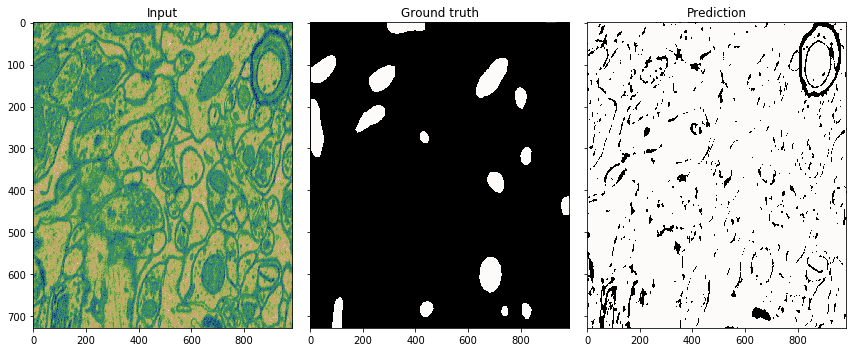

In [122]:
pruebas_electron_microscopy.test(model_electron_microscopy, 
                                 data_provider_electron_microscopy_test, 
                                 TRAINED_FOLDER_BROAD_005, 
                                 False)